In [1]:
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np
import pandas as pd
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
%matplotlib inline

/home/ejrueda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Se carga el MNIST con el que se va a probar la arquitectura.

In [2]:
data_train = pd.read_csv("./data/train.csv")
data_test = pd.read_csv("./data/test.csv")
data_train.shape, data_test.shape

((42000, 785), (28000, 784))

In [3]:
data_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


-- Imágenes originales --


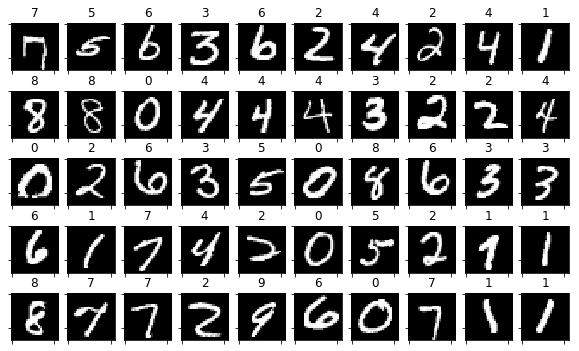

In [4]:
num_imgs = 50 #número de imágenes a mostrar aleatoriamente
fig = plt.figure(figsize=(10,6))
print("-- Imágenes originales --")
for i in range(num_imgs):
    ax=fig.add_subplot(5,10,i+1)
    rdm_img = np.random.randint(1,data_train.shape[0]-1)
    plt.imshow(np.array(data_train.iloc[rdm_img,1:]).reshape(28,28), cmap = plt.cm.Greys_r)
    ax.set_title(int(data_train.iloc[rdm_img,0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#### Ejemplo del generador de ruido:
- se generan imágenes a partir de una distribución gausiana, para con ellas estimar la nuevas imágenes.

In [8]:
#se crea el modelo secuencial el cual hará las veces de generador de ruido
model = Sequential()
model.add(Dense(256, input_shape=(100,)))
model.add(LeakyReLU(alpha=0.2)) #función rectificadora
model.add(Dropout(0.1))
model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1024))
model.add(Dropout(0.1))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(28  * 28 * 1, activation='tanh'))
model.add(Reshape((28, 28, 1)))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))

In [9]:
#model.summary()
batch = 640
gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
syntetic_images = model.predict(gen_noise)
print("Imágenes: ",syntetic_images.shape)

Imágenes:  (320, 28, 28, 1)


imágenes que genera el modelo


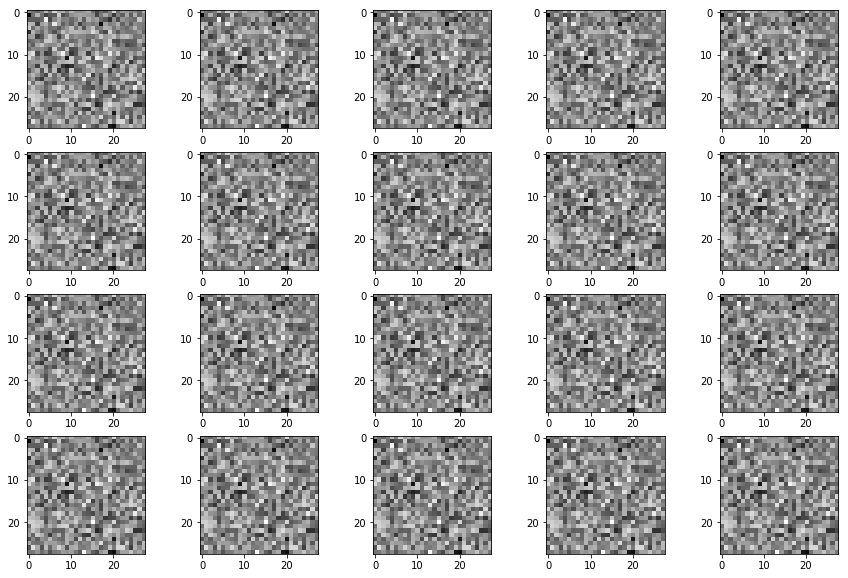

In [19]:
num_imgs = 20
plt.figure(figsize=(15,10))
print("imágenes que genera el modelo")
for i in range(num_imgs):
    plt.subplot(4,5,i+1)
    img_idx = np.random.randint(0,syntetic_images.shape[0])
    plt.imshow(syntetic_images[0,:,:].reshape(28,28), cmap="gray")

## Generative Adversarial Networks - GANs
- Se crea una clase llamada "GANs" y en ella se define tanto el generador como el discriminador, tambien el método para unir los dos modelos "__stacked_generator_discriminator". Por último se crea el método train el cual entrena la red.

In [5]:
import os
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

class GANs:
    #inicialización de variables
    def __init__(self, width=28, height=28, channels=1):
        self.WIDTH = width
        self.HEIGHT = height
        self.CHANNELS = channels
        self.SHAPE = (width, height, channels)
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5, decay=8e-8)
        self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.G = self.noise_generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        #print("Compilando el generador...")
        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        #print("Compilando el discriminador...")
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #Para unir el generador y el disctiminador
    def __stacked_generator_discriminator(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    #generador de ruido
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        #model.add(Dropout(0.1))
        model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
        model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        #model.add(Dropout(0.1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.WIDTH  * self.HEIGHT * self.CHANNELS, activation='tanh'))
        model.add(Reshape((self.WIDTH, self.HEIGHT, self.CHANNELS)))
        return model

    #Discriminador del modelo
    def discriminator(self):    
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.WIDTH * self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.WIDTH * self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()
        return model
    
    #Entrenar la GANs
    def train(self, X_train, epochs, batch):
        ## train discriminator
        for cnt in range(epochs):
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            legit_images = X_train[random_index:random_index + np.int64(batch/2)].reshape(np.int64(batch/2),
                                                                                            self.WIDTH,
                                                                                            self.HEIGHT,
                                                                                            self.CHANNELS)
            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            #print(gen_noise.shape)
            syntetic_images = self.G.predict(gen_noise)
            #print(legit_images.shape, syntetic_images.shape)
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)),
                                               np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator
            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0],
                                                                                           g_loss))
            #bined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))
            if (cnt % 100) ==0: #para dibujar unos pocos
                self.plot_images(save2file=True, samples=20, step=cnt)
            
    def plot_images(self, save2file=False, samples=20, step=0):
        # Para pintar o guardar las imágenes
        if not os.path.exists("./images"):
            os.makedirs("./images")
        filename = "./images/mnist_" + str(step) + ".png"
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)
        #print(images.shape)
        plt.figure(figsize=(10, 10))

        for i in range(images.shape[0]):
            plt.subplot(4, 5, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.HEIGHT, self.WIDTH])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

In [6]:
X_train = np.array(data_train.iloc[:,1:])
y_train = np.array(data_train.iloc[:,0])

In [7]:
m = 255/2
X_train = (X_train.astype(np.float32) - m) / m
X_train = np.expand_dims(X_train, axis=3)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
#np.expand_dims - Para expandir las dimensiones de un array

In [9]:
gan = GANs()
gan.train(X_train,epochs=20000,batch=128)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.809916], [ Generator :: loss: 0.925263]
epoch: 1, [Discriminator :: d_loss: 0.508818], [ Generator :: loss: 0.911454]
epoch: 2, [Discriminator :: d_loss: 0.386231], [ Generator :: loss: 0.953389]
epoch: 3, [Discriminator :: d_loss: 0.318669], [ Generator :: loss: 1.012322]
epoch: 4, [Discriminator :: d_loss: 0.265729], [ Generator :: loss: 1.085403]
epoch: 5, [Discriminator :: d_loss: 0.250400], [ Generator :: loss: 1.155694]
epoch: 6, [Discriminator :: d_loss: 0.234987], [ Generator :: loss: 1.274646]
epoch: 7, [Discriminator :: d_loss: 0.200916], [ Generator :: loss: 1.362617]
epoch: 8, [Discriminator :: d_loss: 0.179957], [ Generator :: loss: 1.450286]
epoch: 9, [Discriminator :: d_loss: 0.157991], [ Generator :: loss: 1.551989]
epoch: 10, [Discriminator :: d_loss: 0.136976], [ Generator :: loss: 1.635218]
epoch: 11, [Discriminator :: d_loss: 0.135172], [ Generator :: loss: 1.719780]
epoch: 12, [Discriminator :: d_loss: 0.129137], [ Generator ::

epoch: 104, [Discriminator :: d_loss: 0.018620], [ Generator :: loss: 4.143353]
epoch: 105, [Discriminator :: d_loss: 0.016193], [ Generator :: loss: 4.176321]
epoch: 106, [Discriminator :: d_loss: 0.015219], [ Generator :: loss: 4.114282]
epoch: 107, [Discriminator :: d_loss: 0.016038], [ Generator :: loss: 4.125006]
epoch: 108, [Discriminator :: d_loss: 0.014769], [ Generator :: loss: 4.152545]
epoch: 109, [Discriminator :: d_loss: 0.018536], [ Generator :: loss: 4.123434]
epoch: 110, [Discriminator :: d_loss: 0.017018], [ Generator :: loss: 4.207124]
epoch: 111, [Discriminator :: d_loss: 0.018140], [ Generator :: loss: 4.119850]
epoch: 112, [Discriminator :: d_loss: 0.018688], [ Generator :: loss: 4.148060]
epoch: 113, [Discriminator :: d_loss: 0.017346], [ Generator :: loss: 4.189191]
epoch: 114, [Discriminator :: d_loss: 0.014797], [ Generator :: loss: 4.175465]
epoch: 115, [Discriminator :: d_loss: 0.017953], [ Generator :: loss: 4.214904]
epoch: 116, [Discriminator :: d_loss: 0.

epoch: 208, [Discriminator :: d_loss: 0.598728], [ Generator :: loss: 1.960677]
epoch: 209, [Discriminator :: d_loss: 0.604775], [ Generator :: loss: 2.084801]
epoch: 210, [Discriminator :: d_loss: 0.280588], [ Generator :: loss: 2.760151]
epoch: 211, [Discriminator :: d_loss: 0.131280], [ Generator :: loss: 3.181182]
epoch: 212, [Discriminator :: d_loss: 0.113856], [ Generator :: loss: 3.653867]
epoch: 213, [Discriminator :: d_loss: 0.090877], [ Generator :: loss: 3.886252]
epoch: 214, [Discriminator :: d_loss: 0.066143], [ Generator :: loss: 4.017632]
epoch: 215, [Discriminator :: d_loss: 0.118915], [ Generator :: loss: 3.751605]
epoch: 216, [Discriminator :: d_loss: 0.077129], [ Generator :: loss: 3.388610]
epoch: 217, [Discriminator :: d_loss: 0.103205], [ Generator :: loss: 3.152505]
epoch: 218, [Discriminator :: d_loss: 0.111938], [ Generator :: loss: 2.915691]
epoch: 219, [Discriminator :: d_loss: 0.131524], [ Generator :: loss: 3.052261]
epoch: 220, [Discriminator :: d_loss: 0.

epoch: 312, [Discriminator :: d_loss: 0.252748], [ Generator :: loss: 2.114399]
epoch: 313, [Discriminator :: d_loss: 0.240205], [ Generator :: loss: 2.096424]
epoch: 314, [Discriminator :: d_loss: 0.239644], [ Generator :: loss: 1.432469]
epoch: 315, [Discriminator :: d_loss: 0.316645], [ Generator :: loss: 2.064425]
epoch: 316, [Discriminator :: d_loss: 0.288621], [ Generator :: loss: 1.750169]
epoch: 317, [Discriminator :: d_loss: 0.219624], [ Generator :: loss: 2.025287]
epoch: 318, [Discriminator :: d_loss: 0.304056], [ Generator :: loss: 0.914950]
epoch: 319, [Discriminator :: d_loss: 0.610625], [ Generator :: loss: 2.104183]
epoch: 320, [Discriminator :: d_loss: 0.238740], [ Generator :: loss: 3.076408]
epoch: 321, [Discriminator :: d_loss: 0.430678], [ Generator :: loss: 0.726378]
epoch: 322, [Discriminator :: d_loss: 0.794735], [ Generator :: loss: 0.836644]
epoch: 323, [Discriminator :: d_loss: 0.684394], [ Generator :: loss: 2.603889]
epoch: 324, [Discriminator :: d_loss: 0.

epoch: 416, [Discriminator :: d_loss: 0.557547], [ Generator :: loss: 1.028160]
epoch: 417, [Discriminator :: d_loss: 0.581965], [ Generator :: loss: 0.501496]
epoch: 418, [Discriminator :: d_loss: 0.582962], [ Generator :: loss: 0.911027]
epoch: 419, [Discriminator :: d_loss: 0.539009], [ Generator :: loss: 0.696385]
epoch: 420, [Discriminator :: d_loss: 0.549345], [ Generator :: loss: 0.663295]
epoch: 421, [Discriminator :: d_loss: 0.536497], [ Generator :: loss: 0.948182]
epoch: 422, [Discriminator :: d_loss: 0.573952], [ Generator :: loss: 0.527643]
epoch: 423, [Discriminator :: d_loss: 0.600209], [ Generator :: loss: 0.929648]
epoch: 424, [Discriminator :: d_loss: 0.549809], [ Generator :: loss: 0.621482]
epoch: 425, [Discriminator :: d_loss: 0.559309], [ Generator :: loss: 0.780832]
epoch: 426, [Discriminator :: d_loss: 0.554417], [ Generator :: loss: 0.774584]
epoch: 427, [Discriminator :: d_loss: 0.513715], [ Generator :: loss: 0.797909]
epoch: 428, [Discriminator :: d_loss: 0.

epoch: 522, [Discriminator :: d_loss: 0.506431], [ Generator :: loss: 0.513970]
epoch: 523, [Discriminator :: d_loss: 0.558872], [ Generator :: loss: 1.287953]
epoch: 524, [Discriminator :: d_loss: 0.518319], [ Generator :: loss: 0.489060]
epoch: 525, [Discriminator :: d_loss: 0.542623], [ Generator :: loss: 1.222670]
epoch: 526, [Discriminator :: d_loss: 0.476793], [ Generator :: loss: 0.685925]
epoch: 527, [Discriminator :: d_loss: 0.464033], [ Generator :: loss: 1.098373]
epoch: 528, [Discriminator :: d_loss: 0.459993], [ Generator :: loss: 0.694658]
epoch: 529, [Discriminator :: d_loss: 0.454930], [ Generator :: loss: 1.185998]
epoch: 530, [Discriminator :: d_loss: 0.457675], [ Generator :: loss: 0.590162]
epoch: 531, [Discriminator :: d_loss: 0.489493], [ Generator :: loss: 1.343955]
epoch: 532, [Discriminator :: d_loss: 0.510453], [ Generator :: loss: 0.443562]
epoch: 533, [Discriminator :: d_loss: 0.570618], [ Generator :: loss: 1.355057]
epoch: 534, [Discriminator :: d_loss: 0.

epoch: 625, [Discriminator :: d_loss: 0.503445], [ Generator :: loss: 0.621184]
epoch: 626, [Discriminator :: d_loss: 0.508553], [ Generator :: loss: 1.243537]
epoch: 627, [Discriminator :: d_loss: 0.487703], [ Generator :: loss: 0.557440]
epoch: 628, [Discriminator :: d_loss: 0.519369], [ Generator :: loss: 1.319678]
epoch: 629, [Discriminator :: d_loss: 0.528639], [ Generator :: loss: 0.438562]
epoch: 630, [Discriminator :: d_loss: 0.597653], [ Generator :: loss: 1.408352]
epoch: 631, [Discriminator :: d_loss: 0.530864], [ Generator :: loss: 0.496589]
epoch: 632, [Discriminator :: d_loss: 0.557415], [ Generator :: loss: 1.292659]
epoch: 633, [Discriminator :: d_loss: 0.558625], [ Generator :: loss: 0.486601]
epoch: 634, [Discriminator :: d_loss: 0.561925], [ Generator :: loss: 1.286002]
epoch: 635, [Discriminator :: d_loss: 0.498184], [ Generator :: loss: 0.630574]
epoch: 636, [Discriminator :: d_loss: 0.491230], [ Generator :: loss: 1.078506]
epoch: 637, [Discriminator :: d_loss: 0.

epoch: 731, [Discriminator :: d_loss: 0.536064], [ Generator :: loss: 0.511143]
epoch: 732, [Discriminator :: d_loss: 0.564318], [ Generator :: loss: 1.392939]
epoch: 733, [Discriminator :: d_loss: 0.534783], [ Generator :: loss: 0.586481]
epoch: 734, [Discriminator :: d_loss: 0.518738], [ Generator :: loss: 1.304653]
epoch: 735, [Discriminator :: d_loss: 0.515496], [ Generator :: loss: 0.522268]
epoch: 736, [Discriminator :: d_loss: 0.543473], [ Generator :: loss: 1.389577]
epoch: 737, [Discriminator :: d_loss: 0.537013], [ Generator :: loss: 0.529554]
epoch: 738, [Discriminator :: d_loss: 0.526227], [ Generator :: loss: 1.313940]
epoch: 739, [Discriminator :: d_loss: 0.521677], [ Generator :: loss: 0.691691]
epoch: 740, [Discriminator :: d_loss: 0.501492], [ Generator :: loss: 1.083148]
epoch: 741, [Discriminator :: d_loss: 0.494860], [ Generator :: loss: 0.758569]
epoch: 742, [Discriminator :: d_loss: 0.499091], [ Generator :: loss: 1.046577]
epoch: 743, [Discriminator :: d_loss: 0.

epoch: 837, [Discriminator :: d_loss: 0.584624], [ Generator :: loss: 1.379682]
epoch: 838, [Discriminator :: d_loss: 0.558006], [ Generator :: loss: 0.544696]
epoch: 839, [Discriminator :: d_loss: 0.576819], [ Generator :: loss: 1.290442]
epoch: 840, [Discriminator :: d_loss: 0.535436], [ Generator :: loss: 0.569381]
epoch: 841, [Discriminator :: d_loss: 0.564401], [ Generator :: loss: 1.272568]
epoch: 842, [Discriminator :: d_loss: 0.537018], [ Generator :: loss: 0.549446]
epoch: 843, [Discriminator :: d_loss: 0.570806], [ Generator :: loss: 1.441659]
epoch: 844, [Discriminator :: d_loss: 0.572520], [ Generator :: loss: 0.482082]
epoch: 845, [Discriminator :: d_loss: 0.600313], [ Generator :: loss: 1.403825]
epoch: 846, [Discriminator :: d_loss: 0.551627], [ Generator :: loss: 0.587781]
epoch: 847, [Discriminator :: d_loss: 0.540459], [ Generator :: loss: 1.174668]
epoch: 848, [Discriminator :: d_loss: 0.565770], [ Generator :: loss: 0.578077]
epoch: 849, [Discriminator :: d_loss: 0.

epoch: 941, [Discriminator :: d_loss: 0.524843], [ Generator :: loss: 0.891759]
epoch: 942, [Discriminator :: d_loss: 0.514461], [ Generator :: loss: 0.889333]
epoch: 943, [Discriminator :: d_loss: 0.503208], [ Generator :: loss: 0.999930]
epoch: 944, [Discriminator :: d_loss: 0.524046], [ Generator :: loss: 0.763039]
epoch: 945, [Discriminator :: d_loss: 0.524133], [ Generator :: loss: 1.256578]
epoch: 946, [Discriminator :: d_loss: 0.553374], [ Generator :: loss: 0.553345]
epoch: 947, [Discriminator :: d_loss: 0.584694], [ Generator :: loss: 1.341870]
epoch: 948, [Discriminator :: d_loss: 0.565358], [ Generator :: loss: 0.459126]
epoch: 949, [Discriminator :: d_loss: 0.628923], [ Generator :: loss: 1.479303]
epoch: 950, [Discriminator :: d_loss: 0.604502], [ Generator :: loss: 0.530942]
epoch: 951, [Discriminator :: d_loss: 0.583081], [ Generator :: loss: 1.216478]
epoch: 952, [Discriminator :: d_loss: 0.558983], [ Generator :: loss: 0.741910]
epoch: 953, [Discriminator :: d_loss: 0.

epoch: 1045, [Discriminator :: d_loss: 0.591500], [ Generator :: loss: 1.150679]
epoch: 1046, [Discriminator :: d_loss: 0.549918], [ Generator :: loss: 0.784761]
epoch: 1047, [Discriminator :: d_loss: 0.553467], [ Generator :: loss: 0.942067]
epoch: 1048, [Discriminator :: d_loss: 0.531872], [ Generator :: loss: 0.802227]
epoch: 1049, [Discriminator :: d_loss: 0.546158], [ Generator :: loss: 0.913511]
epoch: 1050, [Discriminator :: d_loss: 0.541883], [ Generator :: loss: 0.829668]
epoch: 1051, [Discriminator :: d_loss: 0.536070], [ Generator :: loss: 0.935314]
epoch: 1052, [Discriminator :: d_loss: 0.562943], [ Generator :: loss: 0.767831]
epoch: 1053, [Discriminator :: d_loss: 0.544989], [ Generator :: loss: 0.980647]
epoch: 1054, [Discriminator :: d_loss: 0.536425], [ Generator :: loss: 0.795956]
epoch: 1055, [Discriminator :: d_loss: 0.559055], [ Generator :: loss: 0.939080]
epoch: 1056, [Discriminator :: d_loss: 0.553083], [ Generator :: loss: 0.739818]
epoch: 1057, [Discriminator 

epoch: 1149, [Discriminator :: d_loss: 0.562882], [ Generator :: loss: 0.645719]
epoch: 1150, [Discriminator :: d_loss: 0.575891], [ Generator :: loss: 1.124063]
epoch: 1151, [Discriminator :: d_loss: 0.572130], [ Generator :: loss: 0.701853]
epoch: 1152, [Discriminator :: d_loss: 0.576369], [ Generator :: loss: 0.973776]
epoch: 1153, [Discriminator :: d_loss: 0.540891], [ Generator :: loss: 0.797194]
epoch: 1154, [Discriminator :: d_loss: 0.558119], [ Generator :: loss: 0.997015]
epoch: 1155, [Discriminator :: d_loss: 0.546109], [ Generator :: loss: 0.658322]
epoch: 1156, [Discriminator :: d_loss: 0.573063], [ Generator :: loss: 1.041271]
epoch: 1157, [Discriminator :: d_loss: 0.566983], [ Generator :: loss: 0.654636]
epoch: 1158, [Discriminator :: d_loss: 0.565948], [ Generator :: loss: 1.186166]
epoch: 1159, [Discriminator :: d_loss: 0.552384], [ Generator :: loss: 0.621545]
epoch: 1160, [Discriminator :: d_loss: 0.570758], [ Generator :: loss: 1.169964]
epoch: 1161, [Discriminator 

epoch: 1253, [Discriminator :: d_loss: 0.709902], [ Generator :: loss: 1.446306]
epoch: 1254, [Discriminator :: d_loss: 0.707420], [ Generator :: loss: 0.409592]
epoch: 1255, [Discriminator :: d_loss: 0.691574], [ Generator :: loss: 1.315014]
epoch: 1256, [Discriminator :: d_loss: 0.609814], [ Generator :: loss: 0.760750]
epoch: 1257, [Discriminator :: d_loss: 0.578588], [ Generator :: loss: 0.796126]
epoch: 1258, [Discriminator :: d_loss: 0.581666], [ Generator :: loss: 0.998073]
epoch: 1259, [Discriminator :: d_loss: 0.576602], [ Generator :: loss: 0.780473]
epoch: 1260, [Discriminator :: d_loss: 0.586609], [ Generator :: loss: 0.897053]
epoch: 1261, [Discriminator :: d_loss: 0.568344], [ Generator :: loss: 0.775088]
epoch: 1262, [Discriminator :: d_loss: 0.603889], [ Generator :: loss: 0.885249]
epoch: 1263, [Discriminator :: d_loss: 0.551204], [ Generator :: loss: 0.922660]
epoch: 1264, [Discriminator :: d_loss: 0.567702], [ Generator :: loss: 0.695295]
epoch: 1265, [Discriminator 

epoch: 1357, [Discriminator :: d_loss: 0.611845], [ Generator :: loss: 0.601212]
epoch: 1358, [Discriminator :: d_loss: 0.614561], [ Generator :: loss: 1.345043]
epoch: 1359, [Discriminator :: d_loss: 0.635529], [ Generator :: loss: 0.482179]
epoch: 1360, [Discriminator :: d_loss: 0.673758], [ Generator :: loss: 1.444738]
epoch: 1361, [Discriminator :: d_loss: 0.654809], [ Generator :: loss: 0.460388]
epoch: 1362, [Discriminator :: d_loss: 0.652858], [ Generator :: loss: 1.409063]
epoch: 1363, [Discriminator :: d_loss: 0.617535], [ Generator :: loss: 0.484926]
epoch: 1364, [Discriminator :: d_loss: 0.651515], [ Generator :: loss: 1.383106]
epoch: 1365, [Discriminator :: d_loss: 0.629863], [ Generator :: loss: 0.492977]
epoch: 1366, [Discriminator :: d_loss: 0.641807], [ Generator :: loss: 1.288486]
epoch: 1367, [Discriminator :: d_loss: 0.570558], [ Generator :: loss: 0.714333]
epoch: 1368, [Discriminator :: d_loss: 0.553116], [ Generator :: loss: 1.054204]
epoch: 1369, [Discriminator 

epoch: 1461, [Discriminator :: d_loss: 0.567448], [ Generator :: loss: 0.837631]
epoch: 1462, [Discriminator :: d_loss: 0.538930], [ Generator :: loss: 1.087564]
epoch: 1463, [Discriminator :: d_loss: 0.526047], [ Generator :: loss: 0.799399]
epoch: 1464, [Discriminator :: d_loss: 0.569063], [ Generator :: loss: 1.163381]
epoch: 1465, [Discriminator :: d_loss: 0.583134], [ Generator :: loss: 0.630096]
epoch: 1466, [Discriminator :: d_loss: 0.593381], [ Generator :: loss: 1.348793]
epoch: 1467, [Discriminator :: d_loss: 0.636597], [ Generator :: loss: 0.559139]
epoch: 1468, [Discriminator :: d_loss: 0.624272], [ Generator :: loss: 1.452235]
epoch: 1469, [Discriminator :: d_loss: 0.658530], [ Generator :: loss: 0.462435]
epoch: 1470, [Discriminator :: d_loss: 0.665437], [ Generator :: loss: 1.495926]
epoch: 1471, [Discriminator :: d_loss: 0.658123], [ Generator :: loss: 0.498870]
epoch: 1472, [Discriminator :: d_loss: 0.663317], [ Generator :: loss: 1.250933]
epoch: 1473, [Discriminator 

epoch: 1565, [Discriminator :: d_loss: 0.624565], [ Generator :: loss: 1.401450]
epoch: 1566, [Discriminator :: d_loss: 0.612211], [ Generator :: loss: 0.523971]
epoch: 1567, [Discriminator :: d_loss: 0.602496], [ Generator :: loss: 1.523102]
epoch: 1568, [Discriminator :: d_loss: 0.669770], [ Generator :: loss: 0.500541]
epoch: 1569, [Discriminator :: d_loss: 0.640966], [ Generator :: loss: 1.357279]
epoch: 1570, [Discriminator :: d_loss: 0.600627], [ Generator :: loss: 0.656119]
epoch: 1571, [Discriminator :: d_loss: 0.562918], [ Generator :: loss: 1.135803]
epoch: 1572, [Discriminator :: d_loss: 0.538576], [ Generator :: loss: 0.739787]
epoch: 1573, [Discriminator :: d_loss: 0.554322], [ Generator :: loss: 1.193011]
epoch: 1574, [Discriminator :: d_loss: 0.535435], [ Generator :: loss: 0.729228]
epoch: 1575, [Discriminator :: d_loss: 0.546101], [ Generator :: loss: 1.141330]
epoch: 1576, [Discriminator :: d_loss: 0.569122], [ Generator :: loss: 0.748634]
epoch: 1577, [Discriminator 

epoch: 1669, [Discriminator :: d_loss: 0.630921], [ Generator :: loss: 0.582591]
epoch: 1670, [Discriminator :: d_loss: 0.623694], [ Generator :: loss: 1.233572]
epoch: 1671, [Discriminator :: d_loss: 0.614043], [ Generator :: loss: 0.603761]
epoch: 1672, [Discriminator :: d_loss: 0.616474], [ Generator :: loss: 1.074744]
epoch: 1673, [Discriminator :: d_loss: 0.565010], [ Generator :: loss: 0.798142]
epoch: 1674, [Discriminator :: d_loss: 0.603159], [ Generator :: loss: 0.873235]
epoch: 1675, [Discriminator :: d_loss: 0.565763], [ Generator :: loss: 0.992257]
epoch: 1676, [Discriminator :: d_loss: 0.568186], [ Generator :: loss: 0.809937]
epoch: 1677, [Discriminator :: d_loss: 0.598610], [ Generator :: loss: 0.922929]
epoch: 1678, [Discriminator :: d_loss: 0.589318], [ Generator :: loss: 0.794405]
epoch: 1679, [Discriminator :: d_loss: 0.590227], [ Generator :: loss: 0.952117]
epoch: 1680, [Discriminator :: d_loss: 0.552664], [ Generator :: loss: 0.744192]
epoch: 1681, [Discriminator 

epoch: 1773, [Discriminator :: d_loss: 0.601754], [ Generator :: loss: 1.311746]
epoch: 1774, [Discriminator :: d_loss: 0.603176], [ Generator :: loss: 0.747416]
epoch: 1775, [Discriminator :: d_loss: 0.553363], [ Generator :: loss: 1.216850]
epoch: 1776, [Discriminator :: d_loss: 0.594048], [ Generator :: loss: 0.682166]
epoch: 1777, [Discriminator :: d_loss: 0.567140], [ Generator :: loss: 1.021104]
epoch: 1778, [Discriminator :: d_loss: 0.553224], [ Generator :: loss: 0.920744]
epoch: 1779, [Discriminator :: d_loss: 0.587133], [ Generator :: loss: 0.828148]
epoch: 1780, [Discriminator :: d_loss: 0.591318], [ Generator :: loss: 1.022013]
epoch: 1781, [Discriminator :: d_loss: 0.545390], [ Generator :: loss: 0.872330]
epoch: 1782, [Discriminator :: d_loss: 0.544954], [ Generator :: loss: 0.954395]
epoch: 1783, [Discriminator :: d_loss: 0.552821], [ Generator :: loss: 0.957140]
epoch: 1784, [Discriminator :: d_loss: 0.556429], [ Generator :: loss: 0.882603]
epoch: 1785, [Discriminator 

epoch: 1877, [Discriminator :: d_loss: 0.674299], [ Generator :: loss: 1.351877]
epoch: 1878, [Discriminator :: d_loss: 0.687818], [ Generator :: loss: 0.453176]
epoch: 1879, [Discriminator :: d_loss: 0.682500], [ Generator :: loss: 1.308920]
epoch: 1880, [Discriminator :: d_loss: 0.634627], [ Generator :: loss: 0.758868]
epoch: 1881, [Discriminator :: d_loss: 0.606714], [ Generator :: loss: 0.784669]
epoch: 1882, [Discriminator :: d_loss: 0.643923], [ Generator :: loss: 1.059499]
epoch: 1883, [Discriminator :: d_loss: 0.621164], [ Generator :: loss: 0.650731]
epoch: 1884, [Discriminator :: d_loss: 0.628143], [ Generator :: loss: 1.114109]
epoch: 1885, [Discriminator :: d_loss: 0.620340], [ Generator :: loss: 0.637665]
epoch: 1886, [Discriminator :: d_loss: 0.676491], [ Generator :: loss: 1.033749]
epoch: 1887, [Discriminator :: d_loss: 0.602491], [ Generator :: loss: 0.684098]
epoch: 1888, [Discriminator :: d_loss: 0.613441], [ Generator :: loss: 1.003134]
epoch: 1889, [Discriminator 

epoch: 1981, [Discriminator :: d_loss: 0.533569], [ Generator :: loss: 1.014052]
epoch: 1982, [Discriminator :: d_loss: 0.528847], [ Generator :: loss: 0.884010]
epoch: 1983, [Discriminator :: d_loss: 0.504276], [ Generator :: loss: 0.971261]
epoch: 1984, [Discriminator :: d_loss: 0.532723], [ Generator :: loss: 0.935993]
epoch: 1985, [Discriminator :: d_loss: 0.556741], [ Generator :: loss: 1.000115]
epoch: 1986, [Discriminator :: d_loss: 0.531374], [ Generator :: loss: 0.911074]
epoch: 1987, [Discriminator :: d_loss: 0.540581], [ Generator :: loss: 1.048346]
epoch: 1988, [Discriminator :: d_loss: 0.532811], [ Generator :: loss: 0.898044]
epoch: 1989, [Discriminator :: d_loss: 0.538146], [ Generator :: loss: 1.067315]
epoch: 1990, [Discriminator :: d_loss: 0.557577], [ Generator :: loss: 0.616367]
epoch: 1991, [Discriminator :: d_loss: 0.585463], [ Generator :: loss: 1.618873]
epoch: 1992, [Discriminator :: d_loss: 0.614019], [ Generator :: loss: 0.499772]
epoch: 1993, [Discriminator 

epoch: 2085, [Discriminator :: d_loss: 0.615261], [ Generator :: loss: 0.753142]
epoch: 2086, [Discriminator :: d_loss: 0.596487], [ Generator :: loss: 1.026638]
epoch: 2087, [Discriminator :: d_loss: 0.549858], [ Generator :: loss: 0.906040]
epoch: 2088, [Discriminator :: d_loss: 0.526469], [ Generator :: loss: 1.217094]
epoch: 2089, [Discriminator :: d_loss: 0.608680], [ Generator :: loss: 0.530041]
epoch: 2090, [Discriminator :: d_loss: 0.618665], [ Generator :: loss: 1.632071]
epoch: 2091, [Discriminator :: d_loss: 0.605904], [ Generator :: loss: 0.544802]
epoch: 2092, [Discriminator :: d_loss: 0.646096], [ Generator :: loss: 1.210388]
epoch: 2093, [Discriminator :: d_loss: 0.610950], [ Generator :: loss: 0.718503]
epoch: 2094, [Discriminator :: d_loss: 0.526815], [ Generator :: loss: 1.262668]
epoch: 2095, [Discriminator :: d_loss: 0.557959], [ Generator :: loss: 0.714067]
epoch: 2096, [Discriminator :: d_loss: 0.595885], [ Generator :: loss: 1.370576]
epoch: 2097, [Discriminator 

epoch: 2189, [Discriminator :: d_loss: 0.535193], [ Generator :: loss: 1.221753]
epoch: 2190, [Discriminator :: d_loss: 0.564828], [ Generator :: loss: 0.670901]
epoch: 2191, [Discriminator :: d_loss: 0.563722], [ Generator :: loss: 1.221610]
epoch: 2192, [Discriminator :: d_loss: 0.518960], [ Generator :: loss: 1.007472]
epoch: 2193, [Discriminator :: d_loss: 0.560614], [ Generator :: loss: 0.834587]
epoch: 2194, [Discriminator :: d_loss: 0.534154], [ Generator :: loss: 1.259896]
epoch: 2195, [Discriminator :: d_loss: 0.538165], [ Generator :: loss: 0.775772]
epoch: 2196, [Discriminator :: d_loss: 0.545166], [ Generator :: loss: 1.150729]
epoch: 2197, [Discriminator :: d_loss: 0.517376], [ Generator :: loss: 0.865926]
epoch: 2198, [Discriminator :: d_loss: 0.534369], [ Generator :: loss: 1.163070]
epoch: 2199, [Discriminator :: d_loss: 0.529689], [ Generator :: loss: 0.815819]
epoch: 2200, [Discriminator :: d_loss: 0.560854], [ Generator :: loss: 1.104331]
epoch: 2201, [Discriminator 

epoch: 2293, [Discriminator :: d_loss: 0.586400], [ Generator :: loss: 0.942646]
epoch: 2294, [Discriminator :: d_loss: 0.577891], [ Generator :: loss: 0.873781]
epoch: 2295, [Discriminator :: d_loss: 0.586139], [ Generator :: loss: 0.977086]
epoch: 2296, [Discriminator :: d_loss: 0.582701], [ Generator :: loss: 0.859206]
epoch: 2297, [Discriminator :: d_loss: 0.621620], [ Generator :: loss: 0.907089]
epoch: 2298, [Discriminator :: d_loss: 0.572768], [ Generator :: loss: 0.954741]
epoch: 2299, [Discriminator :: d_loss: 0.613430], [ Generator :: loss: 0.766813]
epoch: 2300, [Discriminator :: d_loss: 0.588559], [ Generator :: loss: 1.321308]
epoch: 2301, [Discriminator :: d_loss: 0.617264], [ Generator :: loss: 0.487191]
epoch: 2302, [Discriminator :: d_loss: 0.648932], [ Generator :: loss: 1.658774]
epoch: 2303, [Discriminator :: d_loss: 0.683995], [ Generator :: loss: 0.394237]
epoch: 2304, [Discriminator :: d_loss: 0.763868], [ Generator :: loss: 1.712897]
epoch: 2305, [Discriminator 

epoch: 2397, [Discriminator :: d_loss: 0.564931], [ Generator :: loss: 0.849584]
epoch: 2398, [Discriminator :: d_loss: 0.555905], [ Generator :: loss: 1.053502]
epoch: 2399, [Discriminator :: d_loss: 0.608620], [ Generator :: loss: 0.663522]
epoch: 2400, [Discriminator :: d_loss: 0.572587], [ Generator :: loss: 1.417313]
epoch: 2401, [Discriminator :: d_loss: 0.592127], [ Generator :: loss: 0.499751]
epoch: 2402, [Discriminator :: d_loss: 0.639893], [ Generator :: loss: 1.608719]
epoch: 2403, [Discriminator :: d_loss: 0.690135], [ Generator :: loss: 0.507982]
epoch: 2404, [Discriminator :: d_loss: 0.674521], [ Generator :: loss: 1.439872]
epoch: 2405, [Discriminator :: d_loss: 0.645338], [ Generator :: loss: 0.618256]
epoch: 2406, [Discriminator :: d_loss: 0.629478], [ Generator :: loss: 1.266399]
epoch: 2407, [Discriminator :: d_loss: 0.571656], [ Generator :: loss: 0.776868]
epoch: 2408, [Discriminator :: d_loss: 0.551449], [ Generator :: loss: 0.954260]
epoch: 2409, [Discriminator 

epoch: 2501, [Discriminator :: d_loss: 0.548916], [ Generator :: loss: 0.759519]
epoch: 2502, [Discriminator :: d_loss: 0.544290], [ Generator :: loss: 1.238294]
epoch: 2503, [Discriminator :: d_loss: 0.576064], [ Generator :: loss: 0.795911]
epoch: 2504, [Discriminator :: d_loss: 0.566531], [ Generator :: loss: 0.973580]
epoch: 2505, [Discriminator :: d_loss: 0.571854], [ Generator :: loss: 0.962766]
epoch: 2506, [Discriminator :: d_loss: 0.582672], [ Generator :: loss: 0.732193]
epoch: 2507, [Discriminator :: d_loss: 0.558218], [ Generator :: loss: 1.424256]
epoch: 2508, [Discriminator :: d_loss: 0.672211], [ Generator :: loss: 0.448244]
epoch: 2509, [Discriminator :: d_loss: 0.650772], [ Generator :: loss: 1.569638]
epoch: 2510, [Discriminator :: d_loss: 0.664850], [ Generator :: loss: 0.532020]
epoch: 2511, [Discriminator :: d_loss: 0.681087], [ Generator :: loss: 1.305750]
epoch: 2512, [Discriminator :: d_loss: 0.603015], [ Generator :: loss: 0.740587]
epoch: 2513, [Discriminator 

epoch: 2605, [Discriminator :: d_loss: 0.530887], [ Generator :: loss: 1.213329]
epoch: 2606, [Discriminator :: d_loss: 0.577481], [ Generator :: loss: 0.679731]
epoch: 2607, [Discriminator :: d_loss: 0.616834], [ Generator :: loss: 1.209638]
epoch: 2608, [Discriminator :: d_loss: 0.573361], [ Generator :: loss: 0.827416]
epoch: 2609, [Discriminator :: d_loss: 0.540303], [ Generator :: loss: 1.249813]
epoch: 2610, [Discriminator :: d_loss: 0.584837], [ Generator :: loss: 0.713125]
epoch: 2611, [Discriminator :: d_loss: 0.590452], [ Generator :: loss: 1.339236]
epoch: 2612, [Discriminator :: d_loss: 0.565878], [ Generator :: loss: 0.683359]
epoch: 2613, [Discriminator :: d_loss: 0.575139], [ Generator :: loss: 1.177569]
epoch: 2614, [Discriminator :: d_loss: 0.577986], [ Generator :: loss: 0.752226]
epoch: 2615, [Discriminator :: d_loss: 0.579182], [ Generator :: loss: 1.146863]
epoch: 2616, [Discriminator :: d_loss: 0.542430], [ Generator :: loss: 0.756204]
epoch: 2617, [Discriminator 

epoch: 2709, [Discriminator :: d_loss: 0.640866], [ Generator :: loss: 1.353434]
epoch: 2710, [Discriminator :: d_loss: 0.575798], [ Generator :: loss: 0.826181]
epoch: 2711, [Discriminator :: d_loss: 0.544772], [ Generator :: loss: 1.058785]
epoch: 2712, [Discriminator :: d_loss: 0.546972], [ Generator :: loss: 0.807808]
epoch: 2713, [Discriminator :: d_loss: 0.545717], [ Generator :: loss: 1.081908]
epoch: 2714, [Discriminator :: d_loss: 0.556767], [ Generator :: loss: 0.886647]
epoch: 2715, [Discriminator :: d_loss: 0.566867], [ Generator :: loss: 1.169337]
epoch: 2716, [Discriminator :: d_loss: 0.508203], [ Generator :: loss: 0.886671]
epoch: 2717, [Discriminator :: d_loss: 0.597190], [ Generator :: loss: 0.872237]
epoch: 2718, [Discriminator :: d_loss: 0.574167], [ Generator :: loss: 1.108693]
epoch: 2719, [Discriminator :: d_loss: 0.569171], [ Generator :: loss: 0.715997]
epoch: 2720, [Discriminator :: d_loss: 0.544783], [ Generator :: loss: 1.483660]
epoch: 2721, [Discriminator 

epoch: 2813, [Discriminator :: d_loss: 0.514422], [ Generator :: loss: 1.013374]
epoch: 2814, [Discriminator :: d_loss: 0.532278], [ Generator :: loss: 0.934591]
epoch: 2815, [Discriminator :: d_loss: 0.502969], [ Generator :: loss: 1.031605]
epoch: 2816, [Discriminator :: d_loss: 0.562829], [ Generator :: loss: 0.790718]
epoch: 2817, [Discriminator :: d_loss: 0.526723], [ Generator :: loss: 1.265579]
epoch: 2818, [Discriminator :: d_loss: 0.556548], [ Generator :: loss: 0.717556]
epoch: 2819, [Discriminator :: d_loss: 0.587299], [ Generator :: loss: 1.217025]
epoch: 2820, [Discriminator :: d_loss: 0.562317], [ Generator :: loss: 0.760076]
epoch: 2821, [Discriminator :: d_loss: 0.571196], [ Generator :: loss: 1.100772]
epoch: 2822, [Discriminator :: d_loss: 0.584529], [ Generator :: loss: 0.846459]
epoch: 2823, [Discriminator :: d_loss: 0.533034], [ Generator :: loss: 0.992165]
epoch: 2824, [Discriminator :: d_loss: 0.503657], [ Generator :: loss: 1.164009]
epoch: 2825, [Discriminator 

epoch: 2917, [Discriminator :: d_loss: 0.548238], [ Generator :: loss: 1.289417]
epoch: 2918, [Discriminator :: d_loss: 0.592445], [ Generator :: loss: 0.722031]
epoch: 2919, [Discriminator :: d_loss: 0.555739], [ Generator :: loss: 1.305830]
epoch: 2920, [Discriminator :: d_loss: 0.575598], [ Generator :: loss: 0.593819]
epoch: 2921, [Discriminator :: d_loss: 0.571546], [ Generator :: loss: 1.391082]
epoch: 2922, [Discriminator :: d_loss: 0.574774], [ Generator :: loss: 0.681683]
epoch: 2923, [Discriminator :: d_loss: 0.536390], [ Generator :: loss: 1.204805]
epoch: 2924, [Discriminator :: d_loss: 0.576374], [ Generator :: loss: 0.842028]
epoch: 2925, [Discriminator :: d_loss: 0.507945], [ Generator :: loss: 1.130154]
epoch: 2926, [Discriminator :: d_loss: 0.552205], [ Generator :: loss: 0.939815]
epoch: 2927, [Discriminator :: d_loss: 0.512608], [ Generator :: loss: 1.027457]
epoch: 2928, [Discriminator :: d_loss: 0.514380], [ Generator :: loss: 1.012134]
epoch: 2929, [Discriminator 

epoch: 3021, [Discriminator :: d_loss: 0.553709], [ Generator :: loss: 1.161309]
epoch: 3022, [Discriminator :: d_loss: 0.583504], [ Generator :: loss: 0.707551]
epoch: 3023, [Discriminator :: d_loss: 0.556859], [ Generator :: loss: 1.316009]
epoch: 3024, [Discriminator :: d_loss: 0.613228], [ Generator :: loss: 0.575873]
epoch: 3025, [Discriminator :: d_loss: 0.635586], [ Generator :: loss: 1.525855]
epoch: 3026, [Discriminator :: d_loss: 0.673148], [ Generator :: loss: 0.537661]
epoch: 3027, [Discriminator :: d_loss: 0.602378], [ Generator :: loss: 1.485536]
epoch: 3028, [Discriminator :: d_loss: 0.645115], [ Generator :: loss: 0.601580]
epoch: 3029, [Discriminator :: d_loss: 0.627420], [ Generator :: loss: 1.287983]
epoch: 3030, [Discriminator :: d_loss: 0.586272], [ Generator :: loss: 0.811877]
epoch: 3031, [Discriminator :: d_loss: 0.508793], [ Generator :: loss: 1.072197]
epoch: 3032, [Discriminator :: d_loss: 0.583818], [ Generator :: loss: 0.905134]
epoch: 3033, [Discriminator 

epoch: 3125, [Discriminator :: d_loss: 0.542469], [ Generator :: loss: 0.948774]
epoch: 3126, [Discriminator :: d_loss: 0.563271], [ Generator :: loss: 0.984916]
epoch: 3127, [Discriminator :: d_loss: 0.526960], [ Generator :: loss: 0.786762]
epoch: 3128, [Discriminator :: d_loss: 0.576257], [ Generator :: loss: 1.142009]
epoch: 3129, [Discriminator :: d_loss: 0.561402], [ Generator :: loss: 0.709170]
epoch: 3130, [Discriminator :: d_loss: 0.576555], [ Generator :: loss: 1.342868]
epoch: 3131, [Discriminator :: d_loss: 0.605786], [ Generator :: loss: 0.588008]
epoch: 3132, [Discriminator :: d_loss: 0.630282], [ Generator :: loss: 1.456242]
epoch: 3133, [Discriminator :: d_loss: 0.629494], [ Generator :: loss: 0.534614]
epoch: 3134, [Discriminator :: d_loss: 0.621570], [ Generator :: loss: 1.349379]
epoch: 3135, [Discriminator :: d_loss: 0.636880], [ Generator :: loss: 0.575446]
epoch: 3136, [Discriminator :: d_loss: 0.590474], [ Generator :: loss: 1.300831]
epoch: 3137, [Discriminator 

epoch: 3229, [Discriminator :: d_loss: 0.595351], [ Generator :: loss: 0.882441]
epoch: 3230, [Discriminator :: d_loss: 0.566693], [ Generator :: loss: 0.839235]
epoch: 3231, [Discriminator :: d_loss: 0.583038], [ Generator :: loss: 1.135073]
epoch: 3232, [Discriminator :: d_loss: 0.588917], [ Generator :: loss: 0.678892]
epoch: 3233, [Discriminator :: d_loss: 0.542596], [ Generator :: loss: 1.115253]
epoch: 3234, [Discriminator :: d_loss: 0.651175], [ Generator :: loss: 0.661918]
epoch: 3235, [Discriminator :: d_loss: 0.632097], [ Generator :: loss: 1.085471]
epoch: 3236, [Discriminator :: d_loss: 0.584844], [ Generator :: loss: 0.735491]
epoch: 3237, [Discriminator :: d_loss: 0.603903], [ Generator :: loss: 1.067267]
epoch: 3238, [Discriminator :: d_loss: 0.557540], [ Generator :: loss: 0.872343]
epoch: 3239, [Discriminator :: d_loss: 0.533885], [ Generator :: loss: 0.983138]
epoch: 3240, [Discriminator :: d_loss: 0.553618], [ Generator :: loss: 0.962869]
epoch: 3241, [Discriminator 

epoch: 3333, [Discriminator :: d_loss: 0.553911], [ Generator :: loss: 1.111091]
epoch: 3334, [Discriminator :: d_loss: 0.536389], [ Generator :: loss: 0.813071]
epoch: 3335, [Discriminator :: d_loss: 0.527607], [ Generator :: loss: 1.401502]
epoch: 3336, [Discriminator :: d_loss: 0.560788], [ Generator :: loss: 0.597149]
epoch: 3337, [Discriminator :: d_loss: 0.578848], [ Generator :: loss: 1.384909]
epoch: 3338, [Discriminator :: d_loss: 0.634328], [ Generator :: loss: 0.639954]
epoch: 3339, [Discriminator :: d_loss: 0.589350], [ Generator :: loss: 1.365642]
epoch: 3340, [Discriminator :: d_loss: 0.560527], [ Generator :: loss: 0.852660]
epoch: 3341, [Discriminator :: d_loss: 0.553525], [ Generator :: loss: 0.842033]
epoch: 3342, [Discriminator :: d_loss: 0.559816], [ Generator :: loss: 1.173475]
epoch: 3343, [Discriminator :: d_loss: 0.573403], [ Generator :: loss: 0.758581]
epoch: 3344, [Discriminator :: d_loss: 0.546717], [ Generator :: loss: 1.159058]
epoch: 3345, [Discriminator 

epoch: 3437, [Discriminator :: d_loss: 0.608981], [ Generator :: loss: 1.555631]
epoch: 3438, [Discriminator :: d_loss: 0.633856], [ Generator :: loss: 0.505099]
epoch: 3439, [Discriminator :: d_loss: 0.644366], [ Generator :: loss: 1.378197]
epoch: 3440, [Discriminator :: d_loss: 0.617953], [ Generator :: loss: 0.734040]
epoch: 3441, [Discriminator :: d_loss: 0.512834], [ Generator :: loss: 1.091588]
epoch: 3442, [Discriminator :: d_loss: 0.586894], [ Generator :: loss: 0.893421]
epoch: 3443, [Discriminator :: d_loss: 0.545976], [ Generator :: loss: 0.884982]
epoch: 3444, [Discriminator :: d_loss: 0.551559], [ Generator :: loss: 0.936050]
epoch: 3445, [Discriminator :: d_loss: 0.550120], [ Generator :: loss: 0.982427]
epoch: 3446, [Discriminator :: d_loss: 0.570513], [ Generator :: loss: 0.976045]
epoch: 3447, [Discriminator :: d_loss: 0.573024], [ Generator :: loss: 0.835515]
epoch: 3448, [Discriminator :: d_loss: 0.544274], [ Generator :: loss: 1.329674]
epoch: 3449, [Discriminator 

epoch: 3541, [Discriminator :: d_loss: 0.598594], [ Generator :: loss: 0.815045]
epoch: 3542, [Discriminator :: d_loss: 0.588859], [ Generator :: loss: 1.071468]
epoch: 3543, [Discriminator :: d_loss: 0.557388], [ Generator :: loss: 0.809330]
epoch: 3544, [Discriminator :: d_loss: 0.578305], [ Generator :: loss: 1.063834]
epoch: 3545, [Discriminator :: d_loss: 0.535415], [ Generator :: loss: 0.880646]
epoch: 3546, [Discriminator :: d_loss: 0.537979], [ Generator :: loss: 0.993823]
epoch: 3547, [Discriminator :: d_loss: 0.542819], [ Generator :: loss: 0.989857]
epoch: 3548, [Discriminator :: d_loss: 0.565843], [ Generator :: loss: 0.813310]
epoch: 3549, [Discriminator :: d_loss: 0.516196], [ Generator :: loss: 1.096018]
epoch: 3550, [Discriminator :: d_loss: 0.563593], [ Generator :: loss: 0.891230]
epoch: 3551, [Discriminator :: d_loss: 0.549498], [ Generator :: loss: 0.838606]
epoch: 3552, [Discriminator :: d_loss: 0.544282], [ Generator :: loss: 1.172486]
epoch: 3553, [Discriminator 

epoch: 3645, [Discriminator :: d_loss: 0.597848], [ Generator :: loss: 0.664520]
epoch: 3646, [Discriminator :: d_loss: 0.563532], [ Generator :: loss: 1.459131]
epoch: 3647, [Discriminator :: d_loss: 0.611175], [ Generator :: loss: 0.573263]
epoch: 3648, [Discriminator :: d_loss: 0.592530], [ Generator :: loss: 1.296660]
epoch: 3649, [Discriminator :: d_loss: 0.603283], [ Generator :: loss: 0.758674]
epoch: 3650, [Discriminator :: d_loss: 0.571472], [ Generator :: loss: 1.205961]
epoch: 3651, [Discriminator :: d_loss: 0.638963], [ Generator :: loss: 0.679076]
epoch: 3652, [Discriminator :: d_loss: 0.583129], [ Generator :: loss: 1.339842]
epoch: 3653, [Discriminator :: d_loss: 0.623791], [ Generator :: loss: 0.528832]
epoch: 3654, [Discriminator :: d_loss: 0.621217], [ Generator :: loss: 1.489364]
epoch: 3655, [Discriminator :: d_loss: 0.650956], [ Generator :: loss: 0.481098]
epoch: 3656, [Discriminator :: d_loss: 0.645814], [ Generator :: loss: 1.517169]
epoch: 3657, [Discriminator 

epoch: 3749, [Discriminator :: d_loss: 0.610567], [ Generator :: loss: 0.517675]
epoch: 3750, [Discriminator :: d_loss: 0.612952], [ Generator :: loss: 1.333544]
epoch: 3751, [Discriminator :: d_loss: 0.627076], [ Generator :: loss: 0.723464]
epoch: 3752, [Discriminator :: d_loss: 0.602224], [ Generator :: loss: 1.108196]
epoch: 3753, [Discriminator :: d_loss: 0.569449], [ Generator :: loss: 0.812599]
epoch: 3754, [Discriminator :: d_loss: 0.542167], [ Generator :: loss: 1.080392]
epoch: 3755, [Discriminator :: d_loss: 0.590883], [ Generator :: loss: 0.728551]
epoch: 3756, [Discriminator :: d_loss: 0.647650], [ Generator :: loss: 1.097037]
epoch: 3757, [Discriminator :: d_loss: 0.595140], [ Generator :: loss: 0.718861]
epoch: 3758, [Discriminator :: d_loss: 0.572786], [ Generator :: loss: 1.213615]
epoch: 3759, [Discriminator :: d_loss: 0.612358], [ Generator :: loss: 0.677265]
epoch: 3760, [Discriminator :: d_loss: 0.619642], [ Generator :: loss: 1.142305]
epoch: 3761, [Discriminator 

epoch: 3853, [Discriminator :: d_loss: 0.615923], [ Generator :: loss: 0.601269]
epoch: 3854, [Discriminator :: d_loss: 0.602605], [ Generator :: loss: 1.593853]
epoch: 3855, [Discriminator :: d_loss: 0.692699], [ Generator :: loss: 0.452573]
epoch: 3856, [Discriminator :: d_loss: 0.675503], [ Generator :: loss: 1.323157]
epoch: 3857, [Discriminator :: d_loss: 0.642647], [ Generator :: loss: 0.865348]
epoch: 3858, [Discriminator :: d_loss: 0.588273], [ Generator :: loss: 0.887593]
epoch: 3859, [Discriminator :: d_loss: 0.569150], [ Generator :: loss: 0.885563]
epoch: 3860, [Discriminator :: d_loss: 0.581111], [ Generator :: loss: 1.008977]
epoch: 3861, [Discriminator :: d_loss: 0.546908], [ Generator :: loss: 0.781724]
epoch: 3862, [Discriminator :: d_loss: 0.573987], [ Generator :: loss: 1.033261]
epoch: 3863, [Discriminator :: d_loss: 0.578609], [ Generator :: loss: 0.778509]
epoch: 3864, [Discriminator :: d_loss: 0.568301], [ Generator :: loss: 0.966585]
epoch: 3865, [Discriminator 

epoch: 3957, [Discriminator :: d_loss: 0.620978], [ Generator :: loss: 0.517257]
epoch: 3958, [Discriminator :: d_loss: 0.669504], [ Generator :: loss: 1.496175]
epoch: 3959, [Discriminator :: d_loss: 0.647531], [ Generator :: loss: 0.518398]
epoch: 3960, [Discriminator :: d_loss: 0.638582], [ Generator :: loss: 1.488077]
epoch: 3961, [Discriminator :: d_loss: 0.620180], [ Generator :: loss: 0.657313]
epoch: 3962, [Discriminator :: d_loss: 0.597313], [ Generator :: loss: 1.070477]
epoch: 3963, [Discriminator :: d_loss: 0.588407], [ Generator :: loss: 0.826962]
epoch: 3964, [Discriminator :: d_loss: 0.530576], [ Generator :: loss: 1.063662]
epoch: 3965, [Discriminator :: d_loss: 0.603318], [ Generator :: loss: 0.734589]
epoch: 3966, [Discriminator :: d_loss: 0.612449], [ Generator :: loss: 1.157556]
epoch: 3967, [Discriminator :: d_loss: 0.600991], [ Generator :: loss: 0.763227]
epoch: 3968, [Discriminator :: d_loss: 0.558455], [ Generator :: loss: 1.284162]
epoch: 3969, [Discriminator 

epoch: 4061, [Discriminator :: d_loss: 0.575191], [ Generator :: loss: 1.252090]
epoch: 4062, [Discriminator :: d_loss: 0.505275], [ Generator :: loss: 0.928256]
epoch: 4063, [Discriminator :: d_loss: 0.564697], [ Generator :: loss: 0.979308]
epoch: 4064, [Discriminator :: d_loss: 0.564182], [ Generator :: loss: 0.892498]
epoch: 4065, [Discriminator :: d_loss: 0.561377], [ Generator :: loss: 1.024241]
epoch: 4066, [Discriminator :: d_loss: 0.527082], [ Generator :: loss: 0.909536]
epoch: 4067, [Discriminator :: d_loss: 0.493051], [ Generator :: loss: 1.232413]
epoch: 4068, [Discriminator :: d_loss: 0.601258], [ Generator :: loss: 0.536636]
epoch: 4069, [Discriminator :: d_loss: 0.648895], [ Generator :: loss: 1.510868]
epoch: 4070, [Discriminator :: d_loss: 0.644275], [ Generator :: loss: 0.622613]
epoch: 4071, [Discriminator :: d_loss: 0.605439], [ Generator :: loss: 1.235455]
epoch: 4072, [Discriminator :: d_loss: 0.574397], [ Generator :: loss: 0.720251]
epoch: 4073, [Discriminator 

epoch: 4165, [Discriminator :: d_loss: 0.546233], [ Generator :: loss: 0.977193]
epoch: 4166, [Discriminator :: d_loss: 0.585575], [ Generator :: loss: 0.742622]
epoch: 4167, [Discriminator :: d_loss: 0.567606], [ Generator :: loss: 1.377569]
epoch: 4168, [Discriminator :: d_loss: 0.569490], [ Generator :: loss: 0.640890]
epoch: 4169, [Discriminator :: d_loss: 0.634417], [ Generator :: loss: 1.291448]
epoch: 4170, [Discriminator :: d_loss: 0.536318], [ Generator :: loss: 0.916827]
epoch: 4171, [Discriminator :: d_loss: 0.548018], [ Generator :: loss: 0.782936]
epoch: 4172, [Discriminator :: d_loss: 0.590117], [ Generator :: loss: 1.265533]
epoch: 4173, [Discriminator :: d_loss: 0.586458], [ Generator :: loss: 0.625970]
epoch: 4174, [Discriminator :: d_loss: 0.583600], [ Generator :: loss: 1.300466]
epoch: 4175, [Discriminator :: d_loss: 0.587648], [ Generator :: loss: 0.664845]
epoch: 4176, [Discriminator :: d_loss: 0.583800], [ Generator :: loss: 1.350907]
epoch: 4177, [Discriminator 

epoch: 4270, [Discriminator :: d_loss: 0.586501], [ Generator :: loss: 0.967752]
epoch: 4271, [Discriminator :: d_loss: 0.625228], [ Generator :: loss: 0.761267]
epoch: 4272, [Discriminator :: d_loss: 0.591859], [ Generator :: loss: 1.053118]
epoch: 4273, [Discriminator :: d_loss: 0.600225], [ Generator :: loss: 0.746482]
epoch: 4274, [Discriminator :: d_loss: 0.638380], [ Generator :: loss: 1.008589]
epoch: 4275, [Discriminator :: d_loss: 0.560785], [ Generator :: loss: 0.913311]
epoch: 4276, [Discriminator :: d_loss: 0.614980], [ Generator :: loss: 0.760321]
epoch: 4277, [Discriminator :: d_loss: 0.584630], [ Generator :: loss: 1.207606]
epoch: 4278, [Discriminator :: d_loss: 0.618493], [ Generator :: loss: 0.624237]
epoch: 4279, [Discriminator :: d_loss: 0.593465], [ Generator :: loss: 1.206975]
epoch: 4280, [Discriminator :: d_loss: 0.603393], [ Generator :: loss: 0.735031]
epoch: 4281, [Discriminator :: d_loss: 0.594915], [ Generator :: loss: 1.137508]
epoch: 4282, [Discriminator 

epoch: 4373, [Discriminator :: d_loss: 0.589750], [ Generator :: loss: 0.812241]
epoch: 4374, [Discriminator :: d_loss: 0.563592], [ Generator :: loss: 0.944247]
epoch: 4375, [Discriminator :: d_loss: 0.558883], [ Generator :: loss: 0.837071]
epoch: 4376, [Discriminator :: d_loss: 0.577561], [ Generator :: loss: 1.010835]
epoch: 4377, [Discriminator :: d_loss: 0.550601], [ Generator :: loss: 0.804850]
epoch: 4378, [Discriminator :: d_loss: 0.580828], [ Generator :: loss: 0.978678]
epoch: 4379, [Discriminator :: d_loss: 0.556546], [ Generator :: loss: 0.837310]
epoch: 4380, [Discriminator :: d_loss: 0.548332], [ Generator :: loss: 1.209531]
epoch: 4381, [Discriminator :: d_loss: 0.583040], [ Generator :: loss: 0.579204]
epoch: 4382, [Discriminator :: d_loss: 0.571372], [ Generator :: loss: 1.434278]
epoch: 4383, [Discriminator :: d_loss: 0.626629], [ Generator :: loss: 0.710027]
epoch: 4384, [Discriminator :: d_loss: 0.589545], [ Generator :: loss: 0.967372]
epoch: 4385, [Discriminator 

epoch: 4477, [Discriminator :: d_loss: 0.595045], [ Generator :: loss: 0.866132]
epoch: 4478, [Discriminator :: d_loss: 0.496145], [ Generator :: loss: 1.135288]
epoch: 4479, [Discriminator :: d_loss: 0.558863], [ Generator :: loss: 0.727167]
epoch: 4480, [Discriminator :: d_loss: 0.613082], [ Generator :: loss: 0.935290]
epoch: 4481, [Discriminator :: d_loss: 0.531834], [ Generator :: loss: 1.140552]
epoch: 4482, [Discriminator :: d_loss: 0.553397], [ Generator :: loss: 0.633325]
epoch: 4483, [Discriminator :: d_loss: 0.597168], [ Generator :: loss: 1.277725]
epoch: 4484, [Discriminator :: d_loss: 0.587517], [ Generator :: loss: 0.717068]
epoch: 4485, [Discriminator :: d_loss: 0.609989], [ Generator :: loss: 1.203803]
epoch: 4486, [Discriminator :: d_loss: 0.611133], [ Generator :: loss: 0.583209]
epoch: 4487, [Discriminator :: d_loss: 0.665409], [ Generator :: loss: 1.285372]
epoch: 4488, [Discriminator :: d_loss: 0.683464], [ Generator :: loss: 0.550793]
epoch: 4489, [Discriminator 

epoch: 4581, [Discriminator :: d_loss: 0.613849], [ Generator :: loss: 0.576400]
epoch: 4582, [Discriminator :: d_loss: 0.649773], [ Generator :: loss: 1.097082]
epoch: 4583, [Discriminator :: d_loss: 0.581434], [ Generator :: loss: 0.906116]
epoch: 4584, [Discriminator :: d_loss: 0.571035], [ Generator :: loss: 0.891334]
epoch: 4585, [Discriminator :: d_loss: 0.559175], [ Generator :: loss: 1.009202]
epoch: 4586, [Discriminator :: d_loss: 0.639872], [ Generator :: loss: 0.646246]
epoch: 4587, [Discriminator :: d_loss: 0.654782], [ Generator :: loss: 1.281281]
epoch: 4588, [Discriminator :: d_loss: 0.606504], [ Generator :: loss: 0.606797]
epoch: 4589, [Discriminator :: d_loss: 0.639551], [ Generator :: loss: 1.256708]
epoch: 4590, [Discriminator :: d_loss: 0.620697], [ Generator :: loss: 0.721607]
epoch: 4591, [Discriminator :: d_loss: 0.603831], [ Generator :: loss: 0.945311]
epoch: 4592, [Discriminator :: d_loss: 0.556318], [ Generator :: loss: 0.917499]
epoch: 4593, [Discriminator 

epoch: 4683, [Discriminator :: d_loss: 0.597367], [ Generator :: loss: 0.921770]
epoch: 4684, [Discriminator :: d_loss: 0.593016], [ Generator :: loss: 0.891532]
epoch: 4685, [Discriminator :: d_loss: 0.611535], [ Generator :: loss: 0.676970]
epoch: 4686, [Discriminator :: d_loss: 0.611961], [ Generator :: loss: 1.252407]
epoch: 4687, [Discriminator :: d_loss: 0.666524], [ Generator :: loss: 0.668751]
epoch: 4688, [Discriminator :: d_loss: 0.626348], [ Generator :: loss: 1.000689]
epoch: 4689, [Discriminator :: d_loss: 0.586912], [ Generator :: loss: 0.944653]
epoch: 4690, [Discriminator :: d_loss: 0.605601], [ Generator :: loss: 0.807618]
epoch: 4691, [Discriminator :: d_loss: 0.599643], [ Generator :: loss: 1.124359]
epoch: 4692, [Discriminator :: d_loss: 0.592932], [ Generator :: loss: 0.630932]
epoch: 4693, [Discriminator :: d_loss: 0.607381], [ Generator :: loss: 1.282441]
epoch: 4694, [Discriminator :: d_loss: 0.587808], [ Generator :: loss: 0.647938]
epoch: 4695, [Discriminator 

epoch: 4785, [Discriminator :: d_loss: 0.598261], [ Generator :: loss: 1.308676]
epoch: 4786, [Discriminator :: d_loss: 0.595880], [ Generator :: loss: 0.585727]
epoch: 4787, [Discriminator :: d_loss: 0.609713], [ Generator :: loss: 1.126630]
epoch: 4788, [Discriminator :: d_loss: 0.631025], [ Generator :: loss: 0.729805]
epoch: 4789, [Discriminator :: d_loss: 0.566540], [ Generator :: loss: 1.285465]
epoch: 4790, [Discriminator :: d_loss: 0.623976], [ Generator :: loss: 0.598402]
epoch: 4791, [Discriminator :: d_loss: 0.628259], [ Generator :: loss: 1.134584]
epoch: 4792, [Discriminator :: d_loss: 0.566861], [ Generator :: loss: 0.720520]
epoch: 4793, [Discriminator :: d_loss: 0.574591], [ Generator :: loss: 1.145678]
epoch: 4794, [Discriminator :: d_loss: 0.527932], [ Generator :: loss: 0.838946]
epoch: 4795, [Discriminator :: d_loss: 0.578621], [ Generator :: loss: 1.005639]
epoch: 4796, [Discriminator :: d_loss: 0.543114], [ Generator :: loss: 0.705274]
epoch: 4797, [Discriminator 

epoch: 4889, [Discriminator :: d_loss: 0.642785], [ Generator :: loss: 1.068956]
epoch: 4890, [Discriminator :: d_loss: 0.607826], [ Generator :: loss: 0.641973]
epoch: 4891, [Discriminator :: d_loss: 0.607677], [ Generator :: loss: 1.257961]
epoch: 4892, [Discriminator :: d_loss: 0.612188], [ Generator :: loss: 0.526134]
epoch: 4893, [Discriminator :: d_loss: 0.663743], [ Generator :: loss: 1.381580]
epoch: 4894, [Discriminator :: d_loss: 0.680614], [ Generator :: loss: 0.556016]
epoch: 4895, [Discriminator :: d_loss: 0.621817], [ Generator :: loss: 1.320505]
epoch: 4896, [Discriminator :: d_loss: 0.640905], [ Generator :: loss: 0.635924]
epoch: 4897, [Discriminator :: d_loss: 0.607321], [ Generator :: loss: 1.041796]
epoch: 4898, [Discriminator :: d_loss: 0.572471], [ Generator :: loss: 0.886295]
epoch: 4899, [Discriminator :: d_loss: 0.591088], [ Generator :: loss: 1.037098]
epoch: 4900, [Discriminator :: d_loss: 0.627382], [ Generator :: loss: 0.793937]
epoch: 4901, [Discriminator 

epoch: 4993, [Discriminator :: d_loss: 0.561885], [ Generator :: loss: 1.208483]
epoch: 4994, [Discriminator :: d_loss: 0.593639], [ Generator :: loss: 0.662140]
epoch: 4995, [Discriminator :: d_loss: 0.580654], [ Generator :: loss: 1.196068]
epoch: 4996, [Discriminator :: d_loss: 0.565716], [ Generator :: loss: 0.742998]
epoch: 4997, [Discriminator :: d_loss: 0.586242], [ Generator :: loss: 0.977696]
epoch: 4998, [Discriminator :: d_loss: 0.606825], [ Generator :: loss: 0.969377]
epoch: 4999, [Discriminator :: d_loss: 0.585813], [ Generator :: loss: 0.799752]
epoch: 5000, [Discriminator :: d_loss: 0.570157], [ Generator :: loss: 1.049902]
epoch: 5001, [Discriminator :: d_loss: 0.618560], [ Generator :: loss: 0.649729]
epoch: 5002, [Discriminator :: d_loss: 0.573545], [ Generator :: loss: 1.362044]
epoch: 5003, [Discriminator :: d_loss: 0.590878], [ Generator :: loss: 0.616727]
epoch: 5004, [Discriminator :: d_loss: 0.629958], [ Generator :: loss: 1.288205]
epoch: 5005, [Discriminator 

epoch: 5097, [Discriminator :: d_loss: 0.633732], [ Generator :: loss: 1.194880]
epoch: 5098, [Discriminator :: d_loss: 0.574566], [ Generator :: loss: 0.925991]
epoch: 5099, [Discriminator :: d_loss: 0.561965], [ Generator :: loss: 0.890068]
epoch: 5100, [Discriminator :: d_loss: 0.575506], [ Generator :: loss: 0.878863]
epoch: 5101, [Discriminator :: d_loss: 0.547622], [ Generator :: loss: 0.918651]
epoch: 5102, [Discriminator :: d_loss: 0.539619], [ Generator :: loss: 0.970144]
epoch: 5103, [Discriminator :: d_loss: 0.599636], [ Generator :: loss: 0.775251]
epoch: 5104, [Discriminator :: d_loss: 0.603367], [ Generator :: loss: 1.207950]
epoch: 5105, [Discriminator :: d_loss: 0.587752], [ Generator :: loss: 0.719193]
epoch: 5106, [Discriminator :: d_loss: 0.559445], [ Generator :: loss: 1.352042]
epoch: 5107, [Discriminator :: d_loss: 0.556728], [ Generator :: loss: 0.849128]
epoch: 5108, [Discriminator :: d_loss: 0.639928], [ Generator :: loss: 0.864174]
epoch: 5109, [Discriminator 

epoch: 5201, [Discriminator :: d_loss: 0.627240], [ Generator :: loss: 0.654672]
epoch: 5202, [Discriminator :: d_loss: 0.583382], [ Generator :: loss: 1.330265]
epoch: 5203, [Discriminator :: d_loss: 0.589295], [ Generator :: loss: 0.754381]
epoch: 5204, [Discriminator :: d_loss: 0.603392], [ Generator :: loss: 1.180212]
epoch: 5205, [Discriminator :: d_loss: 0.580713], [ Generator :: loss: 0.665729]
epoch: 5206, [Discriminator :: d_loss: 0.619567], [ Generator :: loss: 1.057641]
epoch: 5207, [Discriminator :: d_loss: 0.538296], [ Generator :: loss: 0.972000]
epoch: 5208, [Discriminator :: d_loss: 0.588989], [ Generator :: loss: 0.858712]
epoch: 5209, [Discriminator :: d_loss: 0.611455], [ Generator :: loss: 0.843671]
epoch: 5210, [Discriminator :: d_loss: 0.547355], [ Generator :: loss: 1.165424]
epoch: 5211, [Discriminator :: d_loss: 0.596521], [ Generator :: loss: 0.678820]
epoch: 5212, [Discriminator :: d_loss: 0.606657], [ Generator :: loss: 1.169975]
epoch: 5213, [Discriminator 

epoch: 5305, [Discriminator :: d_loss: 0.587781], [ Generator :: loss: 1.139369]
epoch: 5306, [Discriminator :: d_loss: 0.587356], [ Generator :: loss: 0.715939]
epoch: 5307, [Discriminator :: d_loss: 0.615896], [ Generator :: loss: 1.183717]
epoch: 5308, [Discriminator :: d_loss: 0.603279], [ Generator :: loss: 0.617435]
epoch: 5309, [Discriminator :: d_loss: 0.579323], [ Generator :: loss: 1.437738]
epoch: 5310, [Discriminator :: d_loss: 0.574179], [ Generator :: loss: 0.670726]
epoch: 5311, [Discriminator :: d_loss: 0.585140], [ Generator :: loss: 1.151661]
epoch: 5312, [Discriminator :: d_loss: 0.570806], [ Generator :: loss: 0.842370]
epoch: 5313, [Discriminator :: d_loss: 0.564192], [ Generator :: loss: 0.904847]
epoch: 5314, [Discriminator :: d_loss: 0.558407], [ Generator :: loss: 0.996582]
epoch: 5315, [Discriminator :: d_loss: 0.548121], [ Generator :: loss: 0.896464]
epoch: 5316, [Discriminator :: d_loss: 0.546856], [ Generator :: loss: 1.005516]
epoch: 5317, [Discriminator 

epoch: 5409, [Discriminator :: d_loss: 0.586803], [ Generator :: loss: 0.638590]
epoch: 5410, [Discriminator :: d_loss: 0.591133], [ Generator :: loss: 1.106686]
epoch: 5411, [Discriminator :: d_loss: 0.598178], [ Generator :: loss: 0.997991]
epoch: 5412, [Discriminator :: d_loss: 0.604848], [ Generator :: loss: 0.677229]
epoch: 5413, [Discriminator :: d_loss: 0.622224], [ Generator :: loss: 1.399179]
epoch: 5414, [Discriminator :: d_loss: 0.592778], [ Generator :: loss: 0.658593]
epoch: 5415, [Discriminator :: d_loss: 0.610583], [ Generator :: loss: 1.068636]
epoch: 5416, [Discriminator :: d_loss: 0.589272], [ Generator :: loss: 0.862994]
epoch: 5417, [Discriminator :: d_loss: 0.559381], [ Generator :: loss: 0.811844]
epoch: 5418, [Discriminator :: d_loss: 0.568180], [ Generator :: loss: 0.922392]
epoch: 5419, [Discriminator :: d_loss: 0.539053], [ Generator :: loss: 1.270126]
epoch: 5420, [Discriminator :: d_loss: 0.662143], [ Generator :: loss: 0.464818]
epoch: 5421, [Discriminator 

epoch: 5513, [Discriminator :: d_loss: 0.562535], [ Generator :: loss: 1.194009]
epoch: 5514, [Discriminator :: d_loss: 0.598711], [ Generator :: loss: 0.926129]
epoch: 5515, [Discriminator :: d_loss: 0.600300], [ Generator :: loss: 0.683997]
epoch: 5516, [Discriminator :: d_loss: 0.626333], [ Generator :: loss: 1.207815]
epoch: 5517, [Discriminator :: d_loss: 0.653996], [ Generator :: loss: 0.603366]
epoch: 5518, [Discriminator :: d_loss: 0.630699], [ Generator :: loss: 1.277026]
epoch: 5519, [Discriminator :: d_loss: 0.635953], [ Generator :: loss: 0.609251]
epoch: 5520, [Discriminator :: d_loss: 0.606425], [ Generator :: loss: 1.037667]
epoch: 5521, [Discriminator :: d_loss: 0.594704], [ Generator :: loss: 0.890464]
epoch: 5522, [Discriminator :: d_loss: 0.566110], [ Generator :: loss: 0.800147]
epoch: 5523, [Discriminator :: d_loss: 0.571372], [ Generator :: loss: 1.057232]
epoch: 5524, [Discriminator :: d_loss: 0.605774], [ Generator :: loss: 0.742732]
epoch: 5525, [Discriminator 

epoch: 5617, [Discriminator :: d_loss: 0.563231], [ Generator :: loss: 1.238080]
epoch: 5618, [Discriminator :: d_loss: 0.602377], [ Generator :: loss: 0.637167]
epoch: 5619, [Discriminator :: d_loss: 0.604129], [ Generator :: loss: 1.136273]
epoch: 5620, [Discriminator :: d_loss: 0.592706], [ Generator :: loss: 0.811393]
epoch: 5621, [Discriminator :: d_loss: 0.583455], [ Generator :: loss: 0.904672]
epoch: 5622, [Discriminator :: d_loss: 0.544245], [ Generator :: loss: 1.008015]
epoch: 5623, [Discriminator :: d_loss: 0.589262], [ Generator :: loss: 0.712940]
epoch: 5624, [Discriminator :: d_loss: 0.581982], [ Generator :: loss: 1.300020]
epoch: 5625, [Discriminator :: d_loss: 0.582539], [ Generator :: loss: 0.761600]
epoch: 5626, [Discriminator :: d_loss: 0.557228], [ Generator :: loss: 0.941849]
epoch: 5627, [Discriminator :: d_loss: 0.541836], [ Generator :: loss: 1.112906]
epoch: 5628, [Discriminator :: d_loss: 0.547178], [ Generator :: loss: 0.695206]
epoch: 5629, [Discriminator 

epoch: 5720, [Discriminator :: d_loss: 0.585710], [ Generator :: loss: 0.911036]
epoch: 5721, [Discriminator :: d_loss: 0.542511], [ Generator :: loss: 1.141819]
epoch: 5722, [Discriminator :: d_loss: 0.573041], [ Generator :: loss: 0.663263]
epoch: 5723, [Discriminator :: d_loss: 0.597211], [ Generator :: loss: 1.345711]
epoch: 5724, [Discriminator :: d_loss: 0.654863], [ Generator :: loss: 0.449855]
epoch: 5725, [Discriminator :: d_loss: 0.708753], [ Generator :: loss: 1.528776]
epoch: 5726, [Discriminator :: d_loss: 0.614636], [ Generator :: loss: 0.820010]
epoch: 5727, [Discriminator :: d_loss: 0.587572], [ Generator :: loss: 0.895437]
epoch: 5728, [Discriminator :: d_loss: 0.577468], [ Generator :: loss: 1.213493]
epoch: 5729, [Discriminator :: d_loss: 0.583626], [ Generator :: loss: 0.758656]
epoch: 5730, [Discriminator :: d_loss: 0.561736], [ Generator :: loss: 0.866677]
epoch: 5731, [Discriminator :: d_loss: 0.565876], [ Generator :: loss: 1.243125]
epoch: 5732, [Discriminator 

epoch: 5825, [Discriminator :: d_loss: 0.661232], [ Generator :: loss: 1.411763]
epoch: 5826, [Discriminator :: d_loss: 0.615203], [ Generator :: loss: 0.901295]
epoch: 5827, [Discriminator :: d_loss: 0.557682], [ Generator :: loss: 0.864016]
epoch: 5828, [Discriminator :: d_loss: 0.593262], [ Generator :: loss: 1.154433]
epoch: 5829, [Discriminator :: d_loss: 0.573045], [ Generator :: loss: 0.745001]
epoch: 5830, [Discriminator :: d_loss: 0.604571], [ Generator :: loss: 1.279491]
epoch: 5831, [Discriminator :: d_loss: 0.582953], [ Generator :: loss: 0.667937]
epoch: 5832, [Discriminator :: d_loss: 0.625599], [ Generator :: loss: 1.115411]
epoch: 5833, [Discriminator :: d_loss: 0.601898], [ Generator :: loss: 0.854363]
epoch: 5834, [Discriminator :: d_loss: 0.578494], [ Generator :: loss: 0.943167]
epoch: 5835, [Discriminator :: d_loss: 0.555228], [ Generator :: loss: 0.958056]
epoch: 5836, [Discriminator :: d_loss: 0.557028], [ Generator :: loss: 0.817118]
epoch: 5837, [Discriminator 

epoch: 5929, [Discriminator :: d_loss: 0.517224], [ Generator :: loss: 1.191928]
epoch: 5930, [Discriminator :: d_loss: 0.575768], [ Generator :: loss: 0.720317]
epoch: 5931, [Discriminator :: d_loss: 0.557175], [ Generator :: loss: 1.230290]
epoch: 5932, [Discriminator :: d_loss: 0.553908], [ Generator :: loss: 0.708461]
epoch: 5933, [Discriminator :: d_loss: 0.554021], [ Generator :: loss: 1.359449]
epoch: 5934, [Discriminator :: d_loss: 0.598341], [ Generator :: loss: 0.536739]
epoch: 5935, [Discriminator :: d_loss: 0.637724], [ Generator :: loss: 1.383963]
epoch: 5936, [Discriminator :: d_loss: 0.570573], [ Generator :: loss: 0.837590]
epoch: 5937, [Discriminator :: d_loss: 0.531840], [ Generator :: loss: 0.932930]
epoch: 5938, [Discriminator :: d_loss: 0.603716], [ Generator :: loss: 0.945563]
epoch: 5939, [Discriminator :: d_loss: 0.549685], [ Generator :: loss: 1.226497]
epoch: 5940, [Discriminator :: d_loss: 0.539001], [ Generator :: loss: 0.743901]
epoch: 5941, [Discriminator 

epoch: 6033, [Discriminator :: d_loss: 0.610540], [ Generator :: loss: 1.439366]
epoch: 6034, [Discriminator :: d_loss: 0.681890], [ Generator :: loss: 0.551637]
epoch: 6035, [Discriminator :: d_loss: 0.648262], [ Generator :: loss: 1.439299]
epoch: 6036, [Discriminator :: d_loss: 0.615796], [ Generator :: loss: 0.598396]
epoch: 6037, [Discriminator :: d_loss: 0.614603], [ Generator :: loss: 1.043168]
epoch: 6038, [Discriminator :: d_loss: 0.606620], [ Generator :: loss: 0.843178]
epoch: 6039, [Discriminator :: d_loss: 0.577333], [ Generator :: loss: 0.844831]
epoch: 6040, [Discriminator :: d_loss: 0.559524], [ Generator :: loss: 0.829157]
epoch: 6041, [Discriminator :: d_loss: 0.585006], [ Generator :: loss: 0.981408]
epoch: 6042, [Discriminator :: d_loss: 0.571156], [ Generator :: loss: 0.870776]
epoch: 6043, [Discriminator :: d_loss: 0.553889], [ Generator :: loss: 1.067742]
epoch: 6044, [Discriminator :: d_loss: 0.593590], [ Generator :: loss: 0.651818]
epoch: 6045, [Discriminator 

epoch: 6137, [Discriminator :: d_loss: 0.539539], [ Generator :: loss: 1.105890]
epoch: 6138, [Discriminator :: d_loss: 0.582777], [ Generator :: loss: 0.561922]
epoch: 6139, [Discriminator :: d_loss: 0.623454], [ Generator :: loss: 1.669243]
epoch: 6140, [Discriminator :: d_loss: 0.658983], [ Generator :: loss: 0.576992]
epoch: 6141, [Discriminator :: d_loss: 0.610579], [ Generator :: loss: 1.069147]
epoch: 6142, [Discriminator :: d_loss: 0.552120], [ Generator :: loss: 0.910516]
epoch: 6143, [Discriminator :: d_loss: 0.555881], [ Generator :: loss: 0.992573]
epoch: 6144, [Discriminator :: d_loss: 0.545033], [ Generator :: loss: 0.922345]
epoch: 6145, [Discriminator :: d_loss: 0.536297], [ Generator :: loss: 1.053709]
epoch: 6146, [Discriminator :: d_loss: 0.602643], [ Generator :: loss: 0.774307]
epoch: 6147, [Discriminator :: d_loss: 0.552378], [ Generator :: loss: 1.058537]
epoch: 6148, [Discriminator :: d_loss: 0.609521], [ Generator :: loss: 0.796908]
epoch: 6149, [Discriminator 

epoch: 6241, [Discriminator :: d_loss: 0.571092], [ Generator :: loss: 1.061184]
epoch: 6242, [Discriminator :: d_loss: 0.580325], [ Generator :: loss: 0.908222]
epoch: 6243, [Discriminator :: d_loss: 0.550699], [ Generator :: loss: 1.081295]
epoch: 6244, [Discriminator :: d_loss: 0.629634], [ Generator :: loss: 0.726819]
epoch: 6245, [Discriminator :: d_loss: 0.600467], [ Generator :: loss: 1.229287]
epoch: 6246, [Discriminator :: d_loss: 0.539664], [ Generator :: loss: 0.837123]
epoch: 6247, [Discriminator :: d_loss: 0.535830], [ Generator :: loss: 0.829188]
epoch: 6248, [Discriminator :: d_loss: 0.602547], [ Generator :: loss: 1.327061]
epoch: 6249, [Discriminator :: d_loss: 0.641881], [ Generator :: loss: 0.687976]
epoch: 6250, [Discriminator :: d_loss: 0.580380], [ Generator :: loss: 1.140198]
epoch: 6251, [Discriminator :: d_loss: 0.578460], [ Generator :: loss: 0.841437]
epoch: 6252, [Discriminator :: d_loss: 0.568579], [ Generator :: loss: 0.942616]
epoch: 6253, [Discriminator 

epoch: 6345, [Discriminator :: d_loss: 0.530213], [ Generator :: loss: 1.027807]
epoch: 6346, [Discriminator :: d_loss: 0.578425], [ Generator :: loss: 1.008847]
epoch: 6347, [Discriminator :: d_loss: 0.538290], [ Generator :: loss: 0.946083]
epoch: 6348, [Discriminator :: d_loss: 0.548787], [ Generator :: loss: 0.864485]
epoch: 6349, [Discriminator :: d_loss: 0.595839], [ Generator :: loss: 0.900180]
epoch: 6350, [Discriminator :: d_loss: 0.556670], [ Generator :: loss: 1.088909]
epoch: 6351, [Discriminator :: d_loss: 0.573564], [ Generator :: loss: 0.729766]
epoch: 6352, [Discriminator :: d_loss: 0.544190], [ Generator :: loss: 1.079284]
epoch: 6353, [Discriminator :: d_loss: 0.575247], [ Generator :: loss: 0.942205]
epoch: 6354, [Discriminator :: d_loss: 0.544713], [ Generator :: loss: 1.048041]
epoch: 6355, [Discriminator :: d_loss: 0.629623], [ Generator :: loss: 0.735053]
epoch: 6356, [Discriminator :: d_loss: 0.595766], [ Generator :: loss: 0.972522]
epoch: 6357, [Discriminator 

epoch: 6449, [Discriminator :: d_loss: 0.532598], [ Generator :: loss: 0.849789]
epoch: 6450, [Discriminator :: d_loss: 0.588628], [ Generator :: loss: 0.907023]
epoch: 6451, [Discriminator :: d_loss: 0.619300], [ Generator :: loss: 0.982335]
epoch: 6452, [Discriminator :: d_loss: 0.587560], [ Generator :: loss: 0.836697]
epoch: 6453, [Discriminator :: d_loss: 0.553262], [ Generator :: loss: 1.248431]
epoch: 6454, [Discriminator :: d_loss: 0.626319], [ Generator :: loss: 0.549920]
epoch: 6455, [Discriminator :: d_loss: 0.662409], [ Generator :: loss: 1.262225]
epoch: 6456, [Discriminator :: d_loss: 0.611539], [ Generator :: loss: 1.026212]
epoch: 6457, [Discriminator :: d_loss: 0.611289], [ Generator :: loss: 0.508453]
epoch: 6458, [Discriminator :: d_loss: 0.656247], [ Generator :: loss: 1.650236]
epoch: 6459, [Discriminator :: d_loss: 0.685077], [ Generator :: loss: 0.514581]
epoch: 6460, [Discriminator :: d_loss: 0.678780], [ Generator :: loss: 1.320738]
epoch: 6461, [Discriminator 

epoch: 6553, [Discriminator :: d_loss: 0.562703], [ Generator :: loss: 0.713315]
epoch: 6554, [Discriminator :: d_loss: 0.580543], [ Generator :: loss: 1.206446]
epoch: 6555, [Discriminator :: d_loss: 0.610621], [ Generator :: loss: 0.613616]
epoch: 6556, [Discriminator :: d_loss: 0.607634], [ Generator :: loss: 1.341813]
epoch: 6557, [Discriminator :: d_loss: 0.593496], [ Generator :: loss: 0.751798]
epoch: 6558, [Discriminator :: d_loss: 0.588270], [ Generator :: loss: 1.166831]
epoch: 6559, [Discriminator :: d_loss: 0.613632], [ Generator :: loss: 0.863281]
epoch: 6560, [Discriminator :: d_loss: 0.549593], [ Generator :: loss: 0.902513]
epoch: 6561, [Discriminator :: d_loss: 0.556018], [ Generator :: loss: 0.959096]
epoch: 6562, [Discriminator :: d_loss: 0.606657], [ Generator :: loss: 1.012527]
epoch: 6563, [Discriminator :: d_loss: 0.621182], [ Generator :: loss: 0.679881]
epoch: 6564, [Discriminator :: d_loss: 0.590627], [ Generator :: loss: 1.482288]
epoch: 6565, [Discriminator 

epoch: 6657, [Discriminator :: d_loss: 0.599979], [ Generator :: loss: 0.952105]
epoch: 6658, [Discriminator :: d_loss: 0.601165], [ Generator :: loss: 0.870608]
epoch: 6659, [Discriminator :: d_loss: 0.591617], [ Generator :: loss: 0.933565]
epoch: 6660, [Discriminator :: d_loss: 0.574771], [ Generator :: loss: 1.044963]
epoch: 6661, [Discriminator :: d_loss: 0.622717], [ Generator :: loss: 0.725521]
epoch: 6662, [Discriminator :: d_loss: 0.584858], [ Generator :: loss: 1.124636]
epoch: 6663, [Discriminator :: d_loss: 0.597702], [ Generator :: loss: 0.830080]
epoch: 6664, [Discriminator :: d_loss: 0.570946], [ Generator :: loss: 0.955547]
epoch: 6665, [Discriminator :: d_loss: 0.580211], [ Generator :: loss: 1.045712]
epoch: 6666, [Discriminator :: d_loss: 0.593011], [ Generator :: loss: 0.698968]
epoch: 6667, [Discriminator :: d_loss: 0.594780], [ Generator :: loss: 1.275324]
epoch: 6668, [Discriminator :: d_loss: 0.635210], [ Generator :: loss: 0.582854]
epoch: 6669, [Discriminator 

epoch: 6761, [Discriminator :: d_loss: 0.711215], [ Generator :: loss: 1.422185]
epoch: 6762, [Discriminator :: d_loss: 0.635473], [ Generator :: loss: 0.646576]
epoch: 6763, [Discriminator :: d_loss: 0.603051], [ Generator :: loss: 1.142048]
epoch: 6764, [Discriminator :: d_loss: 0.582777], [ Generator :: loss: 0.885090]
epoch: 6765, [Discriminator :: d_loss: 0.571964], [ Generator :: loss: 0.796762]
epoch: 6766, [Discriminator :: d_loss: 0.555606], [ Generator :: loss: 1.238190]
epoch: 6767, [Discriminator :: d_loss: 0.558034], [ Generator :: loss: 0.768430]
epoch: 6768, [Discriminator :: d_loss: 0.566375], [ Generator :: loss: 1.048303]
epoch: 6769, [Discriminator :: d_loss: 0.537999], [ Generator :: loss: 0.896255]
epoch: 6770, [Discriminator :: d_loss: 0.521730], [ Generator :: loss: 0.809023]
epoch: 6771, [Discriminator :: d_loss: 0.533798], [ Generator :: loss: 1.151694]
epoch: 6772, [Discriminator :: d_loss: 0.624878], [ Generator :: loss: 0.677054]
epoch: 6773, [Discriminator 

epoch: 6865, [Discriminator :: d_loss: 0.554298], [ Generator :: loss: 0.680994]
epoch: 6866, [Discriminator :: d_loss: 0.606674], [ Generator :: loss: 1.155686]
epoch: 6867, [Discriminator :: d_loss: 0.539081], [ Generator :: loss: 1.039122]
epoch: 6868, [Discriminator :: d_loss: 0.494282], [ Generator :: loss: 0.855636]
epoch: 6869, [Discriminator :: d_loss: 0.513828], [ Generator :: loss: 1.149533]
epoch: 6870, [Discriminator :: d_loss: 0.568209], [ Generator :: loss: 0.817189]
epoch: 6871, [Discriminator :: d_loss: 0.571578], [ Generator :: loss: 1.079385]
epoch: 6872, [Discriminator :: d_loss: 0.570274], [ Generator :: loss: 0.713946]
epoch: 6873, [Discriminator :: d_loss: 0.554347], [ Generator :: loss: 1.103791]
epoch: 6874, [Discriminator :: d_loss: 0.568893], [ Generator :: loss: 0.855063]
epoch: 6875, [Discriminator :: d_loss: 0.562479], [ Generator :: loss: 1.052709]
epoch: 6876, [Discriminator :: d_loss: 0.580837], [ Generator :: loss: 0.796476]
epoch: 6877, [Discriminator 

epoch: 6968, [Discriminator :: d_loss: 0.590073], [ Generator :: loss: 0.953967]
epoch: 6969, [Discriminator :: d_loss: 0.564911], [ Generator :: loss: 1.180075]
epoch: 6970, [Discriminator :: d_loss: 0.600205], [ Generator :: loss: 0.680484]
epoch: 6971, [Discriminator :: d_loss: 0.600591], [ Generator :: loss: 1.190388]
epoch: 6972, [Discriminator :: d_loss: 0.611362], [ Generator :: loss: 0.666031]
epoch: 6973, [Discriminator :: d_loss: 0.590056], [ Generator :: loss: 1.086799]
epoch: 6974, [Discriminator :: d_loss: 0.583789], [ Generator :: loss: 0.742321]
epoch: 6975, [Discriminator :: d_loss: 0.585029], [ Generator :: loss: 1.045033]
epoch: 6976, [Discriminator :: d_loss: 0.574266], [ Generator :: loss: 0.951637]
epoch: 6977, [Discriminator :: d_loss: 0.615116], [ Generator :: loss: 1.078615]
epoch: 6978, [Discriminator :: d_loss: 0.594149], [ Generator :: loss: 0.662048]
epoch: 6979, [Discriminator :: d_loss: 0.573544], [ Generator :: loss: 1.187195]
epoch: 6980, [Discriminator 

epoch: 7073, [Discriminator :: d_loss: 0.554096], [ Generator :: loss: 0.925064]
epoch: 7074, [Discriminator :: d_loss: 0.542783], [ Generator :: loss: 1.068947]
epoch: 7075, [Discriminator :: d_loss: 0.600741], [ Generator :: loss: 0.731453]
epoch: 7076, [Discriminator :: d_loss: 0.542917], [ Generator :: loss: 1.089062]
epoch: 7077, [Discriminator :: d_loss: 0.565730], [ Generator :: loss: 0.766268]
epoch: 7078, [Discriminator :: d_loss: 0.569741], [ Generator :: loss: 1.105565]
epoch: 7079, [Discriminator :: d_loss: 0.611321], [ Generator :: loss: 0.725705]
epoch: 7080, [Discriminator :: d_loss: 0.588905], [ Generator :: loss: 1.109016]
epoch: 7081, [Discriminator :: d_loss: 0.605848], [ Generator :: loss: 0.764331]
epoch: 7082, [Discriminator :: d_loss: 0.557691], [ Generator :: loss: 1.061208]
epoch: 7083, [Discriminator :: d_loss: 0.599079], [ Generator :: loss: 0.911834]
epoch: 7084, [Discriminator :: d_loss: 0.582694], [ Generator :: loss: 0.782821]
epoch: 7085, [Discriminator 

epoch: 7177, [Discriminator :: d_loss: 0.551371], [ Generator :: loss: 0.815347]
epoch: 7178, [Discriminator :: d_loss: 0.559178], [ Generator :: loss: 1.330534]
epoch: 7179, [Discriminator :: d_loss: 0.634519], [ Generator :: loss: 0.452085]
epoch: 7180, [Discriminator :: d_loss: 0.702085], [ Generator :: loss: 1.551726]
epoch: 7181, [Discriminator :: d_loss: 0.633665], [ Generator :: loss: 0.701393]
epoch: 7182, [Discriminator :: d_loss: 0.572468], [ Generator :: loss: 0.886794]
epoch: 7183, [Discriminator :: d_loss: 0.562515], [ Generator :: loss: 1.228862]
epoch: 7184, [Discriminator :: d_loss: 0.554518], [ Generator :: loss: 0.733281]
epoch: 7185, [Discriminator :: d_loss: 0.593293], [ Generator :: loss: 1.023882]
epoch: 7186, [Discriminator :: d_loss: 0.546603], [ Generator :: loss: 1.154528]
epoch: 7187, [Discriminator :: d_loss: 0.580922], [ Generator :: loss: 0.581704]
epoch: 7188, [Discriminator :: d_loss: 0.599504], [ Generator :: loss: 1.412231]
epoch: 7189, [Discriminator 

epoch: 7281, [Discriminator :: d_loss: 0.586579], [ Generator :: loss: 1.290191]
epoch: 7282, [Discriminator :: d_loss: 0.603247], [ Generator :: loss: 0.766726]
epoch: 7283, [Discriminator :: d_loss: 0.595098], [ Generator :: loss: 0.885530]
epoch: 7284, [Discriminator :: d_loss: 0.564561], [ Generator :: loss: 1.211996]
epoch: 7285, [Discriminator :: d_loss: 0.623309], [ Generator :: loss: 0.525915]
epoch: 7286, [Discriminator :: d_loss: 0.666015], [ Generator :: loss: 1.433035]
epoch: 7287, [Discriminator :: d_loss: 0.641924], [ Generator :: loss: 0.818568]
epoch: 7288, [Discriminator :: d_loss: 0.577738], [ Generator :: loss: 0.824837]
epoch: 7289, [Discriminator :: d_loss: 0.582715], [ Generator :: loss: 1.183519]
epoch: 7290, [Discriminator :: d_loss: 0.552340], [ Generator :: loss: 0.818482]
epoch: 7291, [Discriminator :: d_loss: 0.572296], [ Generator :: loss: 0.830869]
epoch: 7292, [Discriminator :: d_loss: 0.591470], [ Generator :: loss: 1.004332]
epoch: 7293, [Discriminator 

epoch: 7385, [Discriminator :: d_loss: 0.486269], [ Generator :: loss: 1.122583]
epoch: 7386, [Discriminator :: d_loss: 0.565959], [ Generator :: loss: 0.750324]
epoch: 7387, [Discriminator :: d_loss: 0.592914], [ Generator :: loss: 0.926637]
epoch: 7388, [Discriminator :: d_loss: 0.517609], [ Generator :: loss: 0.963335]
epoch: 7389, [Discriminator :: d_loss: 0.510014], [ Generator :: loss: 0.978481]
epoch: 7390, [Discriminator :: d_loss: 0.565463], [ Generator :: loss: 0.945102]
epoch: 7391, [Discriminator :: d_loss: 0.618853], [ Generator :: loss: 1.051672]
epoch: 7392, [Discriminator :: d_loss: 0.607052], [ Generator :: loss: 0.738401]
epoch: 7393, [Discriminator :: d_loss: 0.570340], [ Generator :: loss: 1.085932]
epoch: 7394, [Discriminator :: d_loss: 0.584387], [ Generator :: loss: 0.944324]
epoch: 7395, [Discriminator :: d_loss: 0.598089], [ Generator :: loss: 0.920180]
epoch: 7396, [Discriminator :: d_loss: 0.556075], [ Generator :: loss: 1.043710]
epoch: 7397, [Discriminator 

epoch: 7489, [Discriminator :: d_loss: 0.571419], [ Generator :: loss: 0.978210]
epoch: 7490, [Discriminator :: d_loss: 0.556104], [ Generator :: loss: 0.949465]
epoch: 7491, [Discriminator :: d_loss: 0.591195], [ Generator :: loss: 0.811966]
epoch: 7492, [Discriminator :: d_loss: 0.617450], [ Generator :: loss: 1.308601]
epoch: 7493, [Discriminator :: d_loss: 0.598447], [ Generator :: loss: 0.613440]
epoch: 7494, [Discriminator :: d_loss: 0.600146], [ Generator :: loss: 1.069771]
epoch: 7495, [Discriminator :: d_loss: 0.590913], [ Generator :: loss: 0.908272]
epoch: 7496, [Discriminator :: d_loss: 0.588424], [ Generator :: loss: 0.807851]
epoch: 7497, [Discriminator :: d_loss: 0.593994], [ Generator :: loss: 1.147490]
epoch: 7498, [Discriminator :: d_loss: 0.572319], [ Generator :: loss: 0.765742]
epoch: 7499, [Discriminator :: d_loss: 0.549678], [ Generator :: loss: 1.000310]
epoch: 7500, [Discriminator :: d_loss: 0.579698], [ Generator :: loss: 0.872023]
epoch: 7501, [Discriminator 

epoch: 7593, [Discriminator :: d_loss: 0.577116], [ Generator :: loss: 0.622608]
epoch: 7594, [Discriminator :: d_loss: 0.589680], [ Generator :: loss: 1.171061]
epoch: 7595, [Discriminator :: d_loss: 0.577922], [ Generator :: loss: 0.957419]
epoch: 7596, [Discriminator :: d_loss: 0.563652], [ Generator :: loss: 0.797620]
epoch: 7597, [Discriminator :: d_loss: 0.590090], [ Generator :: loss: 1.064944]
epoch: 7598, [Discriminator :: d_loss: 0.523859], [ Generator :: loss: 0.876066]
epoch: 7599, [Discriminator :: d_loss: 0.582089], [ Generator :: loss: 0.864791]
epoch: 7600, [Discriminator :: d_loss: 0.559487], [ Generator :: loss: 1.309425]
epoch: 7601, [Discriminator :: d_loss: 0.570204], [ Generator :: loss: 0.690508]
epoch: 7602, [Discriminator :: d_loss: 0.582537], [ Generator :: loss: 1.247733]
epoch: 7603, [Discriminator :: d_loss: 0.635325], [ Generator :: loss: 0.609761]
epoch: 7604, [Discriminator :: d_loss: 0.624182], [ Generator :: loss: 1.094218]
epoch: 7605, [Discriminator 

epoch: 7695, [Discriminator :: d_loss: 0.570770], [ Generator :: loss: 0.822302]
epoch: 7696, [Discriminator :: d_loss: 0.593197], [ Generator :: loss: 1.123232]
epoch: 7697, [Discriminator :: d_loss: 0.621621], [ Generator :: loss: 0.698374]
epoch: 7698, [Discriminator :: d_loss: 0.584603], [ Generator :: loss: 1.165235]
epoch: 7699, [Discriminator :: d_loss: 0.553532], [ Generator :: loss: 0.931850]
epoch: 7700, [Discriminator :: d_loss: 0.576579], [ Generator :: loss: 0.781645]
epoch: 7701, [Discriminator :: d_loss: 0.566959], [ Generator :: loss: 1.084627]
epoch: 7702, [Discriminator :: d_loss: 0.581873], [ Generator :: loss: 0.821252]
epoch: 7703, [Discriminator :: d_loss: 0.605214], [ Generator :: loss: 1.175582]
epoch: 7704, [Discriminator :: d_loss: 0.605559], [ Generator :: loss: 0.735757]
epoch: 7705, [Discriminator :: d_loss: 0.589772], [ Generator :: loss: 1.099500]
epoch: 7706, [Discriminator :: d_loss: 0.596125], [ Generator :: loss: 0.687691]
epoch: 7707, [Discriminator 

epoch: 7799, [Discriminator :: d_loss: 0.542717], [ Generator :: loss: 1.116319]
epoch: 7800, [Discriminator :: d_loss: 0.601502], [ Generator :: loss: 0.819510]
epoch: 7801, [Discriminator :: d_loss: 0.582126], [ Generator :: loss: 0.969872]
epoch: 7802, [Discriminator :: d_loss: 0.568076], [ Generator :: loss: 0.887598]
epoch: 7803, [Discriminator :: d_loss: 0.540682], [ Generator :: loss: 1.171924]
epoch: 7804, [Discriminator :: d_loss: 0.572777], [ Generator :: loss: 0.797582]
epoch: 7805, [Discriminator :: d_loss: 0.621825], [ Generator :: loss: 1.295553]
epoch: 7806, [Discriminator :: d_loss: 0.607248], [ Generator :: loss: 0.642116]
epoch: 7807, [Discriminator :: d_loss: 0.584572], [ Generator :: loss: 1.098040]
epoch: 7808, [Discriminator :: d_loss: 0.528888], [ Generator :: loss: 0.977876]
epoch: 7809, [Discriminator :: d_loss: 0.560710], [ Generator :: loss: 0.872487]
epoch: 7810, [Discriminator :: d_loss: 0.506491], [ Generator :: loss: 1.121577]
epoch: 7811, [Discriminator 

epoch: 7901, [Discriminator :: d_loss: 0.546996], [ Generator :: loss: 1.082686]
epoch: 7902, [Discriminator :: d_loss: 0.597979], [ Generator :: loss: 0.718428]
epoch: 7903, [Discriminator :: d_loss: 0.637478], [ Generator :: loss: 1.113616]
epoch: 7904, [Discriminator :: d_loss: 0.580637], [ Generator :: loss: 0.720684]
epoch: 7905, [Discriminator :: d_loss: 0.603258], [ Generator :: loss: 1.183626]
epoch: 7906, [Discriminator :: d_loss: 0.586522], [ Generator :: loss: 0.752078]
epoch: 7907, [Discriminator :: d_loss: 0.577864], [ Generator :: loss: 1.057238]
epoch: 7908, [Discriminator :: d_loss: 0.609375], [ Generator :: loss: 0.760731]
epoch: 7909, [Discriminator :: d_loss: 0.570304], [ Generator :: loss: 1.245293]
epoch: 7910, [Discriminator :: d_loss: 0.594401], [ Generator :: loss: 0.681968]
epoch: 7911, [Discriminator :: d_loss: 0.612407], [ Generator :: loss: 1.069065]
epoch: 7912, [Discriminator :: d_loss: 0.571135], [ Generator :: loss: 0.670403]
epoch: 7913, [Discriminator 

epoch: 8005, [Discriminator :: d_loss: 0.563516], [ Generator :: loss: 0.817398]
epoch: 8006, [Discriminator :: d_loss: 0.594092], [ Generator :: loss: 1.009979]
epoch: 8007, [Discriminator :: d_loss: 0.568197], [ Generator :: loss: 0.793427]
epoch: 8008, [Discriminator :: d_loss: 0.540676], [ Generator :: loss: 1.123793]
epoch: 8009, [Discriminator :: d_loss: 0.591499], [ Generator :: loss: 0.615435]
epoch: 8010, [Discriminator :: d_loss: 0.634778], [ Generator :: loss: 1.395091]
epoch: 8011, [Discriminator :: d_loss: 0.657363], [ Generator :: loss: 0.535448]
epoch: 8012, [Discriminator :: d_loss: 0.685997], [ Generator :: loss: 1.259914]
epoch: 8013, [Discriminator :: d_loss: 0.552663], [ Generator :: loss: 0.994358]
epoch: 8014, [Discriminator :: d_loss: 0.637992], [ Generator :: loss: 0.491552]
epoch: 8015, [Discriminator :: d_loss: 0.645506], [ Generator :: loss: 1.702226]
epoch: 8016, [Discriminator :: d_loss: 0.733262], [ Generator :: loss: 0.500319]
epoch: 8017, [Discriminator 

epoch: 8109, [Discriminator :: d_loss: 0.558630], [ Generator :: loss: 0.755425]
epoch: 8110, [Discriminator :: d_loss: 0.629997], [ Generator :: loss: 1.051193]
epoch: 8111, [Discriminator :: d_loss: 0.580056], [ Generator :: loss: 0.840914]
epoch: 8112, [Discriminator :: d_loss: 0.607786], [ Generator :: loss: 0.888314]
epoch: 8113, [Discriminator :: d_loss: 0.585803], [ Generator :: loss: 1.053766]
epoch: 8114, [Discriminator :: d_loss: 0.544013], [ Generator :: loss: 0.942191]
epoch: 8115, [Discriminator :: d_loss: 0.595530], [ Generator :: loss: 0.900154]
epoch: 8116, [Discriminator :: d_loss: 0.572988], [ Generator :: loss: 1.013999]
epoch: 8117, [Discriminator :: d_loss: 0.569222], [ Generator :: loss: 0.723474]
epoch: 8118, [Discriminator :: d_loss: 0.579436], [ Generator :: loss: 1.160660]
epoch: 8119, [Discriminator :: d_loss: 0.587844], [ Generator :: loss: 0.685445]
epoch: 8120, [Discriminator :: d_loss: 0.619459], [ Generator :: loss: 1.240601]
epoch: 8121, [Discriminator 

epoch: 8213, [Discriminator :: d_loss: 0.622781], [ Generator :: loss: 1.091713]
epoch: 8214, [Discriminator :: d_loss: 0.573364], [ Generator :: loss: 0.909629]
epoch: 8215, [Discriminator :: d_loss: 0.608710], [ Generator :: loss: 0.767834]
epoch: 8216, [Discriminator :: d_loss: 0.553483], [ Generator :: loss: 1.302749]
epoch: 8217, [Discriminator :: d_loss: 0.644436], [ Generator :: loss: 0.641202]
epoch: 8218, [Discriminator :: d_loss: 0.627782], [ Generator :: loss: 1.269687]
epoch: 8219, [Discriminator :: d_loss: 0.600927], [ Generator :: loss: 0.763113]
epoch: 8220, [Discriminator :: d_loss: 0.578288], [ Generator :: loss: 0.943022]
epoch: 8221, [Discriminator :: d_loss: 0.582436], [ Generator :: loss: 0.962822]
epoch: 8222, [Discriminator :: d_loss: 0.602368], [ Generator :: loss: 0.911402]
epoch: 8223, [Discriminator :: d_loss: 0.537745], [ Generator :: loss: 1.019202]
epoch: 8224, [Discriminator :: d_loss: 0.549131], [ Generator :: loss: 0.925301]
epoch: 8225, [Discriminator 

epoch: 8317, [Discriminator :: d_loss: 0.616551], [ Generator :: loss: 0.578265]
epoch: 8318, [Discriminator :: d_loss: 0.666095], [ Generator :: loss: 1.377613]
epoch: 8319, [Discriminator :: d_loss: 0.602916], [ Generator :: loss: 0.613324]
epoch: 8320, [Discriminator :: d_loss: 0.646225], [ Generator :: loss: 1.237633]
epoch: 8321, [Discriminator :: d_loss: 0.583925], [ Generator :: loss: 0.772512]
epoch: 8322, [Discriminator :: d_loss: 0.656903], [ Generator :: loss: 0.927807]
epoch: 8323, [Discriminator :: d_loss: 0.563379], [ Generator :: loss: 0.907114]
epoch: 8324, [Discriminator :: d_loss: 0.570719], [ Generator :: loss: 1.059587]
epoch: 8325, [Discriminator :: d_loss: 0.619381], [ Generator :: loss: 0.941856]
epoch: 8326, [Discriminator :: d_loss: 0.585963], [ Generator :: loss: 1.212176]
epoch: 8327, [Discriminator :: d_loss: 0.533843], [ Generator :: loss: 0.806702]
epoch: 8328, [Discriminator :: d_loss: 0.564765], [ Generator :: loss: 1.053283]
epoch: 8329, [Discriminator 

epoch: 8421, [Discriminator :: d_loss: 0.579005], [ Generator :: loss: 1.204030]
epoch: 8422, [Discriminator :: d_loss: 0.647316], [ Generator :: loss: 0.592858]
epoch: 8423, [Discriminator :: d_loss: 0.589923], [ Generator :: loss: 1.147763]
epoch: 8424, [Discriminator :: d_loss: 0.613124], [ Generator :: loss: 0.698065]
epoch: 8425, [Discriminator :: d_loss: 0.616075], [ Generator :: loss: 1.141439]
epoch: 8426, [Discriminator :: d_loss: 0.571857], [ Generator :: loss: 0.780272]
epoch: 8427, [Discriminator :: d_loss: 0.603998], [ Generator :: loss: 1.061686]
epoch: 8428, [Discriminator :: d_loss: 0.592045], [ Generator :: loss: 0.799640]
epoch: 8429, [Discriminator :: d_loss: 0.600295], [ Generator :: loss: 1.044170]
epoch: 8430, [Discriminator :: d_loss: 0.599332], [ Generator :: loss: 0.817301]
epoch: 8431, [Discriminator :: d_loss: 0.569722], [ Generator :: loss: 1.114848]
epoch: 8432, [Discriminator :: d_loss: 0.639917], [ Generator :: loss: 0.856221]
epoch: 8433, [Discriminator 

epoch: 8525, [Discriminator :: d_loss: 0.560162], [ Generator :: loss: 1.002583]
epoch: 8526, [Discriminator :: d_loss: 0.572411], [ Generator :: loss: 0.687069]
epoch: 8527, [Discriminator :: d_loss: 0.576367], [ Generator :: loss: 1.260146]
epoch: 8528, [Discriminator :: d_loss: 0.623854], [ Generator :: loss: 0.589599]
epoch: 8529, [Discriminator :: d_loss: 0.580229], [ Generator :: loss: 1.161540]
epoch: 8530, [Discriminator :: d_loss: 0.565549], [ Generator :: loss: 0.767514]
epoch: 8531, [Discriminator :: d_loss: 0.610049], [ Generator :: loss: 1.194854]
epoch: 8532, [Discriminator :: d_loss: 0.613663], [ Generator :: loss: 0.688998]
epoch: 8533, [Discriminator :: d_loss: 0.598907], [ Generator :: loss: 1.189772]
epoch: 8534, [Discriminator :: d_loss: 0.661875], [ Generator :: loss: 0.775971]
epoch: 8535, [Discriminator :: d_loss: 0.615485], [ Generator :: loss: 1.052519]
epoch: 8536, [Discriminator :: d_loss: 0.654907], [ Generator :: loss: 0.732079]
epoch: 8537, [Discriminator 

epoch: 8629, [Discriminator :: d_loss: 0.600659], [ Generator :: loss: 1.079560]
epoch: 8630, [Discriminator :: d_loss: 0.616751], [ Generator :: loss: 0.853550]
epoch: 8631, [Discriminator :: d_loss: 0.551407], [ Generator :: loss: 0.949863]
epoch: 8632, [Discriminator :: d_loss: 0.622356], [ Generator :: loss: 0.944580]
epoch: 8633, [Discriminator :: d_loss: 0.584411], [ Generator :: loss: 0.870790]
epoch: 8634, [Discriminator :: d_loss: 0.586940], [ Generator :: loss: 1.142574]
epoch: 8635, [Discriminator :: d_loss: 0.595280], [ Generator :: loss: 0.757796]
epoch: 8636, [Discriminator :: d_loss: 0.595057], [ Generator :: loss: 0.861357]
epoch: 8637, [Discriminator :: d_loss: 0.579662], [ Generator :: loss: 1.162138]
epoch: 8638, [Discriminator :: d_loss: 0.567208], [ Generator :: loss: 0.627763]
epoch: 8639, [Discriminator :: d_loss: 0.615775], [ Generator :: loss: 1.292039]
epoch: 8640, [Discriminator :: d_loss: 0.594624], [ Generator :: loss: 0.632545]
epoch: 8641, [Discriminator 

epoch: 8733, [Discriminator :: d_loss: 0.565263], [ Generator :: loss: 0.879966]
epoch: 8734, [Discriminator :: d_loss: 0.663766], [ Generator :: loss: 0.740256]
epoch: 8735, [Discriminator :: d_loss: 0.604893], [ Generator :: loss: 1.095858]
epoch: 8736, [Discriminator :: d_loss: 0.601052], [ Generator :: loss: 0.883803]
epoch: 8737, [Discriminator :: d_loss: 0.583096], [ Generator :: loss: 0.964565]
epoch: 8738, [Discriminator :: d_loss: 0.567122], [ Generator :: loss: 0.818022]
epoch: 8739, [Discriminator :: d_loss: 0.621015], [ Generator :: loss: 1.170911]
epoch: 8740, [Discriminator :: d_loss: 0.625728], [ Generator :: loss: 0.590576]
epoch: 8741, [Discriminator :: d_loss: 0.617121], [ Generator :: loss: 1.234877]
epoch: 8742, [Discriminator :: d_loss: 0.567480], [ Generator :: loss: 0.864310]
epoch: 8743, [Discriminator :: d_loss: 0.559752], [ Generator :: loss: 1.001908]
epoch: 8744, [Discriminator :: d_loss: 0.571213], [ Generator :: loss: 0.743830]
epoch: 8745, [Discriminator 

epoch: 8837, [Discriminator :: d_loss: 0.619798], [ Generator :: loss: 1.114433]
epoch: 8838, [Discriminator :: d_loss: 0.594398], [ Generator :: loss: 0.576507]
epoch: 8839, [Discriminator :: d_loss: 0.662069], [ Generator :: loss: 1.514419]
epoch: 8840, [Discriminator :: d_loss: 0.579814], [ Generator :: loss: 0.689173]
epoch: 8841, [Discriminator :: d_loss: 0.577163], [ Generator :: loss: 1.038454]
epoch: 8842, [Discriminator :: d_loss: 0.576010], [ Generator :: loss: 0.976007]
epoch: 8843, [Discriminator :: d_loss: 0.577745], [ Generator :: loss: 0.959346]
epoch: 8844, [Discriminator :: d_loss: 0.556986], [ Generator :: loss: 0.904615]
epoch: 8845, [Discriminator :: d_loss: 0.547816], [ Generator :: loss: 1.073194]
epoch: 8846, [Discriminator :: d_loss: 0.601896], [ Generator :: loss: 0.757639]
epoch: 8847, [Discriminator :: d_loss: 0.530213], [ Generator :: loss: 1.218243]
epoch: 8848, [Discriminator :: d_loss: 0.593284], [ Generator :: loss: 0.645043]
epoch: 8849, [Discriminator 

epoch: 8941, [Discriminator :: d_loss: 0.578924], [ Generator :: loss: 0.865525]
epoch: 8942, [Discriminator :: d_loss: 0.509903], [ Generator :: loss: 1.036514]
epoch: 8943, [Discriminator :: d_loss: 0.571840], [ Generator :: loss: 0.988853]
epoch: 8944, [Discriminator :: d_loss: 0.565357], [ Generator :: loss: 0.701099]
epoch: 8945, [Discriminator :: d_loss: 0.590791], [ Generator :: loss: 1.053959]
epoch: 8946, [Discriminator :: d_loss: 0.584011], [ Generator :: loss: 0.862217]
epoch: 8947, [Discriminator :: d_loss: 0.564270], [ Generator :: loss: 1.090655]
epoch: 8948, [Discriminator :: d_loss: 0.574252], [ Generator :: loss: 0.818901]
epoch: 8949, [Discriminator :: d_loss: 0.531820], [ Generator :: loss: 1.029473]
epoch: 8950, [Discriminator :: d_loss: 0.591889], [ Generator :: loss: 0.842040]
epoch: 8951, [Discriminator :: d_loss: 0.614751], [ Generator :: loss: 1.136369]
epoch: 8952, [Discriminator :: d_loss: 0.560200], [ Generator :: loss: 0.768446]
epoch: 8953, [Discriminator 

epoch: 9045, [Discriminator :: d_loss: 0.570869], [ Generator :: loss: 1.052239]
epoch: 9046, [Discriminator :: d_loss: 0.541243], [ Generator :: loss: 0.822010]
epoch: 9047, [Discriminator :: d_loss: 0.575038], [ Generator :: loss: 0.997973]
epoch: 9048, [Discriminator :: d_loss: 0.578321], [ Generator :: loss: 0.880868]
epoch: 9049, [Discriminator :: d_loss: 0.558798], [ Generator :: loss: 0.760097]
epoch: 9050, [Discriminator :: d_loss: 0.580872], [ Generator :: loss: 1.239652]
epoch: 9051, [Discriminator :: d_loss: 0.651763], [ Generator :: loss: 0.636926]
epoch: 9052, [Discriminator :: d_loss: 0.614659], [ Generator :: loss: 1.174434]
epoch: 9053, [Discriminator :: d_loss: 0.643439], [ Generator :: loss: 0.830334]
epoch: 9054, [Discriminator :: d_loss: 0.598579], [ Generator :: loss: 0.941549]
epoch: 9055, [Discriminator :: d_loss: 0.566051], [ Generator :: loss: 0.993710]
epoch: 9056, [Discriminator :: d_loss: 0.603999], [ Generator :: loss: 0.806599]
epoch: 9057, [Discriminator 

epoch: 9148, [Discriminator :: d_loss: 0.611890], [ Generator :: loss: 0.992231]
epoch: 9149, [Discriminator :: d_loss: 0.607966], [ Generator :: loss: 1.120708]
epoch: 9150, [Discriminator :: d_loss: 0.559782], [ Generator :: loss: 0.519742]
epoch: 9151, [Discriminator :: d_loss: 0.694193], [ Generator :: loss: 1.424386]
epoch: 9152, [Discriminator :: d_loss: 0.609776], [ Generator :: loss: 0.688613]
epoch: 9153, [Discriminator :: d_loss: 0.629826], [ Generator :: loss: 1.088161]
epoch: 9154, [Discriminator :: d_loss: 0.579622], [ Generator :: loss: 0.815433]
epoch: 9155, [Discriminator :: d_loss: 0.609065], [ Generator :: loss: 1.231012]
epoch: 9156, [Discriminator :: d_loss: 0.601388], [ Generator :: loss: 0.729852]
epoch: 9157, [Discriminator :: d_loss: 0.632346], [ Generator :: loss: 1.258526]
epoch: 9158, [Discriminator :: d_loss: 0.643240], [ Generator :: loss: 0.651423]
epoch: 9159, [Discriminator :: d_loss: 0.590770], [ Generator :: loss: 1.204920]
epoch: 9160, [Discriminator 

epoch: 9252, [Discriminator :: d_loss: 0.610382], [ Generator :: loss: 0.753019]
epoch: 9253, [Discriminator :: d_loss: 0.604125], [ Generator :: loss: 1.135843]
epoch: 9254, [Discriminator :: d_loss: 0.571033], [ Generator :: loss: 0.847678]
epoch: 9255, [Discriminator :: d_loss: 0.575443], [ Generator :: loss: 0.877357]
epoch: 9256, [Discriminator :: d_loss: 0.622100], [ Generator :: loss: 1.176635]
epoch: 9257, [Discriminator :: d_loss: 0.592046], [ Generator :: loss: 0.531467]
epoch: 9258, [Discriminator :: d_loss: 0.677893], [ Generator :: loss: 1.320545]
epoch: 9259, [Discriminator :: d_loss: 0.618780], [ Generator :: loss: 0.597726]
epoch: 9260, [Discriminator :: d_loss: 0.663654], [ Generator :: loss: 1.388389]
epoch: 9261, [Discriminator :: d_loss: 0.629759], [ Generator :: loss: 0.674648]
epoch: 9262, [Discriminator :: d_loss: 0.605236], [ Generator :: loss: 1.100309]
epoch: 9263, [Discriminator :: d_loss: 0.602566], [ Generator :: loss: 0.903479]
epoch: 9264, [Discriminator 

epoch: 9357, [Discriminator :: d_loss: 0.589167], [ Generator :: loss: 1.049074]
epoch: 9358, [Discriminator :: d_loss: 0.555139], [ Generator :: loss: 0.865252]
epoch: 9359, [Discriminator :: d_loss: 0.637935], [ Generator :: loss: 1.044743]
epoch: 9360, [Discriminator :: d_loss: 0.601236], [ Generator :: loss: 0.888557]
epoch: 9361, [Discriminator :: d_loss: 0.580467], [ Generator :: loss: 0.893272]
epoch: 9362, [Discriminator :: d_loss: 0.590308], [ Generator :: loss: 0.874748]
epoch: 9363, [Discriminator :: d_loss: 0.583776], [ Generator :: loss: 0.892827]
epoch: 9364, [Discriminator :: d_loss: 0.599473], [ Generator :: loss: 1.010161]
epoch: 9365, [Discriminator :: d_loss: 0.545598], [ Generator :: loss: 0.913319]
epoch: 9366, [Discriminator :: d_loss: 0.621357], [ Generator :: loss: 1.006020]
epoch: 9367, [Discriminator :: d_loss: 0.606816], [ Generator :: loss: 0.778997]
epoch: 9368, [Discriminator :: d_loss: 0.562484], [ Generator :: loss: 1.064146]
epoch: 9369, [Discriminator 

epoch: 9461, [Discriminator :: d_loss: 0.600283], [ Generator :: loss: 0.843473]
epoch: 9462, [Discriminator :: d_loss: 0.633373], [ Generator :: loss: 0.906280]
epoch: 9463, [Discriminator :: d_loss: 0.569865], [ Generator :: loss: 1.002540]
epoch: 9464, [Discriminator :: d_loss: 0.567963], [ Generator :: loss: 0.736703]
epoch: 9465, [Discriminator :: d_loss: 0.622961], [ Generator :: loss: 1.180739]
epoch: 9466, [Discriminator :: d_loss: 0.613843], [ Generator :: loss: 0.770791]
epoch: 9467, [Discriminator :: d_loss: 0.548032], [ Generator :: loss: 1.188186]
epoch: 9468, [Discriminator :: d_loss: 0.612230], [ Generator :: loss: 0.566060]
epoch: 9469, [Discriminator :: d_loss: 0.637175], [ Generator :: loss: 1.259549]
epoch: 9470, [Discriminator :: d_loss: 0.645257], [ Generator :: loss: 0.720799]
epoch: 9471, [Discriminator :: d_loss: 0.575402], [ Generator :: loss: 1.164553]
epoch: 9472, [Discriminator :: d_loss: 0.620659], [ Generator :: loss: 0.810350]
epoch: 9473, [Discriminator 

epoch: 9563, [Discriminator :: d_loss: 0.588102], [ Generator :: loss: 0.950179]
epoch: 9564, [Discriminator :: d_loss: 0.566174], [ Generator :: loss: 1.083595]
epoch: 9565, [Discriminator :: d_loss: 0.600897], [ Generator :: loss: 0.808524]
epoch: 9566, [Discriminator :: d_loss: 0.613302], [ Generator :: loss: 1.029347]
epoch: 9567, [Discriminator :: d_loss: 0.589037], [ Generator :: loss: 0.916811]
epoch: 9568, [Discriminator :: d_loss: 0.576639], [ Generator :: loss: 0.961979]
epoch: 9569, [Discriminator :: d_loss: 0.604590], [ Generator :: loss: 0.698124]
epoch: 9570, [Discriminator :: d_loss: 0.616254], [ Generator :: loss: 1.156879]
epoch: 9571, [Discriminator :: d_loss: 0.627942], [ Generator :: loss: 0.691604]
epoch: 9572, [Discriminator :: d_loss: 0.617252], [ Generator :: loss: 1.155722]
epoch: 9573, [Discriminator :: d_loss: 0.555078], [ Generator :: loss: 0.978473]
epoch: 9574, [Discriminator :: d_loss: 0.624550], [ Generator :: loss: 0.866627]
epoch: 9575, [Discriminator 

epoch: 9665, [Discriminator :: d_loss: 0.578199], [ Generator :: loss: 0.916555]
epoch: 9666, [Discriminator :: d_loss: 0.563370], [ Generator :: loss: 0.893198]
epoch: 9667, [Discriminator :: d_loss: 0.592278], [ Generator :: loss: 0.949212]
epoch: 9668, [Discriminator :: d_loss: 0.644600], [ Generator :: loss: 0.955410]
epoch: 9669, [Discriminator :: d_loss: 0.585642], [ Generator :: loss: 0.738150]
epoch: 9670, [Discriminator :: d_loss: 0.594757], [ Generator :: loss: 1.027453]
epoch: 9671, [Discriminator :: d_loss: 0.591487], [ Generator :: loss: 0.789032]
epoch: 9672, [Discriminator :: d_loss: 0.627946], [ Generator :: loss: 0.963663]
epoch: 9673, [Discriminator :: d_loss: 0.588235], [ Generator :: loss: 0.880048]
epoch: 9674, [Discriminator :: d_loss: 0.574434], [ Generator :: loss: 0.937778]
epoch: 9675, [Discriminator :: d_loss: 0.602924], [ Generator :: loss: 0.883971]
epoch: 9676, [Discriminator :: d_loss: 0.590108], [ Generator :: loss: 0.893167]
epoch: 9677, [Discriminator 

epoch: 9769, [Discriminator :: d_loss: 0.631029], [ Generator :: loss: 0.740982]
epoch: 9770, [Discriminator :: d_loss: 0.609900], [ Generator :: loss: 1.105698]
epoch: 9771, [Discriminator :: d_loss: 0.583125], [ Generator :: loss: 0.730323]
epoch: 9772, [Discriminator :: d_loss: 0.593106], [ Generator :: loss: 1.008822]
epoch: 9773, [Discriminator :: d_loss: 0.586801], [ Generator :: loss: 0.858209]
epoch: 9774, [Discriminator :: d_loss: 0.611155], [ Generator :: loss: 0.978669]
epoch: 9775, [Discriminator :: d_loss: 0.582071], [ Generator :: loss: 0.829601]
epoch: 9776, [Discriminator :: d_loss: 0.601982], [ Generator :: loss: 1.114613]
epoch: 9777, [Discriminator :: d_loss: 0.615901], [ Generator :: loss: 0.750858]
epoch: 9778, [Discriminator :: d_loss: 0.585892], [ Generator :: loss: 0.946485]
epoch: 9779, [Discriminator :: d_loss: 0.585576], [ Generator :: loss: 0.938731]
epoch: 9780, [Discriminator :: d_loss: 0.593170], [ Generator :: loss: 0.812040]
epoch: 9781, [Discriminator 

epoch: 9873, [Discriminator :: d_loss: 0.657602], [ Generator :: loss: 0.548332]
epoch: 9874, [Discriminator :: d_loss: 0.691432], [ Generator :: loss: 1.217839]
epoch: 9875, [Discriminator :: d_loss: 0.629109], [ Generator :: loss: 0.657144]
epoch: 9876, [Discriminator :: d_loss: 0.588064], [ Generator :: loss: 0.942816]
epoch: 9877, [Discriminator :: d_loss: 0.572845], [ Generator :: loss: 0.990415]
epoch: 9878, [Discriminator :: d_loss: 0.532382], [ Generator :: loss: 0.952567]
epoch: 9879, [Discriminator :: d_loss: 0.613181], [ Generator :: loss: 0.958245]
epoch: 9880, [Discriminator :: d_loss: 0.624005], [ Generator :: loss: 0.858306]
epoch: 9881, [Discriminator :: d_loss: 0.598831], [ Generator :: loss: 0.997896]
epoch: 9882, [Discriminator :: d_loss: 0.572752], [ Generator :: loss: 0.775303]
epoch: 9883, [Discriminator :: d_loss: 0.581875], [ Generator :: loss: 1.076764]
epoch: 9884, [Discriminator :: d_loss: 0.591865], [ Generator :: loss: 0.674697]
epoch: 9885, [Discriminator 

epoch: 9976, [Discriminator :: d_loss: 0.595072], [ Generator :: loss: 0.732147]
epoch: 9977, [Discriminator :: d_loss: 0.645380], [ Generator :: loss: 0.955858]
epoch: 9978, [Discriminator :: d_loss: 0.588893], [ Generator :: loss: 0.903226]
epoch: 9979, [Discriminator :: d_loss: 0.601137], [ Generator :: loss: 0.877744]
epoch: 9980, [Discriminator :: d_loss: 0.591880], [ Generator :: loss: 1.037894]
epoch: 9981, [Discriminator :: d_loss: 0.637204], [ Generator :: loss: 0.865567]
epoch: 9982, [Discriminator :: d_loss: 0.666326], [ Generator :: loss: 1.014937]
epoch: 9983, [Discriminator :: d_loss: 0.590572], [ Generator :: loss: 0.974495]
epoch: 9984, [Discriminator :: d_loss: 0.609117], [ Generator :: loss: 0.700670]
epoch: 9985, [Discriminator :: d_loss: 0.588753], [ Generator :: loss: 1.307428]
epoch: 9986, [Discriminator :: d_loss: 0.634226], [ Generator :: loss: 0.637815]
epoch: 9987, [Discriminator :: d_loss: 0.700582], [ Generator :: loss: 1.156958]
epoch: 9988, [Discriminator 

epoch: 10077, [Discriminator :: d_loss: 0.553219], [ Generator :: loss: 0.883017]
epoch: 10078, [Discriminator :: d_loss: 0.603203], [ Generator :: loss: 1.038352]
epoch: 10079, [Discriminator :: d_loss: 0.529748], [ Generator :: loss: 0.694270]
epoch: 10080, [Discriminator :: d_loss: 0.611065], [ Generator :: loss: 1.450471]
epoch: 10081, [Discriminator :: d_loss: 0.630259], [ Generator :: loss: 0.556208]
epoch: 10082, [Discriminator :: d_loss: 0.645508], [ Generator :: loss: 0.962268]
epoch: 10083, [Discriminator :: d_loss: 0.620541], [ Generator :: loss: 0.922088]
epoch: 10084, [Discriminator :: d_loss: 0.548499], [ Generator :: loss: 0.952740]
epoch: 10085, [Discriminator :: d_loss: 0.638954], [ Generator :: loss: 0.975425]
epoch: 10086, [Discriminator :: d_loss: 0.544889], [ Generator :: loss: 0.720305]
epoch: 10087, [Discriminator :: d_loss: 0.602781], [ Generator :: loss: 1.159042]
epoch: 10088, [Discriminator :: d_loss: 0.621136], [ Generator :: loss: 0.662422]
epoch: 10089, [D

epoch: 10177, [Discriminator :: d_loss: 0.610087], [ Generator :: loss: 0.841682]
epoch: 10178, [Discriminator :: d_loss: 0.625319], [ Generator :: loss: 1.138187]
epoch: 10179, [Discriminator :: d_loss: 0.575423], [ Generator :: loss: 0.753642]
epoch: 10180, [Discriminator :: d_loss: 0.589967], [ Generator :: loss: 1.150200]
epoch: 10181, [Discriminator :: d_loss: 0.647477], [ Generator :: loss: 0.710845]
epoch: 10182, [Discriminator :: d_loss: 0.570174], [ Generator :: loss: 0.937500]
epoch: 10183, [Discriminator :: d_loss: 0.555002], [ Generator :: loss: 1.106285]
epoch: 10184, [Discriminator :: d_loss: 0.637367], [ Generator :: loss: 0.721526]
epoch: 10185, [Discriminator :: d_loss: 0.588305], [ Generator :: loss: 1.155168]
epoch: 10186, [Discriminator :: d_loss: 0.605439], [ Generator :: loss: 0.713965]
epoch: 10187, [Discriminator :: d_loss: 0.621344], [ Generator :: loss: 1.082574]
epoch: 10188, [Discriminator :: d_loss: 0.610406], [ Generator :: loss: 0.708228]
epoch: 10189, [D

epoch: 10277, [Discriminator :: d_loss: 0.580171], [ Generator :: loss: 0.897891]
epoch: 10278, [Discriminator :: d_loss: 0.554516], [ Generator :: loss: 1.079906]
epoch: 10279, [Discriminator :: d_loss: 0.553928], [ Generator :: loss: 0.928807]
epoch: 10280, [Discriminator :: d_loss: 0.622191], [ Generator :: loss: 0.863652]
epoch: 10281, [Discriminator :: d_loss: 0.606705], [ Generator :: loss: 1.019910]
epoch: 10282, [Discriminator :: d_loss: 0.564642], [ Generator :: loss: 0.746066]
epoch: 10283, [Discriminator :: d_loss: 0.596215], [ Generator :: loss: 1.026872]
epoch: 10284, [Discriminator :: d_loss: 0.606304], [ Generator :: loss: 0.790470]
epoch: 10285, [Discriminator :: d_loss: 0.604093], [ Generator :: loss: 0.982390]
epoch: 10286, [Discriminator :: d_loss: 0.620289], [ Generator :: loss: 0.963826]
epoch: 10287, [Discriminator :: d_loss: 0.590325], [ Generator :: loss: 0.910523]
epoch: 10288, [Discriminator :: d_loss: 0.584059], [ Generator :: loss: 0.861738]
epoch: 10289, [D

epoch: 10380, [Discriminator :: d_loss: 0.630205], [ Generator :: loss: 0.807501]
epoch: 10381, [Discriminator :: d_loss: 0.603298], [ Generator :: loss: 1.169991]
epoch: 10382, [Discriminator :: d_loss: 0.601424], [ Generator :: loss: 0.755729]
epoch: 10383, [Discriminator :: d_loss: 0.621696], [ Generator :: loss: 0.967960]
epoch: 10384, [Discriminator :: d_loss: 0.579825], [ Generator :: loss: 0.825896]
epoch: 10385, [Discriminator :: d_loss: 0.579726], [ Generator :: loss: 1.243905]
epoch: 10386, [Discriminator :: d_loss: 0.616666], [ Generator :: loss: 0.654166]
epoch: 10387, [Discriminator :: d_loss: 0.647165], [ Generator :: loss: 1.105950]
epoch: 10388, [Discriminator :: d_loss: 0.687457], [ Generator :: loss: 0.612917]
epoch: 10389, [Discriminator :: d_loss: 0.582844], [ Generator :: loss: 1.283924]
epoch: 10390, [Discriminator :: d_loss: 0.642105], [ Generator :: loss: 0.638821]
epoch: 10391, [Discriminator :: d_loss: 0.641307], [ Generator :: loss: 1.131105]
epoch: 10392, [D

epoch: 10481, [Discriminator :: d_loss: 0.617769], [ Generator :: loss: 0.787182]
epoch: 10482, [Discriminator :: d_loss: 0.607270], [ Generator :: loss: 1.002271]
epoch: 10483, [Discriminator :: d_loss: 0.572891], [ Generator :: loss: 0.795831]
epoch: 10484, [Discriminator :: d_loss: 0.550804], [ Generator :: loss: 0.949338]
epoch: 10485, [Discriminator :: d_loss: 0.576736], [ Generator :: loss: 0.905108]
epoch: 10486, [Discriminator :: d_loss: 0.600250], [ Generator :: loss: 1.112116]
epoch: 10487, [Discriminator :: d_loss: 0.615522], [ Generator :: loss: 0.780302]
epoch: 10488, [Discriminator :: d_loss: 0.619569], [ Generator :: loss: 0.949002]
epoch: 10489, [Discriminator :: d_loss: 0.574707], [ Generator :: loss: 0.918959]
epoch: 10490, [Discriminator :: d_loss: 0.650623], [ Generator :: loss: 0.839980]
epoch: 10491, [Discriminator :: d_loss: 0.624967], [ Generator :: loss: 1.080140]
epoch: 10492, [Discriminator :: d_loss: 0.596974], [ Generator :: loss: 0.751956]
epoch: 10493, [D

epoch: 10584, [Discriminator :: d_loss: 0.717603], [ Generator :: loss: 1.235760]
epoch: 10585, [Discriminator :: d_loss: 0.639332], [ Generator :: loss: 0.710096]
epoch: 10586, [Discriminator :: d_loss: 0.627735], [ Generator :: loss: 0.937111]
epoch: 10587, [Discriminator :: d_loss: 0.574495], [ Generator :: loss: 1.084493]
epoch: 10588, [Discriminator :: d_loss: 0.557317], [ Generator :: loss: 0.764198]
epoch: 10589, [Discriminator :: d_loss: 0.630841], [ Generator :: loss: 1.119673]
epoch: 10590, [Discriminator :: d_loss: 0.606432], [ Generator :: loss: 0.708494]
epoch: 10591, [Discriminator :: d_loss: 0.583133], [ Generator :: loss: 1.015335]
epoch: 10592, [Discriminator :: d_loss: 0.630322], [ Generator :: loss: 0.875146]
epoch: 10593, [Discriminator :: d_loss: 0.617242], [ Generator :: loss: 0.853409]
epoch: 10594, [Discriminator :: d_loss: 0.601126], [ Generator :: loss: 1.027813]
epoch: 10595, [Discriminator :: d_loss: 0.624606], [ Generator :: loss: 0.591770]
epoch: 10596, [D

epoch: 10685, [Discriminator :: d_loss: 0.603992], [ Generator :: loss: 1.196427]
epoch: 10686, [Discriminator :: d_loss: 0.594296], [ Generator :: loss: 0.849430]
epoch: 10687, [Discriminator :: d_loss: 0.631964], [ Generator :: loss: 0.830167]
epoch: 10688, [Discriminator :: d_loss: 0.596384], [ Generator :: loss: 1.003723]
epoch: 10689, [Discriminator :: d_loss: 0.631850], [ Generator :: loss: 0.811256]
epoch: 10690, [Discriminator :: d_loss: 0.563459], [ Generator :: loss: 0.969913]
epoch: 10691, [Discriminator :: d_loss: 0.575855], [ Generator :: loss: 0.997680]
epoch: 10692, [Discriminator :: d_loss: 0.631317], [ Generator :: loss: 0.751631]
epoch: 10693, [Discriminator :: d_loss: 0.610909], [ Generator :: loss: 1.069139]
epoch: 10694, [Discriminator :: d_loss: 0.590242], [ Generator :: loss: 0.778268]
epoch: 10695, [Discriminator :: d_loss: 0.634452], [ Generator :: loss: 1.124342]
epoch: 10696, [Discriminator :: d_loss: 0.610612], [ Generator :: loss: 0.652811]
epoch: 10697, [D

epoch: 10785, [Discriminator :: d_loss: 0.543767], [ Generator :: loss: 0.917910]
epoch: 10786, [Discriminator :: d_loss: 0.562967], [ Generator :: loss: 0.806350]
epoch: 10787, [Discriminator :: d_loss: 0.563762], [ Generator :: loss: 0.942119]
epoch: 10788, [Discriminator :: d_loss: 0.599914], [ Generator :: loss: 0.752135]
epoch: 10789, [Discriminator :: d_loss: 0.577305], [ Generator :: loss: 0.964352]
epoch: 10790, [Discriminator :: d_loss: 0.569010], [ Generator :: loss: 0.880089]
epoch: 10791, [Discriminator :: d_loss: 0.686719], [ Generator :: loss: 0.898041]
epoch: 10792, [Discriminator :: d_loss: 0.610364], [ Generator :: loss: 0.760705]
epoch: 10793, [Discriminator :: d_loss: 0.610901], [ Generator :: loss: 1.191797]
epoch: 10794, [Discriminator :: d_loss: 0.576503], [ Generator :: loss: 0.617611]
epoch: 10795, [Discriminator :: d_loss: 0.620636], [ Generator :: loss: 1.253310]
epoch: 10796, [Discriminator :: d_loss: 0.573975], [ Generator :: loss: 0.667240]
epoch: 10797, [D

epoch: 10885, [Discriminator :: d_loss: 0.658020], [ Generator :: loss: 1.595633]
epoch: 10886, [Discriminator :: d_loss: 0.707411], [ Generator :: loss: 0.516134]
epoch: 10887, [Discriminator :: d_loss: 0.632466], [ Generator :: loss: 1.078647]
epoch: 10888, [Discriminator :: d_loss: 0.607468], [ Generator :: loss: 0.857939]
epoch: 10889, [Discriminator :: d_loss: 0.553275], [ Generator :: loss: 0.955356]
epoch: 10890, [Discriminator :: d_loss: 0.554676], [ Generator :: loss: 0.836958]
epoch: 10891, [Discriminator :: d_loss: 0.576271], [ Generator :: loss: 1.001063]
epoch: 10892, [Discriminator :: d_loss: 0.626538], [ Generator :: loss: 0.819116]
epoch: 10893, [Discriminator :: d_loss: 0.561493], [ Generator :: loss: 1.028261]
epoch: 10894, [Discriminator :: d_loss: 0.591273], [ Generator :: loss: 0.862119]
epoch: 10895, [Discriminator :: d_loss: 0.616423], [ Generator :: loss: 0.812848]
epoch: 10896, [Discriminator :: d_loss: 0.556321], [ Generator :: loss: 1.013616]
epoch: 10897, [D

epoch: 10985, [Discriminator :: d_loss: 0.576802], [ Generator :: loss: 0.795643]
epoch: 10986, [Discriminator :: d_loss: 0.619138], [ Generator :: loss: 1.129095]
epoch: 10987, [Discriminator :: d_loss: 0.645304], [ Generator :: loss: 0.829181]
epoch: 10988, [Discriminator :: d_loss: 0.611474], [ Generator :: loss: 0.995730]
epoch: 10989, [Discriminator :: d_loss: 0.568809], [ Generator :: loss: 0.755497]
epoch: 10990, [Discriminator :: d_loss: 0.621189], [ Generator :: loss: 1.136269]
epoch: 10991, [Discriminator :: d_loss: 0.593964], [ Generator :: loss: 0.603247]
epoch: 10992, [Discriminator :: d_loss: 0.588786], [ Generator :: loss: 1.209454]
epoch: 10993, [Discriminator :: d_loss: 0.651015], [ Generator :: loss: 0.635373]
epoch: 10994, [Discriminator :: d_loss: 0.576051], [ Generator :: loss: 1.044380]
epoch: 10995, [Discriminator :: d_loss: 0.616674], [ Generator :: loss: 0.863972]
epoch: 10996, [Discriminator :: d_loss: 0.578112], [ Generator :: loss: 1.012958]
epoch: 10997, [D

epoch: 11085, [Discriminator :: d_loss: 0.614632], [ Generator :: loss: 1.349737]
epoch: 11086, [Discriminator :: d_loss: 0.679659], [ Generator :: loss: 0.562917]
epoch: 11087, [Discriminator :: d_loss: 0.619405], [ Generator :: loss: 1.296666]
epoch: 11088, [Discriminator :: d_loss: 0.618168], [ Generator :: loss: 0.608242]
epoch: 11089, [Discriminator :: d_loss: 0.645870], [ Generator :: loss: 1.007750]
epoch: 11090, [Discriminator :: d_loss: 0.626435], [ Generator :: loss: 0.793359]
epoch: 11091, [Discriminator :: d_loss: 0.578774], [ Generator :: loss: 1.213025]
epoch: 11092, [Discriminator :: d_loss: 0.577120], [ Generator :: loss: 0.720022]
epoch: 11093, [Discriminator :: d_loss: 0.648178], [ Generator :: loss: 1.233816]
epoch: 11094, [Discriminator :: d_loss: 0.606666], [ Generator :: loss: 0.692472]
epoch: 11095, [Discriminator :: d_loss: 0.578981], [ Generator :: loss: 1.090374]
epoch: 11096, [Discriminator :: d_loss: 0.617939], [ Generator :: loss: 0.737501]
epoch: 11097, [D

epoch: 11188, [Discriminator :: d_loss: 0.573822], [ Generator :: loss: 0.725110]
epoch: 11189, [Discriminator :: d_loss: 0.625330], [ Generator :: loss: 0.986372]
epoch: 11190, [Discriminator :: d_loss: 0.598122], [ Generator :: loss: 0.785201]
epoch: 11191, [Discriminator :: d_loss: 0.624245], [ Generator :: loss: 0.906936]
epoch: 11192, [Discriminator :: d_loss: 0.553900], [ Generator :: loss: 0.967188]
epoch: 11193, [Discriminator :: d_loss: 0.602520], [ Generator :: loss: 0.741597]
epoch: 11194, [Discriminator :: d_loss: 0.599966], [ Generator :: loss: 1.218251]
epoch: 11195, [Discriminator :: d_loss: 0.606923], [ Generator :: loss: 0.665348]
epoch: 11196, [Discriminator :: d_loss: 0.645663], [ Generator :: loss: 0.849152]
epoch: 11197, [Discriminator :: d_loss: 0.593603], [ Generator :: loss: 1.181439]
epoch: 11198, [Discriminator :: d_loss: 0.629994], [ Generator :: loss: 0.465347]
epoch: 11199, [Discriminator :: d_loss: 0.709954], [ Generator :: loss: 1.504709]
epoch: 11200, [D

epoch: 11289, [Discriminator :: d_loss: 0.619512], [ Generator :: loss: 0.779823]
epoch: 11290, [Discriminator :: d_loss: 0.615076], [ Generator :: loss: 1.049719]
epoch: 11291, [Discriminator :: d_loss: 0.596063], [ Generator :: loss: 0.842000]
epoch: 11292, [Discriminator :: d_loss: 0.639358], [ Generator :: loss: 0.916215]
epoch: 11293, [Discriminator :: d_loss: 0.581481], [ Generator :: loss: 1.039255]
epoch: 11294, [Discriminator :: d_loss: 0.615983], [ Generator :: loss: 0.815751]
epoch: 11295, [Discriminator :: d_loss: 0.614781], [ Generator :: loss: 0.903285]
epoch: 11296, [Discriminator :: d_loss: 0.550221], [ Generator :: loss: 1.035384]
epoch: 11297, [Discriminator :: d_loss: 0.639048], [ Generator :: loss: 0.654689]
epoch: 11298, [Discriminator :: d_loss: 0.621042], [ Generator :: loss: 1.286076]
epoch: 11299, [Discriminator :: d_loss: 0.662341], [ Generator :: loss: 0.651492]
epoch: 11300, [Discriminator :: d_loss: 0.635158], [ Generator :: loss: 1.106398]
epoch: 11301, [D

epoch: 11389, [Discriminator :: d_loss: 0.700599], [ Generator :: loss: 0.573464]
epoch: 11390, [Discriminator :: d_loss: 0.725218], [ Generator :: loss: 1.295737]
epoch: 11391, [Discriminator :: d_loss: 0.645859], [ Generator :: loss: 0.542621]
epoch: 11392, [Discriminator :: d_loss: 0.627863], [ Generator :: loss: 1.179207]
epoch: 11393, [Discriminator :: d_loss: 0.549749], [ Generator :: loss: 0.934087]
epoch: 11394, [Discriminator :: d_loss: 0.631140], [ Generator :: loss: 0.703919]
epoch: 11395, [Discriminator :: d_loss: 0.615416], [ Generator :: loss: 1.219369]
epoch: 11396, [Discriminator :: d_loss: 0.645078], [ Generator :: loss: 0.592001]
epoch: 11397, [Discriminator :: d_loss: 0.594612], [ Generator :: loss: 1.006641]
epoch: 11398, [Discriminator :: d_loss: 0.587548], [ Generator :: loss: 0.882739]
epoch: 11399, [Discriminator :: d_loss: 0.573722], [ Generator :: loss: 0.809934]
epoch: 11400, [Discriminator :: d_loss: 0.580170], [ Generator :: loss: 1.089573]
epoch: 11401, [D

epoch: 11489, [Discriminator :: d_loss: 0.561047], [ Generator :: loss: 1.086542]
epoch: 11490, [Discriminator :: d_loss: 0.571805], [ Generator :: loss: 0.849844]
epoch: 11491, [Discriminator :: d_loss: 0.621435], [ Generator :: loss: 0.891710]
epoch: 11492, [Discriminator :: d_loss: 0.558131], [ Generator :: loss: 1.117912]
epoch: 11493, [Discriminator :: d_loss: 0.599059], [ Generator :: loss: 0.670107]
epoch: 11494, [Discriminator :: d_loss: 0.615508], [ Generator :: loss: 1.085205]
epoch: 11495, [Discriminator :: d_loss: 0.586184], [ Generator :: loss: 0.857846]
epoch: 11496, [Discriminator :: d_loss: 0.614565], [ Generator :: loss: 0.985639]
epoch: 11497, [Discriminator :: d_loss: 0.615708], [ Generator :: loss: 0.778244]
epoch: 11498, [Discriminator :: d_loss: 0.607468], [ Generator :: loss: 0.924766]
epoch: 11499, [Discriminator :: d_loss: 0.613225], [ Generator :: loss: 0.873193]
epoch: 11500, [Discriminator :: d_loss: 0.576725], [ Generator :: loss: 1.060749]
epoch: 11501, [D

epoch: 11589, [Discriminator :: d_loss: 0.621100], [ Generator :: loss: 0.761082]
epoch: 11590, [Discriminator :: d_loss: 0.607255], [ Generator :: loss: 1.147831]
epoch: 11591, [Discriminator :: d_loss: 0.645734], [ Generator :: loss: 0.806416]
epoch: 11592, [Discriminator :: d_loss: 0.584213], [ Generator :: loss: 0.882591]
epoch: 11593, [Discriminator :: d_loss: 0.589207], [ Generator :: loss: 1.019656]
epoch: 11594, [Discriminator :: d_loss: 0.646107], [ Generator :: loss: 0.881717]
epoch: 11595, [Discriminator :: d_loss: 0.599148], [ Generator :: loss: 0.930114]
epoch: 11596, [Discriminator :: d_loss: 0.595641], [ Generator :: loss: 0.802293]
epoch: 11597, [Discriminator :: d_loss: 0.610094], [ Generator :: loss: 1.030577]
epoch: 11598, [Discriminator :: d_loss: 0.605156], [ Generator :: loss: 0.940857]
epoch: 11599, [Discriminator :: d_loss: 0.607650], [ Generator :: loss: 0.882186]
epoch: 11600, [Discriminator :: d_loss: 0.609416], [ Generator :: loss: 0.961902]
epoch: 11601, [D

epoch: 11689, [Discriminator :: d_loss: 0.569908], [ Generator :: loss: 1.078624]
epoch: 11690, [Discriminator :: d_loss: 0.663407], [ Generator :: loss: 0.649969]
epoch: 11691, [Discriminator :: d_loss: 0.608900], [ Generator :: loss: 1.184680]
epoch: 11692, [Discriminator :: d_loss: 0.607734], [ Generator :: loss: 0.729505]
epoch: 11693, [Discriminator :: d_loss: 0.589794], [ Generator :: loss: 0.943511]
epoch: 11694, [Discriminator :: d_loss: 0.599457], [ Generator :: loss: 0.938463]
epoch: 11695, [Discriminator :: d_loss: 0.608526], [ Generator :: loss: 0.781428]
epoch: 11696, [Discriminator :: d_loss: 0.604678], [ Generator :: loss: 1.122882]
epoch: 11697, [Discriminator :: d_loss: 0.597497], [ Generator :: loss: 0.717994]
epoch: 11698, [Discriminator :: d_loss: 0.673374], [ Generator :: loss: 1.005611]
epoch: 11699, [Discriminator :: d_loss: 0.589973], [ Generator :: loss: 1.019531]
epoch: 11700, [Discriminator :: d_loss: 0.606142], [ Generator :: loss: 0.674824]
epoch: 11701, [D

epoch: 11791, [Discriminator :: d_loss: 0.634694], [ Generator :: loss: 0.671305]
epoch: 11792, [Discriminator :: d_loss: 0.624256], [ Generator :: loss: 1.293276]
epoch: 11793, [Discriminator :: d_loss: 0.653416], [ Generator :: loss: 0.621336]
epoch: 11794, [Discriminator :: d_loss: 0.653922], [ Generator :: loss: 0.910474]
epoch: 11795, [Discriminator :: d_loss: 0.625646], [ Generator :: loss: 1.106136]
epoch: 11796, [Discriminator :: d_loss: 0.620124], [ Generator :: loss: 0.587699]
epoch: 11797, [Discriminator :: d_loss: 0.601421], [ Generator :: loss: 1.328501]
epoch: 11798, [Discriminator :: d_loss: 0.713803], [ Generator :: loss: 0.551504]
epoch: 11799, [Discriminator :: d_loss: 0.649313], [ Generator :: loss: 1.002872]
epoch: 11800, [Discriminator :: d_loss: 0.638495], [ Generator :: loss: 0.900094]
epoch: 11801, [Discriminator :: d_loss: 0.589846], [ Generator :: loss: 0.678641]
epoch: 11802, [Discriminator :: d_loss: 0.588803], [ Generator :: loss: 1.275776]
epoch: 11803, [D

epoch: 11893, [Discriminator :: d_loss: 0.601009], [ Generator :: loss: 0.922825]
epoch: 11894, [Discriminator :: d_loss: 0.588406], [ Generator :: loss: 0.847768]
epoch: 11895, [Discriminator :: d_loss: 0.583057], [ Generator :: loss: 0.864345]
epoch: 11896, [Discriminator :: d_loss: 0.605018], [ Generator :: loss: 0.831512]
epoch: 11897, [Discriminator :: d_loss: 0.602300], [ Generator :: loss: 0.882483]
epoch: 11898, [Discriminator :: d_loss: 0.597943], [ Generator :: loss: 1.095868]
epoch: 11899, [Discriminator :: d_loss: 0.560248], [ Generator :: loss: 0.852078]
epoch: 11900, [Discriminator :: d_loss: 0.585683], [ Generator :: loss: 0.900189]
epoch: 11901, [Discriminator :: d_loss: 0.579655], [ Generator :: loss: 0.944141]
epoch: 11902, [Discriminator :: d_loss: 0.564692], [ Generator :: loss: 0.834061]
epoch: 11903, [Discriminator :: d_loss: 0.601482], [ Generator :: loss: 1.144037]
epoch: 11904, [Discriminator :: d_loss: 0.580910], [ Generator :: loss: 0.803180]
epoch: 11905, [D

epoch: 11993, [Discriminator :: d_loss: 0.611191], [ Generator :: loss: 0.861239]
epoch: 11994, [Discriminator :: d_loss: 0.541360], [ Generator :: loss: 0.932815]
epoch: 11995, [Discriminator :: d_loss: 0.574280], [ Generator :: loss: 0.955922]
epoch: 11996, [Discriminator :: d_loss: 0.563787], [ Generator :: loss: 0.805377]
epoch: 11997, [Discriminator :: d_loss: 0.548700], [ Generator :: loss: 0.871866]
epoch: 11998, [Discriminator :: d_loss: 0.605072], [ Generator :: loss: 1.129713]
epoch: 11999, [Discriminator :: d_loss: 0.598010], [ Generator :: loss: 0.674944]
epoch: 12000, [Discriminator :: d_loss: 0.629254], [ Generator :: loss: 1.008735]
epoch: 12001, [Discriminator :: d_loss: 0.589132], [ Generator :: loss: 0.855333]
epoch: 12002, [Discriminator :: d_loss: 0.609550], [ Generator :: loss: 1.066593]
epoch: 12003, [Discriminator :: d_loss: 0.649457], [ Generator :: loss: 0.705903]
epoch: 12004, [Discriminator :: d_loss: 0.618488], [ Generator :: loss: 0.867492]
epoch: 12005, [D

epoch: 12093, [Discriminator :: d_loss: 0.609315], [ Generator :: loss: 0.614155]
epoch: 12094, [Discriminator :: d_loss: 0.581915], [ Generator :: loss: 1.154738]
epoch: 12095, [Discriminator :: d_loss: 0.639201], [ Generator :: loss: 0.669021]
epoch: 12096, [Discriminator :: d_loss: 0.610079], [ Generator :: loss: 0.895572]
epoch: 12097, [Discriminator :: d_loss: 0.594544], [ Generator :: loss: 1.140810]
epoch: 12098, [Discriminator :: d_loss: 0.562606], [ Generator :: loss: 0.953813]
epoch: 12099, [Discriminator :: d_loss: 0.569209], [ Generator :: loss: 0.780193]
epoch: 12100, [Discriminator :: d_loss: 0.642809], [ Generator :: loss: 1.019779]
epoch: 12101, [Discriminator :: d_loss: 0.594382], [ Generator :: loss: 0.832175]
epoch: 12102, [Discriminator :: d_loss: 0.610925], [ Generator :: loss: 0.972968]
epoch: 12103, [Discriminator :: d_loss: 0.612502], [ Generator :: loss: 0.793439]
epoch: 12104, [Discriminator :: d_loss: 0.575574], [ Generator :: loss: 0.958632]
epoch: 12105, [D

epoch: 12193, [Discriminator :: d_loss: 0.583909], [ Generator :: loss: 0.955985]
epoch: 12194, [Discriminator :: d_loss: 0.573711], [ Generator :: loss: 0.888694]
epoch: 12195, [Discriminator :: d_loss: 0.593821], [ Generator :: loss: 0.870728]
epoch: 12196, [Discriminator :: d_loss: 0.614344], [ Generator :: loss: 0.851773]
epoch: 12197, [Discriminator :: d_loss: 0.598170], [ Generator :: loss: 1.115846]
epoch: 12198, [Discriminator :: d_loss: 0.600152], [ Generator :: loss: 0.750845]
epoch: 12199, [Discriminator :: d_loss: 0.576165], [ Generator :: loss: 0.973186]
epoch: 12200, [Discriminator :: d_loss: 0.596250], [ Generator :: loss: 0.908057]
epoch: 12201, [Discriminator :: d_loss: 0.614815], [ Generator :: loss: 0.784228]
epoch: 12202, [Discriminator :: d_loss: 0.586553], [ Generator :: loss: 1.169132]
epoch: 12203, [Discriminator :: d_loss: 0.597298], [ Generator :: loss: 0.608693]
epoch: 12204, [Discriminator :: d_loss: 0.620231], [ Generator :: loss: 1.175843]
epoch: 12205, [D

epoch: 12293, [Discriminator :: d_loss: 0.596843], [ Generator :: loss: 0.917134]
epoch: 12294, [Discriminator :: d_loss: 0.560949], [ Generator :: loss: 0.894539]
epoch: 12295, [Discriminator :: d_loss: 0.567938], [ Generator :: loss: 0.888743]
epoch: 12296, [Discriminator :: d_loss: 0.608838], [ Generator :: loss: 1.006243]
epoch: 12297, [Discriminator :: d_loss: 0.593832], [ Generator :: loss: 0.876626]
epoch: 12298, [Discriminator :: d_loss: 0.604682], [ Generator :: loss: 0.827031]
epoch: 12299, [Discriminator :: d_loss: 0.589336], [ Generator :: loss: 1.046679]
epoch: 12300, [Discriminator :: d_loss: 0.591330], [ Generator :: loss: 0.779601]
epoch: 12301, [Discriminator :: d_loss: 0.615048], [ Generator :: loss: 0.940924]
epoch: 12302, [Discriminator :: d_loss: 0.583138], [ Generator :: loss: 0.925515]
epoch: 12303, [Discriminator :: d_loss: 0.635052], [ Generator :: loss: 0.986694]
epoch: 12304, [Discriminator :: d_loss: 0.582670], [ Generator :: loss: 0.745431]
epoch: 12305, [D

epoch: 12393, [Discriminator :: d_loss: 0.577081], [ Generator :: loss: 0.738687]
epoch: 12394, [Discriminator :: d_loss: 0.648068], [ Generator :: loss: 0.999487]
epoch: 12395, [Discriminator :: d_loss: 0.611026], [ Generator :: loss: 1.085032]
epoch: 12396, [Discriminator :: d_loss: 0.626509], [ Generator :: loss: 0.691637]
epoch: 12397, [Discriminator :: d_loss: 0.640594], [ Generator :: loss: 1.073626]
epoch: 12398, [Discriminator :: d_loss: 0.641967], [ Generator :: loss: 0.734863]
epoch: 12399, [Discriminator :: d_loss: 0.588018], [ Generator :: loss: 0.881048]
epoch: 12400, [Discriminator :: d_loss: 0.639616], [ Generator :: loss: 1.109767]
epoch: 12401, [Discriminator :: d_loss: 0.611833], [ Generator :: loss: 0.671795]
epoch: 12402, [Discriminator :: d_loss: 0.591275], [ Generator :: loss: 0.983097]
epoch: 12403, [Discriminator :: d_loss: 0.621747], [ Generator :: loss: 0.843304]
epoch: 12404, [Discriminator :: d_loss: 0.589626], [ Generator :: loss: 0.872292]
epoch: 12405, [D

epoch: 12496, [Discriminator :: d_loss: 0.592646], [ Generator :: loss: 0.877893]
epoch: 12497, [Discriminator :: d_loss: 0.569865], [ Generator :: loss: 1.121012]
epoch: 12498, [Discriminator :: d_loss: 0.617382], [ Generator :: loss: 0.627283]
epoch: 12499, [Discriminator :: d_loss: 0.629951], [ Generator :: loss: 1.190860]
epoch: 12500, [Discriminator :: d_loss: 0.644876], [ Generator :: loss: 0.719448]
epoch: 12501, [Discriminator :: d_loss: 0.599785], [ Generator :: loss: 0.913771]
epoch: 12502, [Discriminator :: d_loss: 0.609893], [ Generator :: loss: 0.993761]
epoch: 12503, [Discriminator :: d_loss: 0.564342], [ Generator :: loss: 0.817645]
epoch: 12504, [Discriminator :: d_loss: 0.567258], [ Generator :: loss: 1.011026]
epoch: 12505, [Discriminator :: d_loss: 0.587924], [ Generator :: loss: 0.726496]
epoch: 12506, [Discriminator :: d_loss: 0.632745], [ Generator :: loss: 1.289959]
epoch: 12507, [Discriminator :: d_loss: 0.660012], [ Generator :: loss: 0.624067]
epoch: 12508, [D

epoch: 12597, [Discriminator :: d_loss: 0.600391], [ Generator :: loss: 0.831465]
epoch: 12598, [Discriminator :: d_loss: 0.599909], [ Generator :: loss: 1.013110]
epoch: 12599, [Discriminator :: d_loss: 0.573591], [ Generator :: loss: 0.719552]
epoch: 12600, [Discriminator :: d_loss: 0.579736], [ Generator :: loss: 1.168062]
epoch: 12601, [Discriminator :: d_loss: 0.571559], [ Generator :: loss: 0.787463]
epoch: 12602, [Discriminator :: d_loss: 0.588250], [ Generator :: loss: 0.787045]
epoch: 12603, [Discriminator :: d_loss: 0.608661], [ Generator :: loss: 0.984824]
epoch: 12604, [Discriminator :: d_loss: 0.606964], [ Generator :: loss: 0.722077]
epoch: 12605, [Discriminator :: d_loss: 0.591101], [ Generator :: loss: 1.163093]
epoch: 12606, [Discriminator :: d_loss: 0.678708], [ Generator :: loss: 0.684917]
epoch: 12607, [Discriminator :: d_loss: 0.599280], [ Generator :: loss: 1.133636]
epoch: 12608, [Discriminator :: d_loss: 0.548150], [ Generator :: loss: 0.918997]
epoch: 12609, [D

epoch: 12697, [Discriminator :: d_loss: 0.576127], [ Generator :: loss: 0.929500]
epoch: 12698, [Discriminator :: d_loss: 0.624009], [ Generator :: loss: 0.750026]
epoch: 12699, [Discriminator :: d_loss: 0.561174], [ Generator :: loss: 1.018285]
epoch: 12700, [Discriminator :: d_loss: 0.577432], [ Generator :: loss: 0.793952]
epoch: 12701, [Discriminator :: d_loss: 0.611343], [ Generator :: loss: 1.046725]
epoch: 12702, [Discriminator :: d_loss: 0.622156], [ Generator :: loss: 0.776865]
epoch: 12703, [Discriminator :: d_loss: 0.645062], [ Generator :: loss: 1.023807]
epoch: 12704, [Discriminator :: d_loss: 0.623429], [ Generator :: loss: 0.698703]
epoch: 12705, [Discriminator :: d_loss: 0.628437], [ Generator :: loss: 1.308272]
epoch: 12706, [Discriminator :: d_loss: 0.643604], [ Generator :: loss: 0.566310]
epoch: 12707, [Discriminator :: d_loss: 0.614070], [ Generator :: loss: 1.149983]
epoch: 12708, [Discriminator :: d_loss: 0.608344], [ Generator :: loss: 0.862050]
epoch: 12709, [D

epoch: 12797, [Discriminator :: d_loss: 0.610096], [ Generator :: loss: 0.976431]
epoch: 12798, [Discriminator :: d_loss: 0.648954], [ Generator :: loss: 0.703316]
epoch: 12799, [Discriminator :: d_loss: 0.642712], [ Generator :: loss: 1.064958]
epoch: 12800, [Discriminator :: d_loss: 0.619442], [ Generator :: loss: 0.783172]
epoch: 12801, [Discriminator :: d_loss: 0.623514], [ Generator :: loss: 0.916075]
epoch: 12802, [Discriminator :: d_loss: 0.627153], [ Generator :: loss: 0.821176]
epoch: 12803, [Discriminator :: d_loss: 0.556151], [ Generator :: loss: 0.854100]
epoch: 12804, [Discriminator :: d_loss: 0.557709], [ Generator :: loss: 0.965639]
epoch: 12805, [Discriminator :: d_loss: 0.596428], [ Generator :: loss: 0.818387]
epoch: 12806, [Discriminator :: d_loss: 0.573103], [ Generator :: loss: 1.063013]
epoch: 12807, [Discriminator :: d_loss: 0.585182], [ Generator :: loss: 0.804319]
epoch: 12808, [Discriminator :: d_loss: 0.549719], [ Generator :: loss: 0.934556]
epoch: 12809, [D

epoch: 12897, [Discriminator :: d_loss: 0.598881], [ Generator :: loss: 0.848752]
epoch: 12898, [Discriminator :: d_loss: 0.601377], [ Generator :: loss: 0.790726]
epoch: 12899, [Discriminator :: d_loss: 0.600557], [ Generator :: loss: 1.013578]
epoch: 12900, [Discriminator :: d_loss: 0.620723], [ Generator :: loss: 0.873772]
epoch: 12901, [Discriminator :: d_loss: 0.611021], [ Generator :: loss: 1.053880]
epoch: 12902, [Discriminator :: d_loss: 0.623710], [ Generator :: loss: 0.742056]
epoch: 12903, [Discriminator :: d_loss: 0.619501], [ Generator :: loss: 1.081718]
epoch: 12904, [Discriminator :: d_loss: 0.563139], [ Generator :: loss: 0.824322]
epoch: 12905, [Discriminator :: d_loss: 0.580805], [ Generator :: loss: 0.782860]
epoch: 12906, [Discriminator :: d_loss: 0.585693], [ Generator :: loss: 1.159490]
epoch: 12907, [Discriminator :: d_loss: 0.640571], [ Generator :: loss: 0.548476]
epoch: 12908, [Discriminator :: d_loss: 0.651164], [ Generator :: loss: 1.351283]
epoch: 12909, [D

epoch: 12997, [Discriminator :: d_loss: 0.652171], [ Generator :: loss: 1.044600]
epoch: 12998, [Discriminator :: d_loss: 0.586747], [ Generator :: loss: 0.889372]
epoch: 12999, [Discriminator :: d_loss: 0.564622], [ Generator :: loss: 0.713498]
epoch: 13000, [Discriminator :: d_loss: 0.586600], [ Generator :: loss: 1.230107]
epoch: 13001, [Discriminator :: d_loss: 0.656809], [ Generator :: loss: 0.540192]
epoch: 13002, [Discriminator :: d_loss: 0.665334], [ Generator :: loss: 1.130458]
epoch: 13003, [Discriminator :: d_loss: 0.637323], [ Generator :: loss: 0.895101]
epoch: 13004, [Discriminator :: d_loss: 0.639554], [ Generator :: loss: 0.638765]
epoch: 13005, [Discriminator :: d_loss: 0.619620], [ Generator :: loss: 1.315122]
epoch: 13006, [Discriminator :: d_loss: 0.637570], [ Generator :: loss: 0.662987]
epoch: 13007, [Discriminator :: d_loss: 0.650043], [ Generator :: loss: 1.134242]
epoch: 13008, [Discriminator :: d_loss: 0.564026], [ Generator :: loss: 0.837302]
epoch: 13009, [D

epoch: 13097, [Discriminator :: d_loss: 0.600220], [ Generator :: loss: 0.593737]
epoch: 13098, [Discriminator :: d_loss: 0.600561], [ Generator :: loss: 1.103536]
epoch: 13099, [Discriminator :: d_loss: 0.657172], [ Generator :: loss: 0.771178]
epoch: 13100, [Discriminator :: d_loss: 0.579497], [ Generator :: loss: 0.817094]
epoch: 13101, [Discriminator :: d_loss: 0.625976], [ Generator :: loss: 1.063056]
epoch: 13102, [Discriminator :: d_loss: 0.592053], [ Generator :: loss: 0.822343]
epoch: 13103, [Discriminator :: d_loss: 0.599580], [ Generator :: loss: 0.995581]
epoch: 13104, [Discriminator :: d_loss: 0.659820], [ Generator :: loss: 0.810488]
epoch: 13105, [Discriminator :: d_loss: 0.591710], [ Generator :: loss: 0.857299]
epoch: 13106, [Discriminator :: d_loss: 0.592022], [ Generator :: loss: 0.927375]
epoch: 13107, [Discriminator :: d_loss: 0.612472], [ Generator :: loss: 0.831057]
epoch: 13108, [Discriminator :: d_loss: 0.599027], [ Generator :: loss: 0.945637]
epoch: 13109, [D

epoch: 13197, [Discriminator :: d_loss: 0.637843], [ Generator :: loss: 1.289347]
epoch: 13198, [Discriminator :: d_loss: 0.672407], [ Generator :: loss: 0.676624]
epoch: 13199, [Discriminator :: d_loss: 0.616372], [ Generator :: loss: 1.037288]
epoch: 13200, [Discriminator :: d_loss: 0.652945], [ Generator :: loss: 0.812382]
epoch: 13201, [Discriminator :: d_loss: 0.557289], [ Generator :: loss: 0.792085]
epoch: 13202, [Discriminator :: d_loss: 0.605009], [ Generator :: loss: 1.121392]
epoch: 13203, [Discriminator :: d_loss: 0.604411], [ Generator :: loss: 0.757632]
epoch: 13204, [Discriminator :: d_loss: 0.650102], [ Generator :: loss: 1.084663]
epoch: 13205, [Discriminator :: d_loss: 0.621368], [ Generator :: loss: 0.795134]
epoch: 13206, [Discriminator :: d_loss: 0.586693], [ Generator :: loss: 1.025856]
epoch: 13207, [Discriminator :: d_loss: 0.604028], [ Generator :: loss: 0.858351]
epoch: 13208, [Discriminator :: d_loss: 0.592724], [ Generator :: loss: 0.950108]
epoch: 13209, [D

epoch: 13297, [Discriminator :: d_loss: 0.596832], [ Generator :: loss: 0.809197]
epoch: 13298, [Discriminator :: d_loss: 0.651479], [ Generator :: loss: 0.971650]
epoch: 13299, [Discriminator :: d_loss: 0.588684], [ Generator :: loss: 0.818061]
epoch: 13300, [Discriminator :: d_loss: 0.583579], [ Generator :: loss: 0.897372]
epoch: 13301, [Discriminator :: d_loss: 0.642025], [ Generator :: loss: 0.999047]
epoch: 13302, [Discriminator :: d_loss: 0.628340], [ Generator :: loss: 0.762884]
epoch: 13303, [Discriminator :: d_loss: 0.640679], [ Generator :: loss: 1.030354]
epoch: 13304, [Discriminator :: d_loss: 0.578274], [ Generator :: loss: 0.925274]
epoch: 13305, [Discriminator :: d_loss: 0.609806], [ Generator :: loss: 0.749830]
epoch: 13306, [Discriminator :: d_loss: 0.596380], [ Generator :: loss: 1.012452]
epoch: 13307, [Discriminator :: d_loss: 0.639602], [ Generator :: loss: 0.651615]
epoch: 13308, [Discriminator :: d_loss: 0.589325], [ Generator :: loss: 1.196443]
epoch: 13309, [D

epoch: 13400, [Discriminator :: d_loss: 0.613967], [ Generator :: loss: 1.077276]
epoch: 13401, [Discriminator :: d_loss: 0.622409], [ Generator :: loss: 0.702614]
epoch: 13402, [Discriminator :: d_loss: 0.580135], [ Generator :: loss: 1.047282]
epoch: 13403, [Discriminator :: d_loss: 0.574616], [ Generator :: loss: 0.996450]
epoch: 13404, [Discriminator :: d_loss: 0.568422], [ Generator :: loss: 0.716029]
epoch: 13405, [Discriminator :: d_loss: 0.668537], [ Generator :: loss: 1.238374]
epoch: 13406, [Discriminator :: d_loss: 0.619928], [ Generator :: loss: 0.725795]
epoch: 13407, [Discriminator :: d_loss: 0.571941], [ Generator :: loss: 1.014917]
epoch: 13408, [Discriminator :: d_loss: 0.595556], [ Generator :: loss: 1.160508]
epoch: 13409, [Discriminator :: d_loss: 0.596652], [ Generator :: loss: 0.651752]
epoch: 13410, [Discriminator :: d_loss: 0.652338], [ Generator :: loss: 1.273745]
epoch: 13411, [Discriminator :: d_loss: 0.590586], [ Generator :: loss: 0.640027]
epoch: 13412, [D

epoch: 13501, [Discriminator :: d_loss: 0.617208], [ Generator :: loss: 0.817925]
epoch: 13502, [Discriminator :: d_loss: 0.573654], [ Generator :: loss: 0.893857]
epoch: 13503, [Discriminator :: d_loss: 0.584131], [ Generator :: loss: 1.019804]
epoch: 13504, [Discriminator :: d_loss: 0.604675], [ Generator :: loss: 0.748680]
epoch: 13505, [Discriminator :: d_loss: 0.598501], [ Generator :: loss: 0.899921]
epoch: 13506, [Discriminator :: d_loss: 0.619066], [ Generator :: loss: 0.870738]
epoch: 13507, [Discriminator :: d_loss: 0.607347], [ Generator :: loss: 0.975974]
epoch: 13508, [Discriminator :: d_loss: 0.580823], [ Generator :: loss: 0.900911]
epoch: 13509, [Discriminator :: d_loss: 0.574007], [ Generator :: loss: 0.943896]
epoch: 13510, [Discriminator :: d_loss: 0.550623], [ Generator :: loss: 0.855740]
epoch: 13511, [Discriminator :: d_loss: 0.556051], [ Generator :: loss: 0.816337]
epoch: 13512, [Discriminator :: d_loss: 0.623140], [ Generator :: loss: 0.922346]
epoch: 13513, [D

epoch: 13601, [Discriminator :: d_loss: 0.630215], [ Generator :: loss: 0.661370]
epoch: 13602, [Discriminator :: d_loss: 0.626771], [ Generator :: loss: 1.050649]
epoch: 13603, [Discriminator :: d_loss: 0.556552], [ Generator :: loss: 0.868208]
epoch: 13604, [Discriminator :: d_loss: 0.628102], [ Generator :: loss: 0.933687]
epoch: 13605, [Discriminator :: d_loss: 0.586487], [ Generator :: loss: 0.998034]
epoch: 13606, [Discriminator :: d_loss: 0.551604], [ Generator :: loss: 0.818416]
epoch: 13607, [Discriminator :: d_loss: 0.569780], [ Generator :: loss: 0.869093]
epoch: 13608, [Discriminator :: d_loss: 0.596045], [ Generator :: loss: 0.830060]
epoch: 13609, [Discriminator :: d_loss: 0.621873], [ Generator :: loss: 1.042859]
epoch: 13610, [Discriminator :: d_loss: 0.593332], [ Generator :: loss: 0.675386]
epoch: 13611, [Discriminator :: d_loss: 0.631328], [ Generator :: loss: 1.158952]
epoch: 13612, [Discriminator :: d_loss: 0.602902], [ Generator :: loss: 0.867810]
epoch: 13613, [D

epoch: 13701, [Discriminator :: d_loss: 0.584851], [ Generator :: loss: 0.909360]
epoch: 13702, [Discriminator :: d_loss: 0.541642], [ Generator :: loss: 0.988510]
epoch: 13703, [Discriminator :: d_loss: 0.587618], [ Generator :: loss: 0.763410]
epoch: 13704, [Discriminator :: d_loss: 0.584551], [ Generator :: loss: 1.196208]
epoch: 13705, [Discriminator :: d_loss: 0.638443], [ Generator :: loss: 0.775466]
epoch: 13706, [Discriminator :: d_loss: 0.629706], [ Generator :: loss: 0.904950]
epoch: 13707, [Discriminator :: d_loss: 0.554997], [ Generator :: loss: 1.063905]
epoch: 13708, [Discriminator :: d_loss: 0.607847], [ Generator :: loss: 0.746602]
epoch: 13709, [Discriminator :: d_loss: 0.594927], [ Generator :: loss: 1.015892]
epoch: 13710, [Discriminator :: d_loss: 0.573977], [ Generator :: loss: 0.954090]
epoch: 13711, [Discriminator :: d_loss: 0.582570], [ Generator :: loss: 0.741661]
epoch: 13712, [Discriminator :: d_loss: 0.575584], [ Generator :: loss: 1.179714]
epoch: 13713, [D

epoch: 13801, [Discriminator :: d_loss: 0.573055], [ Generator :: loss: 0.849240]
epoch: 13802, [Discriminator :: d_loss: 0.580097], [ Generator :: loss: 1.041375]
epoch: 13803, [Discriminator :: d_loss: 0.643586], [ Generator :: loss: 0.553647]
epoch: 13804, [Discriminator :: d_loss: 0.712198], [ Generator :: loss: 1.636040]
epoch: 13805, [Discriminator :: d_loss: 0.711401], [ Generator :: loss: 0.504369]
epoch: 13806, [Discriminator :: d_loss: 0.663991], [ Generator :: loss: 1.138355]
epoch: 13807, [Discriminator :: d_loss: 0.612304], [ Generator :: loss: 0.660800]
epoch: 13808, [Discriminator :: d_loss: 0.606056], [ Generator :: loss: 1.216338]
epoch: 13809, [Discriminator :: d_loss: 0.582599], [ Generator :: loss: 0.860571]
epoch: 13810, [Discriminator :: d_loss: 0.568666], [ Generator :: loss: 0.941374]
epoch: 13811, [Discriminator :: d_loss: 0.650667], [ Generator :: loss: 0.989861]
epoch: 13812, [Discriminator :: d_loss: 0.609401], [ Generator :: loss: 0.807077]
epoch: 13813, [D

epoch: 13901, [Discriminator :: d_loss: 0.641427], [ Generator :: loss: 0.970837]
epoch: 13902, [Discriminator :: d_loss: 0.556866], [ Generator :: loss: 1.079912]
epoch: 13903, [Discriminator :: d_loss: 0.567174], [ Generator :: loss: 0.652862]
epoch: 13904, [Discriminator :: d_loss: 0.639051], [ Generator :: loss: 1.173106]
epoch: 13905, [Discriminator :: d_loss: 0.567925], [ Generator :: loss: 0.869044]
epoch: 13906, [Discriminator :: d_loss: 0.570583], [ Generator :: loss: 1.056616]
epoch: 13907, [Discriminator :: d_loss: 0.619137], [ Generator :: loss: 0.747832]
epoch: 13908, [Discriminator :: d_loss: 0.635996], [ Generator :: loss: 1.025903]
epoch: 13909, [Discriminator :: d_loss: 0.603347], [ Generator :: loss: 0.938569]
epoch: 13910, [Discriminator :: d_loss: 0.594403], [ Generator :: loss: 0.676562]
epoch: 13911, [Discriminator :: d_loss: 0.591790], [ Generator :: loss: 1.146398]
epoch: 13912, [Discriminator :: d_loss: 0.632918], [ Generator :: loss: 0.760428]
epoch: 13913, [D

epoch: 14001, [Discriminator :: d_loss: 0.574782], [ Generator :: loss: 0.883582]
epoch: 14002, [Discriminator :: d_loss: 0.599406], [ Generator :: loss: 0.779390]
epoch: 14003, [Discriminator :: d_loss: 0.643973], [ Generator :: loss: 1.053568]
epoch: 14004, [Discriminator :: d_loss: 0.618501], [ Generator :: loss: 0.748805]
epoch: 14005, [Discriminator :: d_loss: 0.611861], [ Generator :: loss: 1.055798]
epoch: 14006, [Discriminator :: d_loss: 0.571049], [ Generator :: loss: 0.896503]
epoch: 14007, [Discriminator :: d_loss: 0.596896], [ Generator :: loss: 0.874929]
epoch: 14008, [Discriminator :: d_loss: 0.597397], [ Generator :: loss: 0.974093]
epoch: 14009, [Discriminator :: d_loss: 0.594984], [ Generator :: loss: 1.050792]
epoch: 14010, [Discriminator :: d_loss: 0.606266], [ Generator :: loss: 0.649991]
epoch: 14011, [Discriminator :: d_loss: 0.626067], [ Generator :: loss: 1.061632]
epoch: 14012, [Discriminator :: d_loss: 0.570915], [ Generator :: loss: 0.862739]
epoch: 14013, [D

epoch: 14101, [Discriminator :: d_loss: 0.596869], [ Generator :: loss: 0.957432]
epoch: 14102, [Discriminator :: d_loss: 0.605540], [ Generator :: loss: 0.788261]
epoch: 14103, [Discriminator :: d_loss: 0.552458], [ Generator :: loss: 1.117911]
epoch: 14104, [Discriminator :: d_loss: 0.572692], [ Generator :: loss: 0.631502]
epoch: 14105, [Discriminator :: d_loss: 0.609641], [ Generator :: loss: 1.168206]
epoch: 14106, [Discriminator :: d_loss: 0.649338], [ Generator :: loss: 0.683814]
epoch: 14107, [Discriminator :: d_loss: 0.587234], [ Generator :: loss: 1.106758]
epoch: 14108, [Discriminator :: d_loss: 0.577209], [ Generator :: loss: 0.730052]
epoch: 14109, [Discriminator :: d_loss: 0.593273], [ Generator :: loss: 0.960127]
epoch: 14110, [Discriminator :: d_loss: 0.580017], [ Generator :: loss: 0.918906]
epoch: 14111, [Discriminator :: d_loss: 0.574497], [ Generator :: loss: 0.972229]
epoch: 14112, [Discriminator :: d_loss: 0.588257], [ Generator :: loss: 0.956327]
epoch: 14113, [D

epoch: 14201, [Discriminator :: d_loss: 0.572007], [ Generator :: loss: 0.952584]
epoch: 14202, [Discriminator :: d_loss: 0.627865], [ Generator :: loss: 0.848724]
epoch: 14203, [Discriminator :: d_loss: 0.573676], [ Generator :: loss: 0.949730]
epoch: 14204, [Discriminator :: d_loss: 0.579808], [ Generator :: loss: 0.841147]
epoch: 14205, [Discriminator :: d_loss: 0.584480], [ Generator :: loss: 0.897412]
epoch: 14206, [Discriminator :: d_loss: 0.576663], [ Generator :: loss: 0.942550]
epoch: 14207, [Discriminator :: d_loss: 0.595315], [ Generator :: loss: 0.774397]
epoch: 14208, [Discriminator :: d_loss: 0.594867], [ Generator :: loss: 0.868969]
epoch: 14209, [Discriminator :: d_loss: 0.650019], [ Generator :: loss: 0.973233]
epoch: 14210, [Discriminator :: d_loss: 0.553677], [ Generator :: loss: 0.839808]
epoch: 14211, [Discriminator :: d_loss: 0.613143], [ Generator :: loss: 1.033209]
epoch: 14212, [Discriminator :: d_loss: 0.555928], [ Generator :: loss: 0.871692]
epoch: 14213, [D

epoch: 14301, [Discriminator :: d_loss: 0.595286], [ Generator :: loss: 1.084748]
epoch: 14302, [Discriminator :: d_loss: 0.631090], [ Generator :: loss: 0.686780]
epoch: 14303, [Discriminator :: d_loss: 0.643235], [ Generator :: loss: 1.213145]
epoch: 14304, [Discriminator :: d_loss: 0.559171], [ Generator :: loss: 0.813649]
epoch: 14305, [Discriminator :: d_loss: 0.565086], [ Generator :: loss: 0.777640]
epoch: 14306, [Discriminator :: d_loss: 0.548264], [ Generator :: loss: 1.110507]
epoch: 14307, [Discriminator :: d_loss: 0.631742], [ Generator :: loss: 0.712274]
epoch: 14308, [Discriminator :: d_loss: 0.591604], [ Generator :: loss: 1.107150]
epoch: 14309, [Discriminator :: d_loss: 0.583241], [ Generator :: loss: 0.778763]
epoch: 14310, [Discriminator :: d_loss: 0.615824], [ Generator :: loss: 0.995392]
epoch: 14311, [Discriminator :: d_loss: 0.631434], [ Generator :: loss: 0.836971]
epoch: 14312, [Discriminator :: d_loss: 0.606913], [ Generator :: loss: 0.868213]
epoch: 14313, [D

epoch: 14401, [Discriminator :: d_loss: 0.638497], [ Generator :: loss: 1.090356]
epoch: 14402, [Discriminator :: d_loss: 0.609204], [ Generator :: loss: 0.759852]
epoch: 14403, [Discriminator :: d_loss: 0.577832], [ Generator :: loss: 1.055763]
epoch: 14404, [Discriminator :: d_loss: 0.598645], [ Generator :: loss: 0.925497]
epoch: 14405, [Discriminator :: d_loss: 0.570562], [ Generator :: loss: 0.881535]
epoch: 14406, [Discriminator :: d_loss: 0.611838], [ Generator :: loss: 1.152076]
epoch: 14407, [Discriminator :: d_loss: 0.607889], [ Generator :: loss: 0.661295]
epoch: 14408, [Discriminator :: d_loss: 0.660903], [ Generator :: loss: 1.015445]
epoch: 14409, [Discriminator :: d_loss: 0.615836], [ Generator :: loss: 0.892412]
epoch: 14410, [Discriminator :: d_loss: 0.586841], [ Generator :: loss: 0.731941]
epoch: 14411, [Discriminator :: d_loss: 0.630773], [ Generator :: loss: 1.238790]
epoch: 14412, [Discriminator :: d_loss: 0.623603], [ Generator :: loss: 0.629702]
epoch: 14413, [D

epoch: 14501, [Discriminator :: d_loss: 0.623435], [ Generator :: loss: 1.012160]
epoch: 14502, [Discriminator :: d_loss: 0.619827], [ Generator :: loss: 0.835484]
epoch: 14503, [Discriminator :: d_loss: 0.638674], [ Generator :: loss: 1.071202]
epoch: 14504, [Discriminator :: d_loss: 0.582762], [ Generator :: loss: 0.692415]
epoch: 14505, [Discriminator :: d_loss: 0.613651], [ Generator :: loss: 1.151805]
epoch: 14506, [Discriminator :: d_loss: 0.604196], [ Generator :: loss: 0.691044]
epoch: 14507, [Discriminator :: d_loss: 0.606434], [ Generator :: loss: 0.897476]
epoch: 14508, [Discriminator :: d_loss: 0.585448], [ Generator :: loss: 1.045840]
epoch: 14509, [Discriminator :: d_loss: 0.601892], [ Generator :: loss: 0.825734]
epoch: 14510, [Discriminator :: d_loss: 0.607776], [ Generator :: loss: 1.094162]
epoch: 14511, [Discriminator :: d_loss: 0.632717], [ Generator :: loss: 0.643527]
epoch: 14512, [Discriminator :: d_loss: 0.632771], [ Generator :: loss: 1.198109]
epoch: 14513, [D

epoch: 14601, [Discriminator :: d_loss: 0.631235], [ Generator :: loss: 0.822501]
epoch: 14602, [Discriminator :: d_loss: 0.608496], [ Generator :: loss: 1.013272]
epoch: 14603, [Discriminator :: d_loss: 0.587218], [ Generator :: loss: 0.716975]
epoch: 14604, [Discriminator :: d_loss: 0.602800], [ Generator :: loss: 1.219053]
epoch: 14605, [Discriminator :: d_loss: 0.652719], [ Generator :: loss: 0.624517]
epoch: 14606, [Discriminator :: d_loss: 0.635257], [ Generator :: loss: 1.158471]
epoch: 14607, [Discriminator :: d_loss: 0.631371], [ Generator :: loss: 0.690421]
epoch: 14608, [Discriminator :: d_loss: 0.645590], [ Generator :: loss: 1.231912]
epoch: 14609, [Discriminator :: d_loss: 0.636681], [ Generator :: loss: 0.655293]
epoch: 14610, [Discriminator :: d_loss: 0.648023], [ Generator :: loss: 1.213547]
epoch: 14611, [Discriminator :: d_loss: 0.596703], [ Generator :: loss: 0.838713]
epoch: 14612, [Discriminator :: d_loss: 0.593604], [ Generator :: loss: 0.866770]
epoch: 14613, [D

epoch: 14701, [Discriminator :: d_loss: 0.638732], [ Generator :: loss: 0.594476]
epoch: 14702, [Discriminator :: d_loss: 0.655786], [ Generator :: loss: 1.082646]
epoch: 14703, [Discriminator :: d_loss: 0.587850], [ Generator :: loss: 0.949507]
epoch: 14704, [Discriminator :: d_loss: 0.615214], [ Generator :: loss: 0.832239]
epoch: 14705, [Discriminator :: d_loss: 0.620350], [ Generator :: loss: 0.872107]
epoch: 14706, [Discriminator :: d_loss: 0.634994], [ Generator :: loss: 0.934475]
epoch: 14707, [Discriminator :: d_loss: 0.568575], [ Generator :: loss: 0.878185]
epoch: 14708, [Discriminator :: d_loss: 0.589835], [ Generator :: loss: 0.989679]
epoch: 14709, [Discriminator :: d_loss: 0.618089], [ Generator :: loss: 0.812374]
epoch: 14710, [Discriminator :: d_loss: 0.561967], [ Generator :: loss: 0.895852]
epoch: 14711, [Discriminator :: d_loss: 0.621630], [ Generator :: loss: 0.863662]
epoch: 14712, [Discriminator :: d_loss: 0.573893], [ Generator :: loss: 0.934836]
epoch: 14713, [D

epoch: 14801, [Discriminator :: d_loss: 0.603822], [ Generator :: loss: 0.725883]
epoch: 14802, [Discriminator :: d_loss: 0.581888], [ Generator :: loss: 1.158613]
epoch: 14803, [Discriminator :: d_loss: 0.601979], [ Generator :: loss: 0.752582]
epoch: 14804, [Discriminator :: d_loss: 0.611168], [ Generator :: loss: 1.122377]
epoch: 14805, [Discriminator :: d_loss: 0.620920], [ Generator :: loss: 0.885632]
epoch: 14806, [Discriminator :: d_loss: 0.594517], [ Generator :: loss: 0.922098]
epoch: 14807, [Discriminator :: d_loss: 0.574769], [ Generator :: loss: 0.959325]
epoch: 14808, [Discriminator :: d_loss: 0.571873], [ Generator :: loss: 0.821701]
epoch: 14809, [Discriminator :: d_loss: 0.594836], [ Generator :: loss: 1.070613]
epoch: 14810, [Discriminator :: d_loss: 0.584709], [ Generator :: loss: 0.677796]
epoch: 14811, [Discriminator :: d_loss: 0.562744], [ Generator :: loss: 1.109946]
epoch: 14812, [Discriminator :: d_loss: 0.606448], [ Generator :: loss: 0.844968]
epoch: 14813, [D

epoch: 14901, [Discriminator :: d_loss: 0.602637], [ Generator :: loss: 1.024813]
epoch: 14902, [Discriminator :: d_loss: 0.595830], [ Generator :: loss: 0.925506]
epoch: 14903, [Discriminator :: d_loss: 0.603673], [ Generator :: loss: 0.958105]
epoch: 14904, [Discriminator :: d_loss: 0.597983], [ Generator :: loss: 0.901464]
epoch: 14905, [Discriminator :: d_loss: 0.607986], [ Generator :: loss: 0.803683]
epoch: 14906, [Discriminator :: d_loss: 0.643893], [ Generator :: loss: 1.059813]
epoch: 14907, [Discriminator :: d_loss: 0.667133], [ Generator :: loss: 0.540983]
epoch: 14908, [Discriminator :: d_loss: 0.637910], [ Generator :: loss: 1.258676]
epoch: 14909, [Discriminator :: d_loss: 0.666291], [ Generator :: loss: 0.584525]
epoch: 14910, [Discriminator :: d_loss: 0.632834], [ Generator :: loss: 1.152228]
epoch: 14911, [Discriminator :: d_loss: 0.645918], [ Generator :: loss: 0.727189]
epoch: 14912, [Discriminator :: d_loss: 0.590758], [ Generator :: loss: 0.957172]
epoch: 14913, [D

epoch: 15001, [Discriminator :: d_loss: 0.575086], [ Generator :: loss: 0.846884]
epoch: 15002, [Discriminator :: d_loss: 0.607435], [ Generator :: loss: 0.922973]
epoch: 15003, [Discriminator :: d_loss: 0.581101], [ Generator :: loss: 0.912821]
epoch: 15004, [Discriminator :: d_loss: 0.610690], [ Generator :: loss: 0.949714]
epoch: 15005, [Discriminator :: d_loss: 0.612912], [ Generator :: loss: 0.803050]
epoch: 15006, [Discriminator :: d_loss: 0.605613], [ Generator :: loss: 1.075551]
epoch: 15007, [Discriminator :: d_loss: 0.618279], [ Generator :: loss: 0.860990]
epoch: 15008, [Discriminator :: d_loss: 0.617943], [ Generator :: loss: 0.809206]
epoch: 15009, [Discriminator :: d_loss: 0.607106], [ Generator :: loss: 1.037132]
epoch: 15010, [Discriminator :: d_loss: 0.623320], [ Generator :: loss: 0.632010]
epoch: 15011, [Discriminator :: d_loss: 0.623178], [ Generator :: loss: 1.207963]
epoch: 15012, [Discriminator :: d_loss: 0.610917], [ Generator :: loss: 0.755695]
epoch: 15013, [D

epoch: 15101, [Discriminator :: d_loss: 0.589792], [ Generator :: loss: 0.994970]
epoch: 15102, [Discriminator :: d_loss: 0.566016], [ Generator :: loss: 0.856731]
epoch: 15103, [Discriminator :: d_loss: 0.572738], [ Generator :: loss: 0.826046]
epoch: 15104, [Discriminator :: d_loss: 0.591068], [ Generator :: loss: 0.992126]
epoch: 15105, [Discriminator :: d_loss: 0.593695], [ Generator :: loss: 0.735155]
epoch: 15106, [Discriminator :: d_loss: 0.576309], [ Generator :: loss: 1.090374]
epoch: 15107, [Discriminator :: d_loss: 0.628688], [ Generator :: loss: 0.742329]
epoch: 15108, [Discriminator :: d_loss: 0.606805], [ Generator :: loss: 0.980420]
epoch: 15109, [Discriminator :: d_loss: 0.619477], [ Generator :: loss: 1.006509]
epoch: 15110, [Discriminator :: d_loss: 0.604166], [ Generator :: loss: 0.922909]
epoch: 15111, [Discriminator :: d_loss: 0.623855], [ Generator :: loss: 0.836082]
epoch: 15112, [Discriminator :: d_loss: 0.593667], [ Generator :: loss: 1.098951]
epoch: 15113, [D

epoch: 15201, [Discriminator :: d_loss: 0.547803], [ Generator :: loss: 0.894540]
epoch: 15202, [Discriminator :: d_loss: 0.595703], [ Generator :: loss: 0.979410]
epoch: 15203, [Discriminator :: d_loss: 0.597306], [ Generator :: loss: 0.694139]
epoch: 15204, [Discriminator :: d_loss: 0.627702], [ Generator :: loss: 1.322163]
epoch: 15205, [Discriminator :: d_loss: 0.610025], [ Generator :: loss: 0.568663]
epoch: 15206, [Discriminator :: d_loss: 0.671964], [ Generator :: loss: 1.332707]
epoch: 15207, [Discriminator :: d_loss: 0.654902], [ Generator :: loss: 0.627652]
epoch: 15208, [Discriminator :: d_loss: 0.604950], [ Generator :: loss: 1.046616]
epoch: 15209, [Discriminator :: d_loss: 0.606859], [ Generator :: loss: 0.987545]
epoch: 15210, [Discriminator :: d_loss: 0.625601], [ Generator :: loss: 0.547967]
epoch: 15211, [Discriminator :: d_loss: 0.633968], [ Generator :: loss: 1.274660]
epoch: 15212, [Discriminator :: d_loss: 0.596307], [ Generator :: loss: 0.674127]
epoch: 15213, [D

epoch: 15301, [Discriminator :: d_loss: 0.629245], [ Generator :: loss: 1.003169]
epoch: 15302, [Discriminator :: d_loss: 0.595058], [ Generator :: loss: 0.824147]
epoch: 15303, [Discriminator :: d_loss: 0.619581], [ Generator :: loss: 0.971325]
epoch: 15304, [Discriminator :: d_loss: 0.600851], [ Generator :: loss: 0.889659]
epoch: 15305, [Discriminator :: d_loss: 0.586771], [ Generator :: loss: 0.861888]
epoch: 15306, [Discriminator :: d_loss: 0.580036], [ Generator :: loss: 0.908365]
epoch: 15307, [Discriminator :: d_loss: 0.606769], [ Generator :: loss: 0.800373]
epoch: 15308, [Discriminator :: d_loss: 0.604535], [ Generator :: loss: 1.100196]
epoch: 15309, [Discriminator :: d_loss: 0.576754], [ Generator :: loss: 0.563218]
epoch: 15310, [Discriminator :: d_loss: 0.614676], [ Generator :: loss: 1.166634]
epoch: 15311, [Discriminator :: d_loss: 0.633654], [ Generator :: loss: 0.727253]
epoch: 15312, [Discriminator :: d_loss: 0.573512], [ Generator :: loss: 1.036794]
epoch: 15313, [D

epoch: 15401, [Discriminator :: d_loss: 0.591446], [ Generator :: loss: 1.018499]
epoch: 15402, [Discriminator :: d_loss: 0.623864], [ Generator :: loss: 0.847850]
epoch: 15403, [Discriminator :: d_loss: 0.603104], [ Generator :: loss: 0.833626]
epoch: 15404, [Discriminator :: d_loss: 0.586244], [ Generator :: loss: 1.187521]
epoch: 15405, [Discriminator :: d_loss: 0.589456], [ Generator :: loss: 0.751571]
epoch: 15406, [Discriminator :: d_loss: 0.620030], [ Generator :: loss: 0.960647]
epoch: 15407, [Discriminator :: d_loss: 0.577294], [ Generator :: loss: 1.008280]
epoch: 15408, [Discriminator :: d_loss: 0.613098], [ Generator :: loss: 0.820828]
epoch: 15409, [Discriminator :: d_loss: 0.643109], [ Generator :: loss: 0.995350]
epoch: 15410, [Discriminator :: d_loss: 0.585345], [ Generator :: loss: 0.794349]
epoch: 15411, [Discriminator :: d_loss: 0.595249], [ Generator :: loss: 0.892288]
epoch: 15412, [Discriminator :: d_loss: 0.545944], [ Generator :: loss: 0.889004]
epoch: 15413, [D

epoch: 15501, [Discriminator :: d_loss: 0.617519], [ Generator :: loss: 0.735281]
epoch: 15502, [Discriminator :: d_loss: 0.594617], [ Generator :: loss: 1.079252]
epoch: 15503, [Discriminator :: d_loss: 0.583446], [ Generator :: loss: 0.663078]
epoch: 15504, [Discriminator :: d_loss: 0.618190], [ Generator :: loss: 1.281318]
epoch: 15505, [Discriminator :: d_loss: 0.629928], [ Generator :: loss: 0.768085]
epoch: 15506, [Discriminator :: d_loss: 0.580339], [ Generator :: loss: 0.885404]
epoch: 15507, [Discriminator :: d_loss: 0.603226], [ Generator :: loss: 1.051035]
epoch: 15508, [Discriminator :: d_loss: 0.616988], [ Generator :: loss: 0.662831]
epoch: 15509, [Discriminator :: d_loss: 0.593624], [ Generator :: loss: 1.185867]
epoch: 15510, [Discriminator :: d_loss: 0.618060], [ Generator :: loss: 0.765607]
epoch: 15511, [Discriminator :: d_loss: 0.575897], [ Generator :: loss: 1.102457]
epoch: 15512, [Discriminator :: d_loss: 0.622535], [ Generator :: loss: 0.834121]
epoch: 15513, [D

epoch: 15601, [Discriminator :: d_loss: 0.653539], [ Generator :: loss: 1.242619]
epoch: 15602, [Discriminator :: d_loss: 0.659121], [ Generator :: loss: 0.756844]
epoch: 15603, [Discriminator :: d_loss: 0.583445], [ Generator :: loss: 1.084126]
epoch: 15604, [Discriminator :: d_loss: 0.609293], [ Generator :: loss: 0.762194]
epoch: 15605, [Discriminator :: d_loss: 0.575179], [ Generator :: loss: 1.134365]
epoch: 15606, [Discriminator :: d_loss: 0.619637], [ Generator :: loss: 0.745942]
epoch: 15607, [Discriminator :: d_loss: 0.611112], [ Generator :: loss: 0.863688]
epoch: 15608, [Discriminator :: d_loss: 0.570499], [ Generator :: loss: 0.911612]
epoch: 15609, [Discriminator :: d_loss: 0.581869], [ Generator :: loss: 1.069480]
epoch: 15610, [Discriminator :: d_loss: 0.598987], [ Generator :: loss: 0.699741]
epoch: 15611, [Discriminator :: d_loss: 0.602232], [ Generator :: loss: 1.173257]
epoch: 15612, [Discriminator :: d_loss: 0.607878], [ Generator :: loss: 0.793398]
epoch: 15613, [D

epoch: 15701, [Discriminator :: d_loss: 0.611600], [ Generator :: loss: 1.048880]
epoch: 15702, [Discriminator :: d_loss: 0.614937], [ Generator :: loss: 0.788729]
epoch: 15703, [Discriminator :: d_loss: 0.552670], [ Generator :: loss: 1.064234]
epoch: 15704, [Discriminator :: d_loss: 0.598121], [ Generator :: loss: 0.771247]
epoch: 15705, [Discriminator :: d_loss: 0.585963], [ Generator :: loss: 0.909459]
epoch: 15706, [Discriminator :: d_loss: 0.585964], [ Generator :: loss: 0.832821]
epoch: 15707, [Discriminator :: d_loss: 0.610672], [ Generator :: loss: 0.990254]
epoch: 15708, [Discriminator :: d_loss: 0.570912], [ Generator :: loss: 0.855429]
epoch: 15709, [Discriminator :: d_loss: 0.551602], [ Generator :: loss: 0.898278]
epoch: 15710, [Discriminator :: d_loss: 0.577855], [ Generator :: loss: 1.133948]
epoch: 15711, [Discriminator :: d_loss: 0.604958], [ Generator :: loss: 0.814770]
epoch: 15712, [Discriminator :: d_loss: 0.653701], [ Generator :: loss: 0.880302]
epoch: 15713, [D

epoch: 15801, [Discriminator :: d_loss: 0.646299], [ Generator :: loss: 0.901215]
epoch: 15802, [Discriminator :: d_loss: 0.601901], [ Generator :: loss: 0.950214]
epoch: 15803, [Discriminator :: d_loss: 0.584036], [ Generator :: loss: 0.900664]
epoch: 15804, [Discriminator :: d_loss: 0.539195], [ Generator :: loss: 1.078124]
epoch: 15805, [Discriminator :: d_loss: 0.581295], [ Generator :: loss: 0.701978]
epoch: 15806, [Discriminator :: d_loss: 0.627194], [ Generator :: loss: 1.013271]
epoch: 15807, [Discriminator :: d_loss: 0.606423], [ Generator :: loss: 0.788974]
epoch: 15808, [Discriminator :: d_loss: 0.603899], [ Generator :: loss: 0.861705]
epoch: 15809, [Discriminator :: d_loss: 0.614230], [ Generator :: loss: 0.851017]
epoch: 15810, [Discriminator :: d_loss: 0.560566], [ Generator :: loss: 1.056711]
epoch: 15811, [Discriminator :: d_loss: 0.610934], [ Generator :: loss: 0.745886]
epoch: 15812, [Discriminator :: d_loss: 0.566697], [ Generator :: loss: 1.061405]
epoch: 15813, [D

epoch: 15901, [Discriminator :: d_loss: 0.647042], [ Generator :: loss: 0.755527]
epoch: 15902, [Discriminator :: d_loss: 0.609374], [ Generator :: loss: 1.188694]
epoch: 15903, [Discriminator :: d_loss: 0.608165], [ Generator :: loss: 0.757111]
epoch: 15904, [Discriminator :: d_loss: 0.602965], [ Generator :: loss: 0.954625]
epoch: 15905, [Discriminator :: d_loss: 0.580585], [ Generator :: loss: 1.190295]
epoch: 15906, [Discriminator :: d_loss: 0.606599], [ Generator :: loss: 0.688518]
epoch: 15907, [Discriminator :: d_loss: 0.578999], [ Generator :: loss: 0.969885]
epoch: 15908, [Discriminator :: d_loss: 0.574371], [ Generator :: loss: 0.847473]
epoch: 15909, [Discriminator :: d_loss: 0.619935], [ Generator :: loss: 0.962547]
epoch: 15910, [Discriminator :: d_loss: 0.632072], [ Generator :: loss: 0.993213]
epoch: 15911, [Discriminator :: d_loss: 0.614546], [ Generator :: loss: 0.736109]
epoch: 15912, [Discriminator :: d_loss: 0.643451], [ Generator :: loss: 1.232130]
epoch: 15913, [D

epoch: 16001, [Discriminator :: d_loss: 0.533253], [ Generator :: loss: 0.949217]
epoch: 16002, [Discriminator :: d_loss: 0.621096], [ Generator :: loss: 0.739871]
epoch: 16003, [Discriminator :: d_loss: 0.574635], [ Generator :: loss: 1.092288]
epoch: 16004, [Discriminator :: d_loss: 0.639889], [ Generator :: loss: 0.830291]
epoch: 16005, [Discriminator :: d_loss: 0.570665], [ Generator :: loss: 1.155408]
epoch: 16006, [Discriminator :: d_loss: 0.593226], [ Generator :: loss: 0.566127]
epoch: 16007, [Discriminator :: d_loss: 0.641842], [ Generator :: loss: 1.267110]
epoch: 16008, [Discriminator :: d_loss: 0.667727], [ Generator :: loss: 0.589154]
epoch: 16009, [Discriminator :: d_loss: 0.638112], [ Generator :: loss: 0.949028]
epoch: 16010, [Discriminator :: d_loss: 0.566982], [ Generator :: loss: 0.965959]
epoch: 16011, [Discriminator :: d_loss: 0.577507], [ Generator :: loss: 0.747864]
epoch: 16012, [Discriminator :: d_loss: 0.580609], [ Generator :: loss: 1.000830]
epoch: 16013, [D

epoch: 16101, [Discriminator :: d_loss: 0.623554], [ Generator :: loss: 0.795921]
epoch: 16102, [Discriminator :: d_loss: 0.579860], [ Generator :: loss: 0.886938]
epoch: 16103, [Discriminator :: d_loss: 0.581177], [ Generator :: loss: 1.054785]
epoch: 16104, [Discriminator :: d_loss: 0.599523], [ Generator :: loss: 0.683138]
epoch: 16105, [Discriminator :: d_loss: 0.602047], [ Generator :: loss: 1.244739]
epoch: 16106, [Discriminator :: d_loss: 0.613021], [ Generator :: loss: 0.625314]
epoch: 16107, [Discriminator :: d_loss: 0.655525], [ Generator :: loss: 1.139792]
epoch: 16108, [Discriminator :: d_loss: 0.619871], [ Generator :: loss: 0.808846]
epoch: 16109, [Discriminator :: d_loss: 0.564560], [ Generator :: loss: 0.769970]
epoch: 16110, [Discriminator :: d_loss: 0.607507], [ Generator :: loss: 0.966696]
epoch: 16111, [Discriminator :: d_loss: 0.616785], [ Generator :: loss: 0.770185]
epoch: 16112, [Discriminator :: d_loss: 0.553564], [ Generator :: loss: 0.964960]
epoch: 16113, [D

epoch: 16201, [Discriminator :: d_loss: 0.563952], [ Generator :: loss: 0.790647]
epoch: 16202, [Discriminator :: d_loss: 0.612505], [ Generator :: loss: 0.954553]
epoch: 16203, [Discriminator :: d_loss: 0.615672], [ Generator :: loss: 1.023612]
epoch: 16204, [Discriminator :: d_loss: 0.600430], [ Generator :: loss: 0.850944]
epoch: 16205, [Discriminator :: d_loss: 0.564236], [ Generator :: loss: 0.865911]
epoch: 16206, [Discriminator :: d_loss: 0.632148], [ Generator :: loss: 0.954687]
epoch: 16207, [Discriminator :: d_loss: 0.607572], [ Generator :: loss: 0.947790]
epoch: 16208, [Discriminator :: d_loss: 0.598219], [ Generator :: loss: 0.849450]
epoch: 16209, [Discriminator :: d_loss: 0.611208], [ Generator :: loss: 1.000239]
epoch: 16210, [Discriminator :: d_loss: 0.593033], [ Generator :: loss: 0.928161]
epoch: 16211, [Discriminator :: d_loss: 0.572437], [ Generator :: loss: 0.925781]
epoch: 16212, [Discriminator :: d_loss: 0.576968], [ Generator :: loss: 1.101356]
epoch: 16213, [D

epoch: 16301, [Discriminator :: d_loss: 0.603212], [ Generator :: loss: 0.732003]
epoch: 16302, [Discriminator :: d_loss: 0.613641], [ Generator :: loss: 1.068477]
epoch: 16303, [Discriminator :: d_loss: 0.576861], [ Generator :: loss: 0.675313]
epoch: 16304, [Discriminator :: d_loss: 0.572499], [ Generator :: loss: 1.080398]
epoch: 16305, [Discriminator :: d_loss: 0.636311], [ Generator :: loss: 0.982146]
epoch: 16306, [Discriminator :: d_loss: 0.618963], [ Generator :: loss: 0.856819]
epoch: 16307, [Discriminator :: d_loss: 0.605461], [ Generator :: loss: 1.012393]
epoch: 16308, [Discriminator :: d_loss: 0.576554], [ Generator :: loss: 0.876042]
epoch: 16309, [Discriminator :: d_loss: 0.594375], [ Generator :: loss: 0.822160]
epoch: 16310, [Discriminator :: d_loss: 0.570723], [ Generator :: loss: 0.844428]
epoch: 16311, [Discriminator :: d_loss: 0.593319], [ Generator :: loss: 1.091967]
epoch: 16312, [Discriminator :: d_loss: 0.612833], [ Generator :: loss: 0.876455]
epoch: 16313, [D

epoch: 16401, [Discriminator :: d_loss: 0.622917], [ Generator :: loss: 0.825094]
epoch: 16402, [Discriminator :: d_loss: 0.609892], [ Generator :: loss: 1.050869]
epoch: 16403, [Discriminator :: d_loss: 0.671918], [ Generator :: loss: 0.779562]
epoch: 16404, [Discriminator :: d_loss: 0.578195], [ Generator :: loss: 0.927890]
epoch: 16405, [Discriminator :: d_loss: 0.547603], [ Generator :: loss: 1.043438]
epoch: 16406, [Discriminator :: d_loss: 0.618372], [ Generator :: loss: 0.716182]
epoch: 16407, [Discriminator :: d_loss: 0.615014], [ Generator :: loss: 1.072148]
epoch: 16408, [Discriminator :: d_loss: 0.597935], [ Generator :: loss: 0.677098]
epoch: 16409, [Discriminator :: d_loss: 0.661455], [ Generator :: loss: 1.058283]
epoch: 16410, [Discriminator :: d_loss: 0.627244], [ Generator :: loss: 0.685271]
epoch: 16411, [Discriminator :: d_loss: 0.580487], [ Generator :: loss: 0.977337]
epoch: 16412, [Discriminator :: d_loss: 0.604076], [ Generator :: loss: 0.983003]
epoch: 16413, [D

epoch: 16501, [Discriminator :: d_loss: 0.651013], [ Generator :: loss: 0.872000]
epoch: 16502, [Discriminator :: d_loss: 0.582320], [ Generator :: loss: 0.941172]
epoch: 16503, [Discriminator :: d_loss: 0.624801], [ Generator :: loss: 0.692730]
epoch: 16504, [Discriminator :: d_loss: 0.597154], [ Generator :: loss: 0.993974]
epoch: 16505, [Discriminator :: d_loss: 0.581167], [ Generator :: loss: 0.882419]
epoch: 16506, [Discriminator :: d_loss: 0.571639], [ Generator :: loss: 0.944429]
epoch: 16507, [Discriminator :: d_loss: 0.581003], [ Generator :: loss: 1.075188]
epoch: 16508, [Discriminator :: d_loss: 0.582610], [ Generator :: loss: 0.771743]
epoch: 16509, [Discriminator :: d_loss: 0.672476], [ Generator :: loss: 1.197774]
epoch: 16510, [Discriminator :: d_loss: 0.661649], [ Generator :: loss: 0.709116]
epoch: 16511, [Discriminator :: d_loss: 0.646744], [ Generator :: loss: 1.029707]
epoch: 16512, [Discriminator :: d_loss: 0.605957], [ Generator :: loss: 0.820185]
epoch: 16513, [D

epoch: 16601, [Discriminator :: d_loss: 0.562196], [ Generator :: loss: 1.109128]
epoch: 16602, [Discriminator :: d_loss: 0.617819], [ Generator :: loss: 0.663266]
epoch: 16603, [Discriminator :: d_loss: 0.687108], [ Generator :: loss: 1.240248]
epoch: 16604, [Discriminator :: d_loss: 0.597451], [ Generator :: loss: 0.764332]
epoch: 16605, [Discriminator :: d_loss: 0.605610], [ Generator :: loss: 1.008804]
epoch: 16606, [Discriminator :: d_loss: 0.588332], [ Generator :: loss: 0.917751]
epoch: 16607, [Discriminator :: d_loss: 0.555730], [ Generator :: loss: 0.983685]
epoch: 16608, [Discriminator :: d_loss: 0.567661], [ Generator :: loss: 0.754718]
epoch: 16609, [Discriminator :: d_loss: 0.613743], [ Generator :: loss: 0.896300]
epoch: 16610, [Discriminator :: d_loss: 0.590422], [ Generator :: loss: 0.971366]
epoch: 16611, [Discriminator :: d_loss: 0.624982], [ Generator :: loss: 0.697264]
epoch: 16612, [Discriminator :: d_loss: 0.579790], [ Generator :: loss: 0.993594]
epoch: 16613, [D

epoch: 16701, [Discriminator :: d_loss: 0.629582], [ Generator :: loss: 0.726524]
epoch: 16702, [Discriminator :: d_loss: 0.610900], [ Generator :: loss: 1.297273]
epoch: 16703, [Discriminator :: d_loss: 0.678750], [ Generator :: loss: 0.443208]
epoch: 16704, [Discriminator :: d_loss: 0.730356], [ Generator :: loss: 1.646824]
epoch: 16705, [Discriminator :: d_loss: 0.716734], [ Generator :: loss: 0.505775]
epoch: 16706, [Discriminator :: d_loss: 0.667757], [ Generator :: loss: 1.134339]
epoch: 16707, [Discriminator :: d_loss: 0.598618], [ Generator :: loss: 0.815883]
epoch: 16708, [Discriminator :: d_loss: 0.609479], [ Generator :: loss: 0.782791]
epoch: 16709, [Discriminator :: d_loss: 0.605613], [ Generator :: loss: 1.050242]
epoch: 16710, [Discriminator :: d_loss: 0.609417], [ Generator :: loss: 0.888339]
epoch: 16711, [Discriminator :: d_loss: 0.615551], [ Generator :: loss: 0.811189]
epoch: 16712, [Discriminator :: d_loss: 0.635534], [ Generator :: loss: 1.114323]
epoch: 16713, [D

epoch: 16801, [Discriminator :: d_loss: 0.621575], [ Generator :: loss: 0.808851]
epoch: 16802, [Discriminator :: d_loss: 0.567962], [ Generator :: loss: 1.128451]
epoch: 16803, [Discriminator :: d_loss: 0.614569], [ Generator :: loss: 0.790894]
epoch: 16804, [Discriminator :: d_loss: 0.641360], [ Generator :: loss: 0.836557]
epoch: 16805, [Discriminator :: d_loss: 0.596424], [ Generator :: loss: 1.064427]
epoch: 16806, [Discriminator :: d_loss: 0.597569], [ Generator :: loss: 0.741310]
epoch: 16807, [Discriminator :: d_loss: 0.605199], [ Generator :: loss: 1.088231]
epoch: 16808, [Discriminator :: d_loss: 0.597518], [ Generator :: loss: 1.123613]
epoch: 16809, [Discriminator :: d_loss: 0.624546], [ Generator :: loss: 0.634355]
epoch: 16810, [Discriminator :: d_loss: 0.627706], [ Generator :: loss: 0.988866]
epoch: 16811, [Discriminator :: d_loss: 0.596860], [ Generator :: loss: 0.973611]
epoch: 16812, [Discriminator :: d_loss: 0.584882], [ Generator :: loss: 0.792219]
epoch: 16813, [D

epoch: 16901, [Discriminator :: d_loss: 0.568970], [ Generator :: loss: 0.811529]
epoch: 16902, [Discriminator :: d_loss: 0.612330], [ Generator :: loss: 0.922200]
epoch: 16903, [Discriminator :: d_loss: 0.611830], [ Generator :: loss: 1.038181]
epoch: 16904, [Discriminator :: d_loss: 0.608914], [ Generator :: loss: 0.750182]
epoch: 16905, [Discriminator :: d_loss: 0.589055], [ Generator :: loss: 1.065346]
epoch: 16906, [Discriminator :: d_loss: 0.576591], [ Generator :: loss: 0.766265]
epoch: 16907, [Discriminator :: d_loss: 0.552212], [ Generator :: loss: 1.182090]
epoch: 16908, [Discriminator :: d_loss: 0.617498], [ Generator :: loss: 0.810012]
epoch: 16909, [Discriminator :: d_loss: 0.570105], [ Generator :: loss: 1.018428]
epoch: 16910, [Discriminator :: d_loss: 0.593639], [ Generator :: loss: 0.724786]
epoch: 16911, [Discriminator :: d_loss: 0.603811], [ Generator :: loss: 1.023984]
epoch: 16912, [Discriminator :: d_loss: 0.584919], [ Generator :: loss: 0.746986]
epoch: 16913, [D

epoch: 17001, [Discriminator :: d_loss: 0.679298], [ Generator :: loss: 1.289856]
epoch: 17002, [Discriminator :: d_loss: 0.605561], [ Generator :: loss: 0.671903]
epoch: 17003, [Discriminator :: d_loss: 0.578387], [ Generator :: loss: 1.046545]
epoch: 17004, [Discriminator :: d_loss: 0.639196], [ Generator :: loss: 0.765483]
epoch: 17005, [Discriminator :: d_loss: 0.578319], [ Generator :: loss: 1.111489]
epoch: 17006, [Discriminator :: d_loss: 0.622854], [ Generator :: loss: 0.732999]
epoch: 17007, [Discriminator :: d_loss: 0.576212], [ Generator :: loss: 0.995239]
epoch: 17008, [Discriminator :: d_loss: 0.613851], [ Generator :: loss: 0.796881]
epoch: 17009, [Discriminator :: d_loss: 0.600098], [ Generator :: loss: 0.839083]
epoch: 17010, [Discriminator :: d_loss: 0.598146], [ Generator :: loss: 1.056760]
epoch: 17011, [Discriminator :: d_loss: 0.588500], [ Generator :: loss: 0.878081]
epoch: 17012, [Discriminator :: d_loss: 0.613561], [ Generator :: loss: 1.017082]
epoch: 17013, [D

epoch: 17101, [Discriminator :: d_loss: 0.672641], [ Generator :: loss: 1.200875]
epoch: 17102, [Discriminator :: d_loss: 0.591839], [ Generator :: loss: 0.826871]
epoch: 17103, [Discriminator :: d_loss: 0.685898], [ Generator :: loss: 0.926138]
epoch: 17104, [Discriminator :: d_loss: 0.593920], [ Generator :: loss: 0.922891]
epoch: 17105, [Discriminator :: d_loss: 0.603245], [ Generator :: loss: 0.816473]
epoch: 17106, [Discriminator :: d_loss: 0.657130], [ Generator :: loss: 0.786007]
epoch: 17107, [Discriminator :: d_loss: 0.594017], [ Generator :: loss: 1.207797]
epoch: 17108, [Discriminator :: d_loss: 0.638107], [ Generator :: loss: 0.764502]
epoch: 17109, [Discriminator :: d_loss: 0.575912], [ Generator :: loss: 0.873445]
epoch: 17110, [Discriminator :: d_loss: 0.619099], [ Generator :: loss: 1.079581]
epoch: 17111, [Discriminator :: d_loss: 0.604759], [ Generator :: loss: 0.652954]
epoch: 17112, [Discriminator :: d_loss: 0.574492], [ Generator :: loss: 1.032376]
epoch: 17113, [D

epoch: 17201, [Discriminator :: d_loss: 0.600877], [ Generator :: loss: 0.816082]
epoch: 17202, [Discriminator :: d_loss: 0.606466], [ Generator :: loss: 0.958495]
epoch: 17203, [Discriminator :: d_loss: 0.598670], [ Generator :: loss: 0.789436]
epoch: 17204, [Discriminator :: d_loss: 0.591902], [ Generator :: loss: 1.025870]
epoch: 17205, [Discriminator :: d_loss: 0.625486], [ Generator :: loss: 0.708622]
epoch: 17206, [Discriminator :: d_loss: 0.638077], [ Generator :: loss: 1.172876]
epoch: 17207, [Discriminator :: d_loss: 0.642967], [ Generator :: loss: 0.644686]
epoch: 17208, [Discriminator :: d_loss: 0.644328], [ Generator :: loss: 1.158734]
epoch: 17209, [Discriminator :: d_loss: 0.601875], [ Generator :: loss: 0.884972]
epoch: 17210, [Discriminator :: d_loss: 0.592483], [ Generator :: loss: 0.785238]
epoch: 17211, [Discriminator :: d_loss: 0.615465], [ Generator :: loss: 1.165861]
epoch: 17212, [Discriminator :: d_loss: 0.608754], [ Generator :: loss: 0.701710]
epoch: 17213, [D

epoch: 17301, [Discriminator :: d_loss: 0.626115], [ Generator :: loss: 1.064696]
epoch: 17302, [Discriminator :: d_loss: 0.622060], [ Generator :: loss: 0.739264]
epoch: 17303, [Discriminator :: d_loss: 0.631670], [ Generator :: loss: 1.098697]
epoch: 17304, [Discriminator :: d_loss: 0.613717], [ Generator :: loss: 0.695281]
epoch: 17305, [Discriminator :: d_loss: 0.577678], [ Generator :: loss: 1.053475]
epoch: 17306, [Discriminator :: d_loss: 0.625866], [ Generator :: loss: 0.803138]
epoch: 17307, [Discriminator :: d_loss: 0.636431], [ Generator :: loss: 0.880629]
epoch: 17308, [Discriminator :: d_loss: 0.564464], [ Generator :: loss: 0.924882]
epoch: 17309, [Discriminator :: d_loss: 0.598679], [ Generator :: loss: 0.877606]
epoch: 17310, [Discriminator :: d_loss: 0.579375], [ Generator :: loss: 1.033632]
epoch: 17311, [Discriminator :: d_loss: 0.608127], [ Generator :: loss: 0.845256]
epoch: 17312, [Discriminator :: d_loss: 0.665813], [ Generator :: loss: 1.037500]
epoch: 17313, [D

epoch: 17401, [Discriminator :: d_loss: 0.632521], [ Generator :: loss: 0.793109]
epoch: 17402, [Discriminator :: d_loss: 0.590578], [ Generator :: loss: 1.073683]
epoch: 17403, [Discriminator :: d_loss: 0.613437], [ Generator :: loss: 0.807278]
epoch: 17404, [Discriminator :: d_loss: 0.605017], [ Generator :: loss: 1.123563]
epoch: 17405, [Discriminator :: d_loss: 0.633137], [ Generator :: loss: 0.703603]
epoch: 17406, [Discriminator :: d_loss: 0.595862], [ Generator :: loss: 1.019954]
epoch: 17407, [Discriminator :: d_loss: 0.618233], [ Generator :: loss: 0.831596]
epoch: 17408, [Discriminator :: d_loss: 0.618702], [ Generator :: loss: 0.974898]
epoch: 17409, [Discriminator :: d_loss: 0.592875], [ Generator :: loss: 0.784692]
epoch: 17410, [Discriminator :: d_loss: 0.579825], [ Generator :: loss: 1.053664]
epoch: 17411, [Discriminator :: d_loss: 0.615593], [ Generator :: loss: 0.724206]
epoch: 17412, [Discriminator :: d_loss: 0.599174], [ Generator :: loss: 0.957412]
epoch: 17413, [D

epoch: 17501, [Discriminator :: d_loss: 0.577940], [ Generator :: loss: 1.014898]
epoch: 17502, [Discriminator :: d_loss: 0.604655], [ Generator :: loss: 1.054276]
epoch: 17503, [Discriminator :: d_loss: 0.597807], [ Generator :: loss: 0.793004]
epoch: 17504, [Discriminator :: d_loss: 0.598856], [ Generator :: loss: 1.136242]
epoch: 17505, [Discriminator :: d_loss: 0.608346], [ Generator :: loss: 0.754653]
epoch: 17506, [Discriminator :: d_loss: 0.635381], [ Generator :: loss: 1.194666]
epoch: 17507, [Discriminator :: d_loss: 0.612452], [ Generator :: loss: 0.816851]
epoch: 17508, [Discriminator :: d_loss: 0.581784], [ Generator :: loss: 1.033752]
epoch: 17509, [Discriminator :: d_loss: 0.564519], [ Generator :: loss: 0.695240]
epoch: 17510, [Discriminator :: d_loss: 0.617636], [ Generator :: loss: 1.020297]
epoch: 17511, [Discriminator :: d_loss: 0.659309], [ Generator :: loss: 0.951763]
epoch: 17512, [Discriminator :: d_loss: 0.575116], [ Generator :: loss: 0.920585]
epoch: 17513, [D

epoch: 17601, [Discriminator :: d_loss: 0.615034], [ Generator :: loss: 1.035278]
epoch: 17602, [Discriminator :: d_loss: 0.567119], [ Generator :: loss: 0.924458]
epoch: 17603, [Discriminator :: d_loss: 0.643721], [ Generator :: loss: 0.759765]
epoch: 17604, [Discriminator :: d_loss: 0.602913], [ Generator :: loss: 1.069812]
epoch: 17605, [Discriminator :: d_loss: 0.654532], [ Generator :: loss: 0.888826]
epoch: 17606, [Discriminator :: d_loss: 0.598175], [ Generator :: loss: 0.919186]
epoch: 17607, [Discriminator :: d_loss: 0.620275], [ Generator :: loss: 0.891806]
epoch: 17608, [Discriminator :: d_loss: 0.573727], [ Generator :: loss: 0.934004]
epoch: 17609, [Discriminator :: d_loss: 0.573901], [ Generator :: loss: 0.858225]
epoch: 17610, [Discriminator :: d_loss: 0.596365], [ Generator :: loss: 0.897756]
epoch: 17611, [Discriminator :: d_loss: 0.584214], [ Generator :: loss: 0.854598]
epoch: 17612, [Discriminator :: d_loss: 0.603325], [ Generator :: loss: 0.966914]
epoch: 17613, [D

epoch: 17701, [Discriminator :: d_loss: 0.610132], [ Generator :: loss: 0.818967]
epoch: 17702, [Discriminator :: d_loss: 0.608413], [ Generator :: loss: 0.911837]
epoch: 17703, [Discriminator :: d_loss: 0.614655], [ Generator :: loss: 0.924507]
epoch: 17704, [Discriminator :: d_loss: 0.573196], [ Generator :: loss: 0.866175]
epoch: 17705, [Discriminator :: d_loss: 0.611683], [ Generator :: loss: 0.978410]
epoch: 17706, [Discriminator :: d_loss: 0.611004], [ Generator :: loss: 0.828909]
epoch: 17707, [Discriminator :: d_loss: 0.601359], [ Generator :: loss: 0.973566]
epoch: 17708, [Discriminator :: d_loss: 0.558229], [ Generator :: loss: 0.911393]
epoch: 17709, [Discriminator :: d_loss: 0.584498], [ Generator :: loss: 0.922719]
epoch: 17710, [Discriminator :: d_loss: 0.598265], [ Generator :: loss: 1.088495]
epoch: 17711, [Discriminator :: d_loss: 0.583033], [ Generator :: loss: 0.996816]
epoch: 17712, [Discriminator :: d_loss: 0.554872], [ Generator :: loss: 0.788746]
epoch: 17713, [D

epoch: 17801, [Discriminator :: d_loss: 0.589104], [ Generator :: loss: 0.708869]
epoch: 17802, [Discriminator :: d_loss: 0.635499], [ Generator :: loss: 1.041001]
epoch: 17803, [Discriminator :: d_loss: 0.643192], [ Generator :: loss: 0.835952]
epoch: 17804, [Discriminator :: d_loss: 0.588146], [ Generator :: loss: 1.003686]
epoch: 17805, [Discriminator :: d_loss: 0.613740], [ Generator :: loss: 0.727608]
epoch: 17806, [Discriminator :: d_loss: 0.601439], [ Generator :: loss: 1.196969]
epoch: 17807, [Discriminator :: d_loss: 0.598660], [ Generator :: loss: 0.717969]
epoch: 17808, [Discriminator :: d_loss: 0.606192], [ Generator :: loss: 0.925733]
epoch: 17809, [Discriminator :: d_loss: 0.600083], [ Generator :: loss: 1.228360]
epoch: 17810, [Discriminator :: d_loss: 0.601611], [ Generator :: loss: 0.683571]
epoch: 17811, [Discriminator :: d_loss: 0.627278], [ Generator :: loss: 0.920249]
epoch: 17812, [Discriminator :: d_loss: 0.582801], [ Generator :: loss: 0.999797]
epoch: 17813, [D

epoch: 17901, [Discriminator :: d_loss: 0.623744], [ Generator :: loss: 0.705037]
epoch: 17902, [Discriminator :: d_loss: 0.620256], [ Generator :: loss: 1.034667]
epoch: 17903, [Discriminator :: d_loss: 0.628891], [ Generator :: loss: 0.805273]
epoch: 17904, [Discriminator :: d_loss: 0.617237], [ Generator :: loss: 0.875814]
epoch: 17905, [Discriminator :: d_loss: 0.568034], [ Generator :: loss: 1.068150]
epoch: 17906, [Discriminator :: d_loss: 0.585231], [ Generator :: loss: 0.737322]
epoch: 17907, [Discriminator :: d_loss: 0.594361], [ Generator :: loss: 1.217791]
epoch: 17908, [Discriminator :: d_loss: 0.601195], [ Generator :: loss: 0.683504]
epoch: 17909, [Discriminator :: d_loss: 0.586192], [ Generator :: loss: 1.059824]
epoch: 17910, [Discriminator :: d_loss: 0.598859], [ Generator :: loss: 0.896220]
epoch: 17911, [Discriminator :: d_loss: 0.649846], [ Generator :: loss: 0.897703]
epoch: 17912, [Discriminator :: d_loss: 0.584780], [ Generator :: loss: 0.912164]
epoch: 17913, [D

epoch: 18001, [Discriminator :: d_loss: 0.615751], [ Generator :: loss: 0.990222]
epoch: 18002, [Discriminator :: d_loss: 0.614535], [ Generator :: loss: 0.883689]
epoch: 18003, [Discriminator :: d_loss: 0.636421], [ Generator :: loss: 0.695443]
epoch: 18004, [Discriminator :: d_loss: 0.593380], [ Generator :: loss: 1.293437]
epoch: 18005, [Discriminator :: d_loss: 0.639815], [ Generator :: loss: 0.594252]
epoch: 18006, [Discriminator :: d_loss: 0.610428], [ Generator :: loss: 1.064566]
epoch: 18007, [Discriminator :: d_loss: 0.630119], [ Generator :: loss: 1.022666]
epoch: 18008, [Discriminator :: d_loss: 0.590602], [ Generator :: loss: 0.559510]
epoch: 18009, [Discriminator :: d_loss: 0.595905], [ Generator :: loss: 1.139509]
epoch: 18010, [Discriminator :: d_loss: 0.592479], [ Generator :: loss: 0.808958]
epoch: 18011, [Discriminator :: d_loss: 0.629125], [ Generator :: loss: 0.853752]
epoch: 18012, [Discriminator :: d_loss: 0.623476], [ Generator :: loss: 0.869406]
epoch: 18013, [D

epoch: 18101, [Discriminator :: d_loss: 0.598364], [ Generator :: loss: 0.859054]
epoch: 18102, [Discriminator :: d_loss: 0.615187], [ Generator :: loss: 0.824170]
epoch: 18103, [Discriminator :: d_loss: 0.635279], [ Generator :: loss: 1.256591]
epoch: 18104, [Discriminator :: d_loss: 0.597723], [ Generator :: loss: 0.667081]
epoch: 18105, [Discriminator :: d_loss: 0.617787], [ Generator :: loss: 0.993568]
epoch: 18106, [Discriminator :: d_loss: 0.568170], [ Generator :: loss: 0.904442]
epoch: 18107, [Discriminator :: d_loss: 0.624172], [ Generator :: loss: 0.761599]
epoch: 18108, [Discriminator :: d_loss: 0.684136], [ Generator :: loss: 1.244434]
epoch: 18109, [Discriminator :: d_loss: 0.636058], [ Generator :: loss: 0.714882]
epoch: 18110, [Discriminator :: d_loss: 0.595333], [ Generator :: loss: 1.024442]
epoch: 18111, [Discriminator :: d_loss: 0.571943], [ Generator :: loss: 0.905384]
epoch: 18112, [Discriminator :: d_loss: 0.623931], [ Generator :: loss: 0.880800]
epoch: 18113, [D

epoch: 18201, [Discriminator :: d_loss: 0.611414], [ Generator :: loss: 1.019934]
epoch: 18202, [Discriminator :: d_loss: 0.582581], [ Generator :: loss: 0.898602]
epoch: 18203, [Discriminator :: d_loss: 0.597473], [ Generator :: loss: 0.785447]
epoch: 18204, [Discriminator :: d_loss: 0.587661], [ Generator :: loss: 1.074183]
epoch: 18205, [Discriminator :: d_loss: 0.601330], [ Generator :: loss: 0.884070]
epoch: 18206, [Discriminator :: d_loss: 0.603626], [ Generator :: loss: 0.861755]
epoch: 18207, [Discriminator :: d_loss: 0.651854], [ Generator :: loss: 0.948910]
epoch: 18208, [Discriminator :: d_loss: 0.601822], [ Generator :: loss: 0.843378]
epoch: 18209, [Discriminator :: d_loss: 0.592610], [ Generator :: loss: 0.883428]
epoch: 18210, [Discriminator :: d_loss: 0.581159], [ Generator :: loss: 0.823220]
epoch: 18211, [Discriminator :: d_loss: 0.588922], [ Generator :: loss: 1.004859]
epoch: 18212, [Discriminator :: d_loss: 0.556012], [ Generator :: loss: 0.857092]
epoch: 18213, [D

epoch: 18301, [Discriminator :: d_loss: 0.725678], [ Generator :: loss: 1.267097]
epoch: 18302, [Discriminator :: d_loss: 0.630316], [ Generator :: loss: 0.753028]
epoch: 18303, [Discriminator :: d_loss: 0.647701], [ Generator :: loss: 0.910405]
epoch: 18304, [Discriminator :: d_loss: 0.576458], [ Generator :: loss: 1.049684]
epoch: 18305, [Discriminator :: d_loss: 0.584290], [ Generator :: loss: 0.735531]
epoch: 18306, [Discriminator :: d_loss: 0.575596], [ Generator :: loss: 1.030005]
epoch: 18307, [Discriminator :: d_loss: 0.561303], [ Generator :: loss: 0.916149]
epoch: 18308, [Discriminator :: d_loss: 0.591929], [ Generator :: loss: 0.807980]
epoch: 18309, [Discriminator :: d_loss: 0.601563], [ Generator :: loss: 1.135643]
epoch: 18310, [Discriminator :: d_loss: 0.589977], [ Generator :: loss: 0.812415]
epoch: 18311, [Discriminator :: d_loss: 0.614774], [ Generator :: loss: 1.006673]
epoch: 18312, [Discriminator :: d_loss: 0.619413], [ Generator :: loss: 0.841094]
epoch: 18313, [D

epoch: 18401, [Discriminator :: d_loss: 0.606560], [ Generator :: loss: 0.812776]
epoch: 18402, [Discriminator :: d_loss: 0.619735], [ Generator :: loss: 1.042920]
epoch: 18403, [Discriminator :: d_loss: 0.595459], [ Generator :: loss: 0.828624]
epoch: 18404, [Discriminator :: d_loss: 0.620543], [ Generator :: loss: 0.884886]
epoch: 18405, [Discriminator :: d_loss: 0.569142], [ Generator :: loss: 0.761147]
epoch: 18406, [Discriminator :: d_loss: 0.602810], [ Generator :: loss: 1.072869]
epoch: 18407, [Discriminator :: d_loss: 0.566578], [ Generator :: loss: 0.874063]
epoch: 18408, [Discriminator :: d_loss: 0.556084], [ Generator :: loss: 0.835076]
epoch: 18409, [Discriminator :: d_loss: 0.590242], [ Generator :: loss: 0.998230]
epoch: 18410, [Discriminator :: d_loss: 0.585030], [ Generator :: loss: 0.805226]
epoch: 18411, [Discriminator :: d_loss: 0.668709], [ Generator :: loss: 1.241328]
epoch: 18412, [Discriminator :: d_loss: 0.624549], [ Generator :: loss: 0.664208]
epoch: 18413, [D

epoch: 18501, [Discriminator :: d_loss: 0.597035], [ Generator :: loss: 0.853664]
epoch: 18502, [Discriminator :: d_loss: 0.620969], [ Generator :: loss: 0.834795]
epoch: 18503, [Discriminator :: d_loss: 0.626825], [ Generator :: loss: 1.110681]
epoch: 18504, [Discriminator :: d_loss: 0.627133], [ Generator :: loss: 0.813032]
epoch: 18505, [Discriminator :: d_loss: 0.584130], [ Generator :: loss: 1.033968]
epoch: 18506, [Discriminator :: d_loss: 0.595138], [ Generator :: loss: 0.937192]
epoch: 18507, [Discriminator :: d_loss: 0.536825], [ Generator :: loss: 0.880441]
epoch: 18508, [Discriminator :: d_loss: 0.578917], [ Generator :: loss: 0.858691]
epoch: 18509, [Discriminator :: d_loss: 0.604492], [ Generator :: loss: 1.205997]
epoch: 18510, [Discriminator :: d_loss: 0.623978], [ Generator :: loss: 0.620460]
epoch: 18511, [Discriminator :: d_loss: 0.625126], [ Generator :: loss: 1.220918]
epoch: 18512, [Discriminator :: d_loss: 0.579026], [ Generator :: loss: 0.842216]
epoch: 18513, [D

epoch: 18601, [Discriminator :: d_loss: 0.670515], [ Generator :: loss: 1.131181]
epoch: 18602, [Discriminator :: d_loss: 0.619340], [ Generator :: loss: 0.650808]
epoch: 18603, [Discriminator :: d_loss: 0.591667], [ Generator :: loss: 1.061219]
epoch: 18604, [Discriminator :: d_loss: 0.680370], [ Generator :: loss: 0.906258]
epoch: 18605, [Discriminator :: d_loss: 0.577324], [ Generator :: loss: 0.664581]
epoch: 18606, [Discriminator :: d_loss: 0.619872], [ Generator :: loss: 1.424390]
epoch: 18607, [Discriminator :: d_loss: 0.651790], [ Generator :: loss: 0.599377]
epoch: 18608, [Discriminator :: d_loss: 0.641628], [ Generator :: loss: 1.004026]
epoch: 18609, [Discriminator :: d_loss: 0.617664], [ Generator :: loss: 1.109609]
epoch: 18610, [Discriminator :: d_loss: 0.661694], [ Generator :: loss: 0.637982]
epoch: 18611, [Discriminator :: d_loss: 0.630885], [ Generator :: loss: 1.361078]
epoch: 18612, [Discriminator :: d_loss: 0.673522], [ Generator :: loss: 0.671534]
epoch: 18613, [D

epoch: 18701, [Discriminator :: d_loss: 0.614648], [ Generator :: loss: 0.707615]
epoch: 18702, [Discriminator :: d_loss: 0.675882], [ Generator :: loss: 1.344607]
epoch: 18703, [Discriminator :: d_loss: 0.631499], [ Generator :: loss: 0.531014]
epoch: 18704, [Discriminator :: d_loss: 0.636107], [ Generator :: loss: 1.061076]
epoch: 18705, [Discriminator :: d_loss: 0.576205], [ Generator :: loss: 0.842621]
epoch: 18706, [Discriminator :: d_loss: 0.589171], [ Generator :: loss: 0.938338]
epoch: 18707, [Discriminator :: d_loss: 0.569981], [ Generator :: loss: 1.029267]
epoch: 18708, [Discriminator :: d_loss: 0.602051], [ Generator :: loss: 0.794489]
epoch: 18709, [Discriminator :: d_loss: 0.563499], [ Generator :: loss: 1.019097]
epoch: 18710, [Discriminator :: d_loss: 0.613482], [ Generator :: loss: 0.835847]
epoch: 18711, [Discriminator :: d_loss: 0.620826], [ Generator :: loss: 1.136033]
epoch: 18712, [Discriminator :: d_loss: 0.636574], [ Generator :: loss: 0.655831]
epoch: 18713, [D

epoch: 18801, [Discriminator :: d_loss: 0.603594], [ Generator :: loss: 0.826349]
epoch: 18802, [Discriminator :: d_loss: 0.642744], [ Generator :: loss: 1.108694]
epoch: 18803, [Discriminator :: d_loss: 0.604861], [ Generator :: loss: 0.703746]
epoch: 18804, [Discriminator :: d_loss: 0.630689], [ Generator :: loss: 1.091694]
epoch: 18805, [Discriminator :: d_loss: 0.598018], [ Generator :: loss: 0.601985]
epoch: 18806, [Discriminator :: d_loss: 0.650633], [ Generator :: loss: 1.152172]
epoch: 18807, [Discriminator :: d_loss: 0.577665], [ Generator :: loss: 1.008510]
epoch: 18808, [Discriminator :: d_loss: 0.613370], [ Generator :: loss: 0.707840]
epoch: 18809, [Discriminator :: d_loss: 0.625608], [ Generator :: loss: 0.992546]
epoch: 18810, [Discriminator :: d_loss: 0.627976], [ Generator :: loss: 1.100118]
epoch: 18811, [Discriminator :: d_loss: 0.625424], [ Generator :: loss: 0.714677]
epoch: 18812, [Discriminator :: d_loss: 0.591646], [ Generator :: loss: 1.220183]
epoch: 18813, [D

epoch: 18901, [Discriminator :: d_loss: 0.661800], [ Generator :: loss: 1.137664]
epoch: 18902, [Discriminator :: d_loss: 0.602646], [ Generator :: loss: 0.821588]
epoch: 18903, [Discriminator :: d_loss: 0.580811], [ Generator :: loss: 0.876183]
epoch: 18904, [Discriminator :: d_loss: 0.608490], [ Generator :: loss: 0.966317]
epoch: 18905, [Discriminator :: d_loss: 0.629592], [ Generator :: loss: 0.857082]
epoch: 18906, [Discriminator :: d_loss: 0.607094], [ Generator :: loss: 0.841240]
epoch: 18907, [Discriminator :: d_loss: 0.568720], [ Generator :: loss: 1.096497]
epoch: 18908, [Discriminator :: d_loss: 0.598647], [ Generator :: loss: 0.863692]
epoch: 18909, [Discriminator :: d_loss: 0.603507], [ Generator :: loss: 1.069496]
epoch: 18910, [Discriminator :: d_loss: 0.637543], [ Generator :: loss: 0.736974]
epoch: 18911, [Discriminator :: d_loss: 0.586523], [ Generator :: loss: 1.107644]
epoch: 18912, [Discriminator :: d_loss: 0.586476], [ Generator :: loss: 0.965353]
epoch: 18913, [D

epoch: 19001, [Discriminator :: d_loss: 0.619890], [ Generator :: loss: 0.657431]
epoch: 19002, [Discriminator :: d_loss: 0.625883], [ Generator :: loss: 1.219105]
epoch: 19003, [Discriminator :: d_loss: 0.643315], [ Generator :: loss: 1.005252]
epoch: 19004, [Discriminator :: d_loss: 0.555218], [ Generator :: loss: 0.847215]
epoch: 19005, [Discriminator :: d_loss: 0.645764], [ Generator :: loss: 0.964220]
epoch: 19006, [Discriminator :: d_loss: 0.616214], [ Generator :: loss: 0.875301]
epoch: 19007, [Discriminator :: d_loss: 0.612360], [ Generator :: loss: 0.832312]
epoch: 19008, [Discriminator :: d_loss: 0.615797], [ Generator :: loss: 1.244955]
epoch: 19009, [Discriminator :: d_loss: 0.665963], [ Generator :: loss: 0.527550]
epoch: 19010, [Discriminator :: d_loss: 0.667842], [ Generator :: loss: 1.343461]
epoch: 19011, [Discriminator :: d_loss: 0.609768], [ Generator :: loss: 0.653667]
epoch: 19012, [Discriminator :: d_loss: 0.681847], [ Generator :: loss: 1.099568]
epoch: 19013, [D

epoch: 19101, [Discriminator :: d_loss: 0.597299], [ Generator :: loss: 0.878779]
epoch: 19102, [Discriminator :: d_loss: 0.621414], [ Generator :: loss: 1.030674]
epoch: 19103, [Discriminator :: d_loss: 0.567152], [ Generator :: loss: 0.801559]
epoch: 19104, [Discriminator :: d_loss: 0.598991], [ Generator :: loss: 0.975204]
epoch: 19105, [Discriminator :: d_loss: 0.621214], [ Generator :: loss: 0.847714]
epoch: 19106, [Discriminator :: d_loss: 0.579434], [ Generator :: loss: 0.699318]
epoch: 19107, [Discriminator :: d_loss: 0.601908], [ Generator :: loss: 1.084005]
epoch: 19108, [Discriminator :: d_loss: 0.635945], [ Generator :: loss: 0.713416]
epoch: 19109, [Discriminator :: d_loss: 0.618061], [ Generator :: loss: 1.007507]
epoch: 19110, [Discriminator :: d_loss: 0.580382], [ Generator :: loss: 0.800105]
epoch: 19111, [Discriminator :: d_loss: 0.611567], [ Generator :: loss: 1.110159]
epoch: 19112, [Discriminator :: d_loss: 0.675509], [ Generator :: loss: 0.676008]
epoch: 19113, [D

epoch: 19201, [Discriminator :: d_loss: 0.643856], [ Generator :: loss: 1.087524]
epoch: 19202, [Discriminator :: d_loss: 0.627184], [ Generator :: loss: 0.844432]
epoch: 19203, [Discriminator :: d_loss: 0.602915], [ Generator :: loss: 0.781077]
epoch: 19204, [Discriminator :: d_loss: 0.568023], [ Generator :: loss: 1.106738]
epoch: 19205, [Discriminator :: d_loss: 0.580615], [ Generator :: loss: 0.747163]
epoch: 19206, [Discriminator :: d_loss: 0.611663], [ Generator :: loss: 1.030425]
epoch: 19207, [Discriminator :: d_loss: 0.584749], [ Generator :: loss: 0.855716]
epoch: 19208, [Discriminator :: d_loss: 0.543060], [ Generator :: loss: 0.971022]
epoch: 19209, [Discriminator :: d_loss: 0.596368], [ Generator :: loss: 0.932359]
epoch: 19210, [Discriminator :: d_loss: 0.591860], [ Generator :: loss: 0.817785]
epoch: 19211, [Discriminator :: d_loss: 0.600186], [ Generator :: loss: 0.989199]
epoch: 19212, [Discriminator :: d_loss: 0.611611], [ Generator :: loss: 1.022156]
epoch: 19213, [D

epoch: 19301, [Discriminator :: d_loss: 0.608300], [ Generator :: loss: 0.698623]
epoch: 19302, [Discriminator :: d_loss: 0.612227], [ Generator :: loss: 1.012798]
epoch: 19303, [Discriminator :: d_loss: 0.662214], [ Generator :: loss: 0.807330]
epoch: 19304, [Discriminator :: d_loss: 0.613416], [ Generator :: loss: 1.143388]
epoch: 19305, [Discriminator :: d_loss: 0.605201], [ Generator :: loss: 0.628674]
epoch: 19306, [Discriminator :: d_loss: 0.649733], [ Generator :: loss: 1.220554]
epoch: 19307, [Discriminator :: d_loss: 0.597054], [ Generator :: loss: 0.718156]
epoch: 19308, [Discriminator :: d_loss: 0.580663], [ Generator :: loss: 1.035597]
epoch: 19309, [Discriminator :: d_loss: 0.575232], [ Generator :: loss: 0.912879]
epoch: 19310, [Discriminator :: d_loss: 0.651844], [ Generator :: loss: 0.824391]
epoch: 19311, [Discriminator :: d_loss: 0.603010], [ Generator :: loss: 1.177509]
epoch: 19312, [Discriminator :: d_loss: 0.595973], [ Generator :: loss: 0.657378]
epoch: 19313, [D

epoch: 19401, [Discriminator :: d_loss: 0.610452], [ Generator :: loss: 0.908795]
epoch: 19402, [Discriminator :: d_loss: 0.590904], [ Generator :: loss: 1.054071]
epoch: 19403, [Discriminator :: d_loss: 0.560070], [ Generator :: loss: 0.821201]
epoch: 19404, [Discriminator :: d_loss: 0.582841], [ Generator :: loss: 0.916763]
epoch: 19405, [Discriminator :: d_loss: 0.590034], [ Generator :: loss: 1.030189]
epoch: 19406, [Discriminator :: d_loss: 0.599295], [ Generator :: loss: 0.634380]
epoch: 19407, [Discriminator :: d_loss: 0.614490], [ Generator :: loss: 1.300927]
epoch: 19408, [Discriminator :: d_loss: 0.628422], [ Generator :: loss: 0.810245]
epoch: 19409, [Discriminator :: d_loss: 0.621638], [ Generator :: loss: 1.018944]
epoch: 19410, [Discriminator :: d_loss: 0.579033], [ Generator :: loss: 0.922075]
epoch: 19411, [Discriminator :: d_loss: 0.578647], [ Generator :: loss: 0.929640]
epoch: 19412, [Discriminator :: d_loss: 0.582665], [ Generator :: loss: 0.930959]
epoch: 19413, [D

epoch: 19501, [Discriminator :: d_loss: 0.569484], [ Generator :: loss: 0.914883]
epoch: 19502, [Discriminator :: d_loss: 0.585947], [ Generator :: loss: 0.728651]
epoch: 19503, [Discriminator :: d_loss: 0.590594], [ Generator :: loss: 1.229137]
epoch: 19504, [Discriminator :: d_loss: 0.609902], [ Generator :: loss: 0.766748]
epoch: 19505, [Discriminator :: d_loss: 0.609277], [ Generator :: loss: 0.939590]
epoch: 19506, [Discriminator :: d_loss: 0.606058], [ Generator :: loss: 1.075352]
epoch: 19507, [Discriminator :: d_loss: 0.588743], [ Generator :: loss: 0.851430]
epoch: 19508, [Discriminator :: d_loss: 0.584728], [ Generator :: loss: 0.897845]
epoch: 19509, [Discriminator :: d_loss: 0.577141], [ Generator :: loss: 0.902817]
epoch: 19510, [Discriminator :: d_loss: 0.576984], [ Generator :: loss: 0.898737]
epoch: 19511, [Discriminator :: d_loss: 0.616293], [ Generator :: loss: 0.946578]
epoch: 19512, [Discriminator :: d_loss: 0.592090], [ Generator :: loss: 0.898421]
epoch: 19513, [D

epoch: 19601, [Discriminator :: d_loss: 0.537610], [ Generator :: loss: 1.109881]
epoch: 19602, [Discriminator :: d_loss: 0.647039], [ Generator :: loss: 0.747415]
epoch: 19603, [Discriminator :: d_loss: 0.644000], [ Generator :: loss: 1.111995]
epoch: 19604, [Discriminator :: d_loss: 0.569356], [ Generator :: loss: 0.746210]
epoch: 19605, [Discriminator :: d_loss: 0.566555], [ Generator :: loss: 1.060648]
epoch: 19606, [Discriminator :: d_loss: 0.616114], [ Generator :: loss: 0.772289]
epoch: 19607, [Discriminator :: d_loss: 0.601623], [ Generator :: loss: 1.295276]
epoch: 19608, [Discriminator :: d_loss: 0.642527], [ Generator :: loss: 0.700340]
epoch: 19609, [Discriminator :: d_loss: 0.641970], [ Generator :: loss: 1.212726]
epoch: 19610, [Discriminator :: d_loss: 0.569683], [ Generator :: loss: 0.915017]
epoch: 19611, [Discriminator :: d_loss: 0.565089], [ Generator :: loss: 1.015416]
epoch: 19612, [Discriminator :: d_loss: 0.625320], [ Generator :: loss: 0.718353]
epoch: 19613, [D

epoch: 19701, [Discriminator :: d_loss: 0.589562], [ Generator :: loss: 1.023667]
epoch: 19702, [Discriminator :: d_loss: 0.665332], [ Generator :: loss: 1.196700]
epoch: 19703, [Discriminator :: d_loss: 0.607530], [ Generator :: loss: 0.606951]
epoch: 19704, [Discriminator :: d_loss: 0.597941], [ Generator :: loss: 1.186546]
epoch: 19705, [Discriminator :: d_loss: 0.650956], [ Generator :: loss: 0.612529]
epoch: 19706, [Discriminator :: d_loss: 0.630487], [ Generator :: loss: 1.176464]
epoch: 19707, [Discriminator :: d_loss: 0.620198], [ Generator :: loss: 0.780464]
epoch: 19708, [Discriminator :: d_loss: 0.587410], [ Generator :: loss: 0.953153]
epoch: 19709, [Discriminator :: d_loss: 0.690579], [ Generator :: loss: 0.824487]
epoch: 19710, [Discriminator :: d_loss: 0.658942], [ Generator :: loss: 0.956044]
epoch: 19711, [Discriminator :: d_loss: 0.619001], [ Generator :: loss: 0.898518]
epoch: 19712, [Discriminator :: d_loss: 0.589480], [ Generator :: loss: 0.761445]
epoch: 19713, [D

epoch: 19801, [Discriminator :: d_loss: 0.596914], [ Generator :: loss: 0.841542]
epoch: 19802, [Discriminator :: d_loss: 0.599324], [ Generator :: loss: 0.961840]
epoch: 19803, [Discriminator :: d_loss: 0.604032], [ Generator :: loss: 0.780422]
epoch: 19804, [Discriminator :: d_loss: 0.576012], [ Generator :: loss: 0.903436]
epoch: 19805, [Discriminator :: d_loss: 0.597100], [ Generator :: loss: 0.916183]
epoch: 19806, [Discriminator :: d_loss: 0.580771], [ Generator :: loss: 0.879927]
epoch: 19807, [Discriminator :: d_loss: 0.576881], [ Generator :: loss: 0.867236]
epoch: 19808, [Discriminator :: d_loss: 0.601270], [ Generator :: loss: 1.104019]
epoch: 19809, [Discriminator :: d_loss: 0.600396], [ Generator :: loss: 0.840006]
epoch: 19810, [Discriminator :: d_loss: 0.611517], [ Generator :: loss: 0.989620]
epoch: 19811, [Discriminator :: d_loss: 0.593177], [ Generator :: loss: 1.019203]
epoch: 19812, [Discriminator :: d_loss: 0.625064], [ Generator :: loss: 0.713363]
epoch: 19813, [D

epoch: 19901, [Discriminator :: d_loss: 0.609370], [ Generator :: loss: 0.900033]
epoch: 19902, [Discriminator :: d_loss: 0.585310], [ Generator :: loss: 0.898724]
epoch: 19903, [Discriminator :: d_loss: 0.592949], [ Generator :: loss: 0.889816]
epoch: 19904, [Discriminator :: d_loss: 0.617146], [ Generator :: loss: 1.084358]
epoch: 19905, [Discriminator :: d_loss: 0.595954], [ Generator :: loss: 0.823135]
epoch: 19906, [Discriminator :: d_loss: 0.614102], [ Generator :: loss: 0.944817]
epoch: 19907, [Discriminator :: d_loss: 0.587067], [ Generator :: loss: 0.904591]
epoch: 19908, [Discriminator :: d_loss: 0.573386], [ Generator :: loss: 0.971751]
epoch: 19909, [Discriminator :: d_loss: 0.618400], [ Generator :: loss: 0.798089]
epoch: 19910, [Discriminator :: d_loss: 0.579847], [ Generator :: loss: 0.984220]
epoch: 19911, [Discriminator :: d_loss: 0.606574], [ Generator :: loss: 0.862679]
epoch: 19912, [Discriminator :: d_loss: 0.614881], [ Generator :: loss: 0.862733]
epoch: 19913, [D